## 简介

不正当在线评论分类本质上可以说是一个文本分类问题，所用的数据集来源于一个kaggle比赛，其测试集是用于提交并检测模型精度，没有分类的标签，所以我只使用训练集进行数据挖掘，作为有监督的机器学习任务。

### 函数库和数据集的导入

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
   

In [2]:
data = pd.read_csv('./input/train.csv')
test_data = pd.read_csv('./input/test.csv')
data.head(10)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
5             0        0       0       0              0  
6             1        1       0       1              0  
7             0        0       0       0              0  
8             0        0       0       0              0  
9             0        0       0       0              0

### 数据分析与可视化

### 样本平衡
把6个分类的标签综合成“unclean”，计算正负样本是否平衡，并统计各个类别样本的比例

In [3]:
rowsum = data.iloc[:,2:].sum(axis = 1)
unclean = (rowsum > 0)
print('total examples: ', len(data))
print('unclean examples: ', unclean.sum())

total examples:  159571
unclean examples:  16225


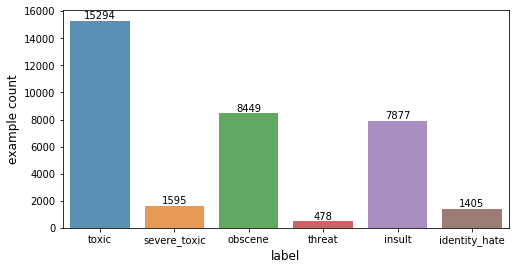

In [4]:
x=data.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.ylabel('example count', fontsize=12)
plt.xlabel('label', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### 多标签样本统计
显然数据集中的6个标签不是互斥的，所以肯定会有相当一部分的样本有两个或多个标签

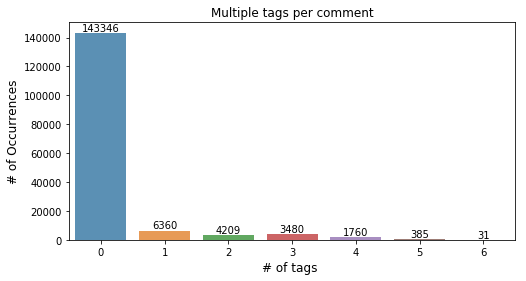

In [5]:
x=rowsum.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### 统计出现频率较高的单词

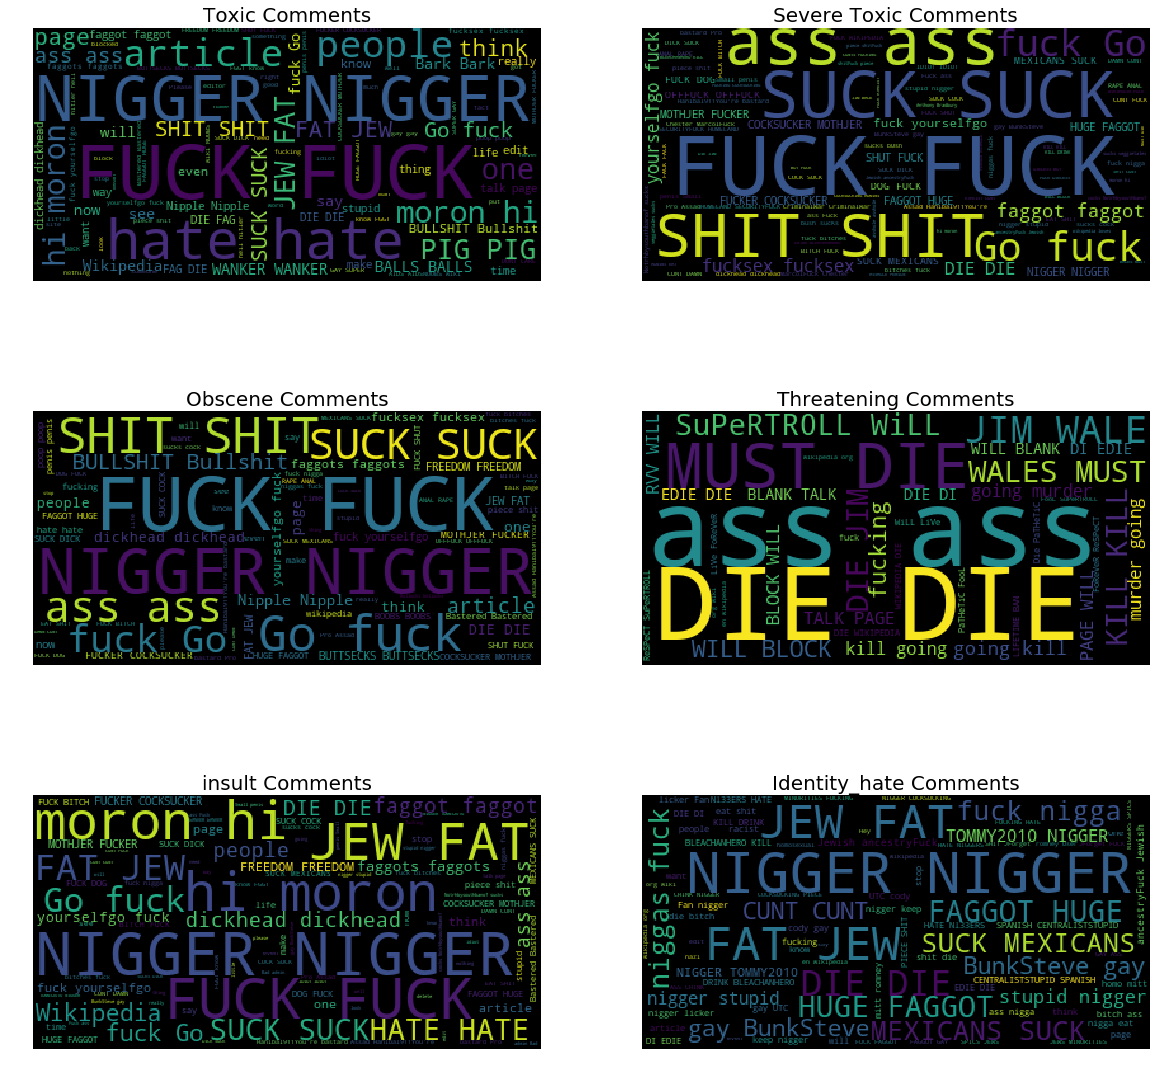

In [6]:

#wordcloud for toxic comments
subset=data[data.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.axis("off")
plt.title("Toxic Comments", fontsize=20)
plt.imshow(wc)

#Severely toxic comments
plt.subplot(3,2,2)
subset=data[data.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Severe Toxic Comments", fontsize=20)
plt.imshow(wc)

#Obscene comments
plt.subplot(3,2,3)
subset=data[data.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Obscene Comments", fontsize=20)
plt.imshow(wc)

#Threat comments
plt.subplot(3,2,4)
subset=data[data.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Threatening Comments", fontsize=20)
plt.imshow(wc)

#insult
plt.subplot(3,2,5)
subset=data[data.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("insult Comments", fontsize=20)
plt.imshow(wc)

#Identity_hate comments
plt.subplot(3,2,6)
subset=data[data.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Identity_hate Comments", fontsize=20)
plt.imshow(wc)

plt.show()

## 数据预处理

### 处理缺失值

In [7]:
print("训练集中的缺失值：")
null_check=data.isnull().sum()
print(null_check)
print("测试集中的缺失值")
null_check=test_data.isnull().sum()
print(null_check)
data["comment_text"].fillna("unknown", inplace=True)
test_data["comment_text"].fillna("unknown", inplace=True)

训练集中的缺失值：
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
测试集中的缺失值
id              0
comment_text    0
dtype: int64


### 清洗数据

In [8]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [9]:
eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
token = TweetTokenizer()
def clean(text):
    text = text.lower()
    #换行
    text = re.sub("\\n"," ",text)
    #数字
    text = re.sub("\d+","",text)
    #标点符号
    #标点符号
    r='["#$%&()*+/:<=>@[\\]^_`{|}~]+'
    text = re.sub(r," ",text)
    text = text.replace('!', " ").replace(','," ").replace(';'," ").replace('.'," ").replace('?'," ")
    #多余的空格
    text = re.sub('\s+', ' ', text)
    
    #分词
    words=token.tokenize(text)
    #缩写
    words=[APPO[word] if word in APPO else word for word in words]
    #时态
    words=[lem.lemmatize(word, "v") for word in words]
    #去停用词
    words = [w for w in words if not w in eng_stopwords]
    return " ".join(words)

In [10]:
data['comment_text'] = data['comment_text'].apply(lambda x :clean(x))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x :clean(x))
len(data)

159571

In [11]:
data['comment_text'][0]

'explanation edit make username hardcore metallica fan revert were not vandalisms closure gas vote new york dolls fac please do not remove template talk page since I am retire'

In [ ]:
for context in list(data['comment_text']):
    print(context)

explanation edit make username hardcore metallica fan revert were not vandalisms closure gas vote new york dolls fac please do not remove template talk page since I am retire
d'aww match background colour I am seemingly stick thank talk january utc
hey man I am really try edit war it is guy constantly remove relevant information talk edit instead talk page seem care format actual info
cannot make real suggestions improvement - wonder section statistics later subsection type accidents - think reference may need tidy exact format ie date format etc later no-one else first - preferences format style reference want please let know appear backlog article review guess may delay reviewer turn it is list relevant form eg wikipedia good article nominations transport
sir hero chance remember page that is
congratulations well use tool well · talk
cocksucker piss around work
vandalism matt shirvington article revert please do not ban
sorry word ' nonsense ' offensive anyway I am intend write anyth

band page's deletion think go delete comment post ' talk page ' delete feel hasty decision delete page sir still cock-sucking douche fuck sit back second think life become did not take long nope certainly aware life shitstorm sit front computer masturbate fictional creatures attempt get rid mediocre best constantly suck dick failure do not want personal attack huh well bad fuckcock mcdickerson you have get one go ahead delete profile wikipedia I will make another one come right back ' syrthiss's talk page insult dick could shatter dream innocent eighteen year old college freshman try make name band make happy fuck people you are overweight single old man dead-end job spot perhaps someone else go follow dream try hold back somebody else could suffer like yes do not make empty threats will not say anything along line ' I will hurt ' ' I will eat children within sister's womb ' say asshole son-of-a-bitch mother fuck cock sucker go eat food drown sorrow premature ejaculate bald head fuck s

ahh hello witzeman symbols ¡ ¿ † ‡ ↔ ↑ ↓ • ¶ ½ ⅓ ⅔ ¼ ¾ ⅛ ⅜ ⅝ ⅞ ∞ ‘ “ ’ ” « » ¤ ₳ ฿ ₵ ¢ ₡ ₢ ₫ ₯ € ₠ ₣ ƒ ₴ ₭ ₤ ℳ ₥ ₦ № ₧ ₰ £ ៛ ₨ ₪ ৳ ₮ ₩ ¥ ♠ ♣ ♥ ♦ m² m³ character á á ć ć é é í í ĺ ĺ ń ń ó ó ŕ ŕ ś ś ú ú ý ý ź ź à à è è ì ì ò ò ù ù â â ĉ ĉ ê ê ĝ ĝ ĥ ĥ î î ĵ ĵ ô ô ŝ ŝ û û ŵ ŵ ŷ ŷ ä ä ë ë ï ï ö ö ü ü ÿ ÿ ß ã ã ẽ ẽ ĩ ĩ ñ ñ õ õ ũ ũ ỹ ỹ ç ç ģ ģ ķ ķ ļ ļ ņ ņ ŗ ŗ ş ş ţ ţ đ đ ů ů ǎ ǎ č č ď ď ě ě ǐ ǐ ľ ľ ň ň ǒ ǒ ř ř š š ť ť ǔ ǔ ž ž ā ā ē ē ī ī ō ō ū ū ȳ ȳ ǣ ǣ ǖ ǘ ǚ ǜ ă ă ĕ ĕ ğ ğ ĭ ĭ ŏ ŏ ŭ ŭ ċ ċ ė ė ġ ġ ̇ ı ż ż ą ą ę ę į į ǫ ǫ ų ų ḍ ḍ ḥ ḥ ḷ ḷ ḹ ḹ ṃ ṃ ṇ ṇ ṛ ṛ ṝ ṝ ṣ ṣ ṭ ṭ ł ł ő ő ű ű ŀ ŀ ħ ħ ð ð þ þ œ œ æ æ ø ø å å ə ə greek ά ά έ έ ή ή ί ί ό ό ύ ύ ώ ώ α α β β γ γ δ δ ε ε ζ ζ η η θ θ ι ι κ κ λ λ μ μ ν ν ξ ξ ο ο π π ρ ρ σ σ ς τ τ υ υ φ φ χ χ ψ ψ ω ω cyrillic а а б б в в г г ґ ґ ѓ ѓ д д ђ ђ е е ё ё є є ж ж з з ѕ ѕ и и і і ї ї й й ј ј к к ќ ќ л л љ љ м м н н њ њ о о п п р р с с т т ћ ћ у у ў ў ф ф х х ц ц ч ч џ џ ш ш щ щ ъ ъ ы ы ь ь э э ю ю я я ipa ̪ ̪ ʈ ɖ ɟ ɡ ɢ ʡ ʔ ɸ ʃ ʒ ɕ ʑ ʂ ʐ ʝ ɣ ʁ ʕ ʜ ʢ ɦ ɱ ɳ ɲ ŋ ɴ 

fire you are moronic wimp lazy research make sick people like exist world
look like violate wp npa it is pretty minor I will point two content conflict try mediation cabal way it is generally easier sign type stop irc channel want advice way talk
pat head kc one dedicate wikipedians know I am madly love I had give barnstar end you would chew bury instead let offer metaphorical pat head pup see around tropics
note sandbox right place experment thank
friesers opinion simple guess kursk turn point german retreat think hes correct russians personnel improve skill glantz combination force germans retreat losses problem battle kursk tank infantry strenghts favor germans weeks kursk german tank strenghters higher kursk zetterling
oh did not know thank
lois roisman piece lois roisman omit much background everything death update please review there is anything want add
know sex foetus
think fagget get oife burn hell hate ' sorry cant sex I am run conndoms
may
sorry link give dead format harvnb 

bad redirect please remove redirect x-c page aircraft distinctly different design builder mission etc restore aircrafts unique content page
info thank enter article errors correct would nice simply cut paste text clear lake article
name troy tedford troy telford look orginal discharge paper right also orginal purple heart olc man war hero biggest world war ever historian history degree recieved dec atu
interest note aircraft land airfield hawaii
thank fix exquisite picture
would like clamp
man also create new word even modern languages already establish
it is history conveniently contribs thank explanation was not big deal upset second post — wave sneer grow thicker skin finger-waggle profanity — treat insensate piece internet polemic rather fellow human attempt give honest account account mackensen promptly remove say well understand try contribute workshop bad idea first place — run full tilt tony sidaway manage avoid irc whole month immeasureable improvement quality life anyway I ha

mfd nomination wikipedia try best wikipedia try best page substantially contribute nominate deletion opinions matter welcome please participate discussion add comment wikipedia miscellany deletion wikipedia try best please sure sign comment four tildes free edit content wikipedia try best discussion remove miscellany deletion template top page removal end deletion discussion thank ' ' ' contributions talk
redirect talk list south carolina stingrays season
care block myspace pulse music board would concern
http www theatlantic com entertainment archive linsanity-how-the-internet-made-jeremy-lin-a-star-in-less-than-a-week source explain star
god dead do not mean startle anyone god dead worry anymore think would let everyone know well goodbye good luck newfound crisis faith
hello back bongwarrior's user page attack minute
I am always request page protection detect miss errant templates see administrators correct
unsure stage clear word actually discuss
marvin kitman's do not make laugh do

support sikh wikipedians wikipedia support singh correct completely agree sikh historian I am busy moment need get harrybabar permanently block happen vandalism unacceptable
thank racist experiment page katherine heigl wikipedia test work revert remove please use sandbox test may want take look welcome page learn contribute encyclopedia go fuck racist canuck asshole u nothing better censor truth u goddamn kkkkanuck piece trash dickhead moron motherfuckerlol canucks r real retard fuk dickweed edit another eidts you will expel wiki jimbo sob dickhead watch mofo piece garbage racist mofo asshole im tryinbg nice take say compliment yamla
bulgars omg admin protect people vandalise bulgars article attackers pan-slavic ultra-nationalists dont want see word begin turk help remove reliable source old bulgars change slavs hand great
must log upload file word sign add things entry hell place rot care
mckinsey company think best route would drop note wp business c wp four wp chicago wp waward
mess

tfd nomination template silentredirect template silentredirect nominate deletion invite comment discussion wikipedia templates deletion template silentredirect thank talk watermarks shall remove obvious ones less obvious ones stay allow watermark image anything whatsoever wish even it is contradiction wish use wp bandwidth re-uploading effect cannot anything even get delete shall reupload without respect talk email could grace reply say I had deal even ones watermark visible page talk email plan re-upload less obtrusive watermarks image bliss parody jpg talk email was not vandalism use external link per instructions incidentally I am bind follow certainly verge request mediation disrupt life never mind wp make point tell one time image better none wish get pix concern image you are damn welcome try gfdl therefore there is ground removal talk email ps - shall add external link image remove shall make formal complaint wikimedia foundation information commissioner london talk email conduc

section useful info stay - clearly wrong
comment stick week break link since acknowledge move mistake uncontroversial please revert anyone want dispute opera primary topic proper request move discussion first place able today I will ask another administrator
need include context well I will try dig source user talk review
tim firstly appreciate take time discuss issue offline willingness debate length despite majority view favour yes certainly agree friend important describe jurisidictions firm present clearly massive diffence say offices french japanese jurisdictions chinese u jurisdictions since legal regulatory systems different well commercial characteristics market beyond however remain firm view big difference law firm office say paris toulouse even though jurisdiction appreciate situation u slightly complex since federal state jurisdictions even within state big differences legal market different cities though give example san jose market lot smaller overall los angeles market a

question possible citation I am sorry miss question - do not pay much attention page response question let start repeat boilerplate formulation job wikipedia editors verifiably summarize reliable source use neutral point view have not yet work original research wp say must not integrate otherwise reliable information arrive novel conclusions compare two list draw conclusions differences similarities likely original research integrate information long do not arrive new theories another principle remember vagueness improve accuracy precise harder accurate get detail predators editors website appear reliable source use source bauer site even somewhat unreliable may use limit fashion primary source bauer I am familiar enough topic make pronouncements would correct however would say propose text appear reasonable source sufficient original conclusions make website takedown issue confuse able summarize find reliable source overall opinion less say subject better attack article encourage must

curse wikipedia respect god wikipedia full lie dangerously evil half truths wikipedia respect religion follow users wikipedia namely redtigerxyz priyanath emperor genius raj wikidas wikiveer dagizza commit blasphemy sacrilage curse upon perish curse follow users wikipedia namely redtigerxyz priyanath emperor genius raj wikidas wikiveer dagizza perish curse wikipedia entirely perish beg forgiveness supreme god lord vishnu choose blasphemous wikipedia website write truth true devote supreme lord vishnu hurt curse never go vain never edit read go evil wikipedia website forever delete user-id edit evil wikipedians mr dagizza male chauvinist pig misogynist core call administrator ridiculous mr dagizza curse existance man like cannot respect women worthless existance wikipedians useless people burden civilize world even worth hatred wikipedians must ignore curse
hahaha dont actually believe bullshit tell right talk access country representatives government kim jong un two totally different t

review block say I had also like ask future sake fairness due process decline unblock request users block unless request pure nonsense abusive ethical review block mean carry rd party think pretty clear case give editor's user page gnaa etc etc etc unblock request pure nonsense also impression unblock request would still visible review admins I will careful future
regard edit make december utc kanpur please add inappropriate external link wikipedia wikipedia mere directory link use advertise promotion inappropriate link include limit link personal web sit link web sit affiliate link exist attract visitors web site promote product see external link guideline spam policies explanations link consider appropriate feel link add article please discuss article's talk page rather re-adding see welcome page learn wikipedia thank talk
come really necessary understand come sound like whiney bitch website anyone edit sort stuff come territory really expect anyone people troll wp pw read comment ta

assistance please record show delete file hmcs fennel k jpg entry leave deletion log say list wp pui days strongly suspect free image crown copyright canada protect image first years ww end years ago crown copyright image would free image I had like request userification information templates information associate image review possible clarification whatever problem get list wp pui first place could please userify
listas manos family
despite equivocation still wrong people remove vile vicious hate speech whilst remain right side policy make clear statement wikipedia policy - prove wrong deny unblock request result misinformation know expect apology wikipedia administrator waste time future stay away okay prefer deal admins know rule
speedy deletion phi rho eta tag place phi rho eta request speedily delete wikipedia section g criteria speedy deletion article appear blatant copyright infringement legal reason cannot accept copyright text image borrow web sit print material consequence ad

see post replace pop punk reference rock days
please avoid use abusive edit summaries per wikipedia civility wikipedia personal attack thank happy edit please make personal attack people minneapolis minnesota wikipedia policy personal attack case users engage personal attack may block edit admins ban arbitration committee comment content contributors people please resolve dispute appropriately thank
dect is not really new technology it is newer standard tdm tdma fdma digital telephone use lot longer life dect dect successor ct japan's phs similar course gsm d-amps others extensively use across world decade half suggest special health issue dect would definitely place undue weight subject dect considerably lower power analog systems replace transmissions inherently even use td nature system mean system is not transmit continuously believe I have say nothing wrong properly research article health effect low-power radio technology link see also section article article course look nothing 

he is seem insistent add pointless ramble talk page is not forum make cut http en wikipedia org w index php title talk axm rifle diff oldid keep revert removal
guess explanation wp csd still zero fail explain page weas delete wp csd threaten inquirer block poor form extremely poor form
proton reach fusion distance
beauty pageants interest beauty pageants contestants does not mean notable - please do not go try delete stuff ignorant topic deal happen think tons article meet wikipedia's standards individual merit particularly comics etc wise enough know truly understand significance leave alone much prudent avenue would bring issue appropriate wikiproject wikiproject beauty pageants address yoru concern first instance one example continual use term model describe use one editor incorrect somewhat demean
mohammed al-bayati's qualifications regard edit past day think mohammed al-bayati's qualifications tangentially relevant purpose text place right prove mohammed al-bayati qualify review a

trivia I had advise look word good dictionary jay mr townsley's marriage important business dynasty obviously noteworthy it is note prominently article link cheer
might remind english language wikipedia greater precedence perhaps think go edit ja wikipedia take aggressive attitude especially since problem example name easily fix you are clearly incapable appreciate improvements make english perhaps you are best person judge
speedy deletion david fork tag place david fork request speedily delete wikipedia section criteria speedy deletion short article provide little context reader please see wikipedia stub minimum information standards short article also please note article must notable subject provide reference reliable source verify content think notice place error may contest deletion add top page exist speedy deletion db tag couple add note talk page explain position aware tag speedy deletion article meet criterion may delete without delay please remove speedy deletion tag do not he

totally wrong synonyms term kshatriya andhra kshatriya use rajus cast andhra pradesh acording anthropological survey india kumar suresh singh see also book rajus kshatriyas also call rachavaru telugu medeival period thats krishna rao use word rachavaru also ordinary man b v krishna rao belong andhra historical research society accord kumar suresh singh kshatriyas migrate north india locals also support anthropologers truth aryans initially enter indian sub-continent stay north india north-east cast e brahmins kshatriyas vaishyas gradully migrate settle south india
perhaps better self better job pravda russian state ist pravda ru privat two different newspaper pravda homepage http www gazeta-pravda ru
german habilitation degree define law
desktop computer clipart - yellow theme
wrong everything stupid notice lose cause existence blemish
quality wifi I am currently visit france stay two apartments v box case seem wifi router cope one device time info available issue dhcp server do not se

invader spleen look invader zim say put izfas page
untrue block reason mention rather entirely different reason since reason mention actually true impossible exhibit battleground attitude many reason include fact one cannot exhibit something unless one display engineer museum would therefore impossible exhibit anything let alone battleground attitude fact thing battleground attitude fact thing attitude regard human act fact word exhibit use incorrect manner solely purpose antagonize user antagonize usage word like exhibit attitude refuse follow section title requirements page show obvious malfeasance intent person therefore block cannot valid within first sentence already seriously demonstrate lack appropriate intent specifically purposefully antagonize second claim physically possible blatantly false specifically attempt prevent users refuse communicate appropriate manner repeatedly reply conversation several different locations report yet people allege help desk refuse tell report ev

mean think stick source say source uncover portray subject anything criminal rule change blps longer reflect source say
like someone post factual information step personal politics get brand edit war
redirect talk john sadler town clerk
dad sam I am worry worry cock wont fit ass anymore omfk lolz haha say peeenis gorf gorf gorf gorf
word rodney king cannot get along
someone explain criticism take criticisms section article since logic inherently constant things true others mean strong relativism cannot hold true many condition relativism often ignore view different weight another example similar phenomenon gay marriage debate u - example majority dictate right entirety even does not apply weigh effect view someone explain exactly mean follow first half paragraph one actually pertain relativism example read complete nonsense especially part majority dictate right entirety even does not apply weigh effect view think majority question believe does not apply though I am sure context senten

justin vaisse's opinion relative absence french-american political social unity help explain anti-french sentiment unite state french historian justin vaïsse propose important cause overtly express public hostility toward france unite state small number americans direct french descent http www politiqueinternationale com revue article php id revue id content synopsis acknowledge direct cause anti-french sentiments argue explain sentiments express publicly without see gross violation political correctness vaïsse contend comparison public display sentiments towards ethnic group nationalities would meet strong disapproval propose france powerful organise lobby defend socially politically acceptable unite state express negative sentiments frenchpierre verdaguer turn-of-the-century honeymoon washington post's coverage france french politics culture society vol summer answer I have read proportion french descendant us way higher think french colonize new world time brits get outnumber pretty

silesians andrew make comment desire provoke edit article desire ensure meet standards conventions english wikipedia sorry negative experience german wikipedia separate project english project assume good faith fundamental principle english wikipedia advise give editors chance instead assume worst inquire silesian polish silesians sometimes consider separate ethnic group sure mean revert article upside edit ensure format style consistent biographical article anticipate able copy-edit article remove watchlist good luck article olessi thank comment fact fruitful discussion right work person important however much present past propaganda destroy peace people would show objectivity patience could clear mention nationality however important since exceptional individuals inspire new generation nation unfortunately nations ethnic group still exist hope peaceful coexistence fair competition seem competition exit – best fun conscious english german wikipedias separate project see approach germa

israeli-palestinian conflict protect yesterday relevent reliably-sourced casualty figure add israeli-palestinian conflict article editors object seem call quickly protect page edit effectively block inclusion figure cite edit war accurate term would repeat revert like figure political reason casualty figure conflict war battle etc wiki article reference one thank romac edit try make set statistics one year attemepted place first paragraph article describe conflict sixty years article cover issue extreme sensitivity complexity fact edit spark much conflict opposition speak wikipedia value ability achieve consensus fair many viewpoints believe often achieve article israeli-palestinian conflict enough disinegnuously claim figure reliable without address underlie issue conflict clearly immediately cause repeat statistics one year conflict belong anywhere article's lead wide variety figure either side could quote name objectivity would clear unacceptably attempt create slant towards one sid

I am back already create id occasionally forget log see class c collect massive number diff edit balkanfever pretend neutral record get block say greeks previous handle mention personal talk page one big anti-greek rant fest point questionable fyrom news source highly exaggerate sensationalist title assfuckers nice ring use pejorative term ready pull trigger admin futper others e g macedoniaboy say proud fighter unite macedonia talk page detail complaint anti-greek propaganda since futper manage civil discussion seem stick debate article rather threats block I am go avoid escalate ns current name dispute article agree fyrom citizens honestly believe claim do not think reduce existential threat greece communism fell years ago yugoslavia fyrom government appear get worse better imagine two hundred years call ethnic athenians cycle continue greece leave appear important quote miss name dispute article clearly demonstrate fyrom leadership confuse national identity confuse citizens process 

dare block without cause right abuse position do not demand immediate removal administrator tannim
camille paglia sex-positive feminist support link ask stupid twit http www lotl com content paglia htm http www reference com browse wiki sex-positive feminism lazy full read entirety post relevant section camille paglia hand ’ say public five years ago someone ’ endorse prostitute strippers whole extreme sex-positive experience ’ concern effect young people – people grow climate ’ go opposite direction ’ already concern ’ really outrage stereotype way career teacher yes situation commercialise sex push without true eroticism … ’ say years get point meaningless exhibitionism without real eroticism ’ eroticism camille paglia major american social critic paglia's academic write focus role vibrant dangerous sexuality human history paglia's key importance sex-positive feminism write sex advocacy traditional value like canon texts paglia somewhat intellectual enigma conservative academic femin

december utc current rule notable turkish citizen receive award notability due root hence need mention open make bundesliga remark do not see did not want anyone comment perhaps read someone else it is current rule are not dubious fact clear issue settle accord wp rule would like go please would like find mesut ozil was not notable professional bundesliga player fact receive reputable award relate root contribute anything notability thank
arabic wiki hallo rouge admin know little perhaps islamists hope ar wiki majority always write history it is advantageous rouge admin one's side ar wiki criticism is not blame wiki whole consider products evaluations u regard paragraph one arabic journalist netherlands bla bla bla sure come doctor
pizzeria quesrtion name father's pizzeria one suspect work hear unsubstantiated report pasquale's anyone confirm deny jh
does not matter call english scources provide british commonly call english term incorrect kingdom great britain wwi article replace germ

pretty much say first day post neither problem cabal's decision cabal's logic deamon concern vote basically say do not know mean stay burma cabal's conclusion article happen freeze myanmar mediation cabal would myanmar article see myanmar side would unhappy however burma side agree abide next decision bet every panel mediators might side myanmar find least many panel side burma husond right end first look mess say post current evidence side editors mediators able reach fair compromise appease side issue matter much think put good point argument I am burma camp see things I am look leave split identical article bizarre bot switch back forth daily new type mediation imho end stretch imagination choice does not look appeal
ok ok peep eye know violate wp pa yes deserve block get thank like say I will live see around couple days mailbox
user talk - contributions
update sun save - season would due time less player profile get ready get chop court
season greet jenna best wish festive season p

go say thing beat cost like dollar read la time archive
janettedoe appreciate find upload rao article however easily become endless discussion yadav-apologist soon come along find even obscure source rao — conscientious rigorous degree yadav apologists intention aware unaware — go scurry article try interpret weigh pros con degree apologists busy look next roadblock toss path think cannot make determination whether rao apply least yet let secondary source need rely recent scholarship especially textbooks publish academic press vet publication reviewers wide range scholarly journalistic background two book susan bayly christophe jaffrelot widely use universities around world review extensively literature use article let article write rewrite proceed base similar book article flesh come back issue rao otherwise nothing get us who have take time wikipedia speak rl pursuits attend article slowly walk away touch sympathy « talk »
disagree it is well establish list character appropriate wiki

einstein search document might bear einstein's name - league nations archive - - return result see http biblio-archive unog ch archivplan aspx review five book deal einstein's work life - single one mention einstein's support ustase cause one write german einstein sein leben denis brian christine von samson-mark wiley-vch page indem er sich den angelegenheiten seine eigenen land zuwandte empoerte sich einstein ueber deutsche studenten die fuer die entlassung eines professors agitierten weil dieser ein pazifist gegen politisch motivierte todesurteile war es ist entsertzlich zu sehen wie die unerfahrene jugend fehlgeleitet wird schrieb er das berliner tageblatt wenn die weitergeht werden wir nach einer tyrannei der faschisten bei einer herrschaft des rotten terrors ankommen er glaubte dass eine solche herrschaft bereits jugoslawien ausgeloest worden sei und kritisierte die landesregierung fuer den mord dem kroatischen fuehrer professor milan sufflay der geschichte der universitaet von za

argument take word source say personal opinion original research rather facts support reliable source state earlier present reliable source state otherwise disagree source give secondly nothing wrong integrity source give claim global financial centre index commission city london corporation must bias base london fail mention two source give forbes mastercard american base new york city provide source support notion city london corporation bias institution clear argument article face two choices go thmc's personal opinion original research word city london corporation forbes mastercard
let us beer celebrate thank review unite state v kagama newly promote feature article boomer
problem confuse see also was not italicise did not realise actually publication think contemporary japan anyway I have make final tweak it is good pass nice work
could simply change caption reads'a drain sydney explore graffiti happen photo
ortiz write take www ex-iwp org site social therapy absolutely nothing cu

rout rockville route metro center - shady grove red b glenmont route metro center - glenmont red c huntington route metro center - huntington blue orange-blue-blue yellow-yellow new carrollton route metro center - new carrollton blue orange-orange e branch avenue route gallery place - branch avenue green yellow-green f greenbelt route gallery place - greenbelt green yellow-green g addison road route junction - largo town center blue j franconia-springfield route c junction - franconia-springfield blue k vienna route c junction - vienna orange l route f junction - c junction yellow idea h dull columbia pike branch talk -
pick year old soooo sad shut okay im years old want little fun captain buzz kill guess never life young probably like years old lol none yo beez nas
yeah sure could use pov pushers loseristan
mr caldwell show wear number tag state penitentiary apparently charge crimes one federal charge tell
post
ok mistake case feel free resubmit afc talk
hey tomorrow tony happy let ce

october utc hi tom understand do not convince similarities it is wp require citations reliable source case author book music paper article professional website like allmusic make connection examples though worthwhile do not solve ' citation need ' issue however I am sure I have see mona soon connection make least one book smiths let scout around see find take care tks stop discuss cheer
I am work thank tip
ec moni use say dictionary national biography article better use oxford dictionary national biography article first free everyone second free uk library subscribers never mind year difference scholarship turgid prose edwardian victorian pov I have see argue use dnb odnb it is like competence is not require edit merely civility wrong many count it is even funny take latest wikipedia foundation survey today find unsettle question seem aim close edit wp fb would make cooler social media etc one remember we are suppose write encyclopedia - talk
so-called demographic prediction combine co

friend problem look discussion page history edit suspicious persons add croats serbs claim was not bosniak croat serb bosniaks denie I am glad propose tvrtko I am consider later add total number vote see fuchs
consider legal issue surround roms would bad idea I am sure one I am fairly sure post rom would violate wikipedia rule
subject ongoing attempt politically bias wikipedia editors suppress mention neil degrasse tyson's embarrassment prompt widespread derision political right b log conservative opinion piece may reliable statements fact see wp bias well-known high-traffic non-fringe etc national review volokh conspiracy weekly standard etc etc absolutely establish existence controversy partisan dismissals significance controversy side political spectrum subtract nothing fact
false friends slavist recommend talk miloš rančić study slavistic
barnstar barnstar diligence stalk people chance see you have high-speed trade keep one side finacial industry greak work stalker bo
I am sorry mu

ctmu pass academic theory cannot langan member academia theory need academic notable example print television journalists readers view audiences deem things notable well academics monopoly logical factual correctness scholarly integrity intellectual merit except possibly well-indoctrinated mind academics course aspire apprentice whose eager anticipation scholastic glory sometimes inflate academic snobbery blimpish proportion byrgenwulf complain chap sole arbiters belong article correct credit invite others tag assertions however bite specious belatedly come realization relevant verifiable assertions make specialize challenge assertions others thus find imperiously rather comically demand every one langan's assertions receive separate citation flatly unnecessary source material assertions make already directly link article important byrgenwulf understand exactly burden proof opponents must provide legitimate citation anything wish add article give article already link ample source mater

discussion two-way street where is wikipedia editor staff contribution discussion justin berry talk page question side argument ignore one yet manage justify removal thoroughly-documented information justin berry page I am try throw gasoline onto fire do not agenda I am honestly particularly interest mr berry sordid history interest see wikipedia respect accurate source free information seek wikipedia staff engage organise effort remove accurate information justification whatsoever normally call wikipedia vandalism vandalism wikipedia's credibility go window justify yourselfs maybe  will start listen side justify repeatedly it is turn
hey need watchlist page guarantee someone actuall step mediate need watch page see someone information read good luck talk
review wp nfcc page wp nfrc determine file article re-add
azeri never ever consider myslef turk republic azerbaijan part iran become part iran people pretend azeris actually turkey try spread turkush propganada real azeris iranians
co

agree many part article apparently bias made-up bs examples follow downfall common knowledge de molay plan corrupt catherine valois ' male children tend sorrow engage act anal rape philip know dangers de molay represent sons nearly sexually molest de molay upon escape vile pervert confess philip de molay try myths say jacques de molay curse philippe le bel descent execution pyre curse respond philip shout defiance fuck de molay speculate several boys de molay corrupt grow enjoy perversions homosexual lifestyle introduce legacy members encourage model conduct example loyalty fidelity instead homosexual perversions de molay guilty vile pervert homosexual perversions sheesh could someone sane please clean article
scott apologize write way much respond coherently would like email see
racist goddamn neo-nazi big boy
something suspicious durrani empire article hello kansas bear think something suspicious go durrani empire page would like opinion
even know feminism
reality check montevideo re

yeah paragraph mess starters already fascist regime italy great depression I have provisional edit paragraph include wikilink weimar etc present 連絡 見学 迷惑
- ola thank experiment wikipedia create page - ola test work soon remove please use sandbox test want take look welcome page would like learn contribute encyclopedia aeropagitica talk
request could please fix mistake soundwave appear first transformers film http en wikipedia org wiki transformers film page lock unregistered editors thank
currently appear nothing wikipedia short term lend australia new zealand shame short term caveat loan valuable tool small busnesses may need access large sum money little hours however lot know caveat loan despite business australia alone
one object propose section circumcision fetish gilgal fellows assume consensus delegate research get back asap
one addition mustafaa promise much stuff busy lately one thing stick could fix quickly begin invasion yes fault add argov incident make sound main reason in

vandalism edit make factual would glad provide source please revert edit unless counter-sources atleast valid excuse
thank feedback especially point opportunity original content show brain regions pathways
sodom final fight please stop continue vandalize page deliberately introduce incorrect information block edit wikipedia
number make was not invent insult was not even insult pete's sake you are go overboard tell exactly say god must make us though do not know do not believe did not read section thoroughly
mfnickster sure ever exposure argumentative fallacies write exterminate negro population biographical account mean idea wholly seem enough evidence warrant section article topic sure hard grandmother something
twin tower tall
well hope someone else get work think it is useful tool thank write look forward update - ♫ ♦ ♫
nark - ok disprove point say advisors station georgia proper buffer zone un control areas georgia proper it is georgian mission say advisors station georgia proper i

hmmm actually write response send oh well record response resurrect article frown upon yes might able get away article resurrect substantial improvement last one however - though course know there is guarantee would ultimately accept whatever - establish bias towards delete article individual match change name would nice I am sure would change game did not really name like ballet ice limit ways name article make subpage decent idea get unlucky it is something already try elsewhere ultimately vote honestly say I have never see subpage actual mainspace article idea much people tend chase article whether might glean community-wide shrug shoulder certainly there is afd nomination yet start say somewhat favour make standalone article merge season article e keep subpage do not strong feel I will run whatever work get categorise would either put category something like category football match idea exist another example category fa cup probably new category city match comebacks somesuch probab

awesome thank take time look forward run btw special interest malaysia something I have notice lot place start ♦ dr blofeld
legislation european union atricle claim european union ratify law ban incitement denial genocide holocaust armenian genocide source read european union ratify law “ ban incitement denial genocide ” arguably include holocaust armenian genocide enthusiasts remove word arguably cite source let us look law framework decision combat racism xenophobia official press release certain form conduct outline commit racist xenophobic purpose punishable criminal offences public condone deny grossly trivialise crimes genocide define statute international criminal court article crimes define article charter international military tribunal conduct carry manner likely incite violence hatred group member group example somebody publicly claim act genocide commission establish fact international court never happen invent ethnic group concern solely purpose able claim compensation pay

stanley's prototype everyone know stanley's prototype early version e know cause write hit
low self-esteem see low self-esteem warn others attack
scope article limit right keep bear arm limit firearms include type arm article mistakenly presume apply gun scope discussion broaden encompass scope right — precede unsigned comment add
want report vandalism user wikipedia alexikoua think vandalise information ethnic group albania incresing percentage greek population albania think clear vandalism greek nationalism want help problem want solve problem soon possibl think vandalism serious problem nationalism user zakoni p correct informatoin source albanian government http www instat gov al media rezultatet kryesore censusit popullsis dhe banesave n shqip ri pdf user use source accordance rat user add wikipedia addition source user belong year earlier want take disciplinary action user alexikoua
accord page c nist document http ts nist gov weightsandmeasures publications upload h appenc pdf c

elements connections alien franchise also weyland company confirm part film I am say necessarily direct story tie trailer make explicit  will see space jockey derelict ship original film connections alien
ut attack victim december
is not project page it is encyclopedia article reason cannot use source information update article it is major league soccer season alpaugh
synth apply france liken us would good get academic source cnn talk issue oversimplify
problems cannot remember come first place I am glad help wherever p talk
alter comment others vfd discussions
please vandalize page edit senior citizen continue block edit c how's drive
you have warn - please stop apr utc
good call thank
hi hi welcome wikipedia want let know smell like drippings poop chute cheer today
p - hell go block are not admin
redirect talk list entities involve - financial crises
provide reliable source ganga lal gupta clearly proof kushwaha come kshatriya varna mother fucker blind eye cant see
disgrace sit life 

fair enough everything people read say indicate refer exclusively follow scientific method ol ' tom dick harry contrary opinion webpage say do not specific person group mind mathematics call talk say things without ground examples vacuous
block entire ip range fair
sep utc
help com go make doesnt give much kudos go play voodoo like dimwits find ' black ' tell send
user bongwarrior user favonian love frequently
thank μελ ετητης
appreciate help thank clarification nomination deletion page alexander hamilton reverend take offense comment page since initiate thread illustration treat humorously clearly recognize issue norton's comment along line you are linguist would know thank
I am sure eat alot tube steak
nice man talk convince it is interest you have decide launch entire saga simply censor citation selimovic's autobiography relevant article
fuel drop millions manga volumes sell precise news say ten-thousands yes google translation display millions absurd
please do not edit archive poin

poor start sorry author seem totally mislead real history opinions table first common two-nations table possible patent nonsense second object follow passage russian table speak kievan rus someone suggest earlier table mean include disclaimer explain loose ancestry kievan rus modern russia main dispute claim comment enough article unacceptable several ukrainian belarusian users regardless ukrainian military table none may include red army army irrelevant ukrainian state formal post-wwii exception also significantly anti-ukrainian instance red army units widely participate war crimes ukrainian population anti-soviet guerillas creation ukrainian table mere discussion trick support ukrainian users instance see earlier alexpu's passage trade truth give I had suggest delete first draft find ways compromise mr buckshot thank innocent editor valuable attempt hope cooperation issue
admittedly bias source less first hand information chabad group smuggle least claim matzoh ukraine iran passover 

official christian death ® page constatntly write opinions non factual rubbish simply need change leave alone prepare unbiased wiki article wish place know full well minutes later fool wish write things know little vest interest make appear facts alter suit quest become cd desperately alter content article need protect updateable official christian death facts people want information past members page dedicate article adhere much facts allow rd party discussion regard valor rozz eliminate favour christian death biography message myspace com official christian death discussion page article propose thus text - alter page format correctly alter main page add feedback discussion thread call - edit talk christian death ® comment inside christian death biography discography begin god create heaven earth christian death turn upside history officially musicians involve band therefore historical litany would impractical form los angeles front year old vocalist lyricist rozz williams band releas

zafarnamah religious letter victory guru gobind singh ji verse verse praise akal purakh waheguru verse deal aurangzeb ' invitation guru meet guru's refusal meet aurangzeb - instead guru ask aurangzeb visit verse deal detail events take place battle chamkaur december verse reprove aurangzeb break promise give agents nawab wazir khan raja ajmer chand hilly rajas verse deal praise aurangzeb verse guru gobind singh also warn aurangzeb khalsa rest evil empire destroy ' ' ' zafarnamah religious letter victory write guru gobind singh mughal emperor aurangzeb lord perfection personify eternal manifest miracles generous grant bounties merciful deliver us world grant peace security always merciful forgive us sin hold hand guide us provider sustenance charm everyone lord king kings guide us time shower benevolence without colour incomparable formless possess material things army merciful grant pleasures heavens pure one everything universe glory pervasive bestow us gift present everywhere mercifu

style font-size smaller class autosigned — precede unsigned comment add
evasive non-collegial ask direct relevant question allude wp el seem apply believe apply please quote part appropriate quote did not happen
nes million nes north america sell million source include na shipments snes million already article topic seven million sell source http news google com newspapers nid dat id klpwaaaaibaj sjid mudaaaaibaj pg http news google com newspapers nid dat id thehaaaaibaj sjid togfaaaaibaj pg http news google com newspapers nid dat id - jeyaaaaibaj sjid rxqeaaaaibaj pg
sound good although I had happier indo-european stuff stick around section readers en wikipedia fact speak one indo-european languages many young people school assignment may want concrete examples course make article complete survey tense general know languages big yes english future people kindly settle argue english grammar page will not object remove crap add let us throw baby bathwater dec utc
well seem proposal is n

block accuse troll others believe ’ troll please keep block hillary clinton troll ’ happy troll hillary clinton troll ’ troll believe ’ troll please first unblock block right reason would base evaluation base right accusations till defend line hillary clinton say “ would like offer historic perspective compare putin hitler ” thank
content library object function use outside situation late august class page mediawiki page init page site title - page title title wikimedia site site title name page form suitable interwiki link urlname name page form suitable url titlewithoutnamespace name page namespace part remove section section page part name ' ' sectionfreetitle name without section part aslink name page form title lang title site wiki page encode encode page isautotitle title well know auto-translatable title autoformat return dictname value value year date etc dictname ' yearbc ' ' december ' etc iscategory true page category false otherwise isimage true page image false otherwise g

you are make sense second time you are address things I have mention wrongly
thank information well perhaps best thing delete redirect get view past month people probably look see -
ignoramus cousin hitler picture swastikas I have one talk imbecile cannot believe people stupid like exist make want start play russian roulette
march utc hope get extra tool oversight joke nice see k long oh come that is comedy gold use engineer students like bainuu
december utc joke right anorexia eat disorder semi-vegetarianism woohookitty cat scratch refer section article talk eat disorder link self-reported vegetarianism veganism proposal section move semi-vegetarian vegetarian article does not explicitly mention veganism - francistyers
exactly edit lil jon vandalism
aip go fuck - the'fortyfive '
please stop continue vandalize wikipedia hanukkah block edit
small penis lalalalalalalalala
naturally occur opioid antagonists wikipedia - compound akuammine also show vitro act opioid antagonist
deletion disc

ms jackson lyric andre yeah one right go baby's mamas mamas mamas mamas baby mamas mamas yeah go like chorus andre I am sorry ms jackson oooh real never mean make daughter cry apologize trillion time I am sorry ms jackson oooh real never mean make daughter cry apologize trillion time big boi baby's drama mama do not like doin things like havin boys come neighborhood studio tryin fight need get piece american pie take bite that is house I will disconnect cable turn light let know grandchild baby paycheck private school daycare shit medical bill pay love mom everything see ain't one lay wanna rib start custody war lawyers stay never get chance hear side story divide fish fry cookouts child's birthday ain't invite despite show utmost respect fall defend lady call yeah chorus I am sorry ms jackson oooh real never mean make daughter cry apologize trillion time I am sorry ms jackson oooh real never mean make daughter cry apologize trillion time andre daughter get special thang goin say it is

street gang mr davis thank note talk page really appreciate it is honor receive communication author important book article's creator main editor I am sorry think review section negative please understand intention present way way try disparage book rush get article publish google search review find also please understand wikipedia article article stand never complete it is work progress think article street gang important enough get mean professional writer I am certain kinds weaknesses depend upon feedback experience editors would've think section article demonstrate respect work appreciate feedback something always welcome wikipedia editor aware source was not able locate please send way talk page I will repeat message via webpage ensure see also know I have take upon improve sesame street-related article wikipedia it is big project great need example sesame street one point actually feature article recently downgrade really good reason it is unfortunate state current time book come

I am sure position clarify answer four yes question think moon's orbit concave inward think moon's orbit concave outward think moon's orbit convex inward think moon's orbit convex outward -
request help unregistered editor single static ip address repeatedly try remove section call reputation article southwestern university school law I have try reason talk page see let us talk does not seem want respond also post nonsensical things talk page response reversions claim ownership article could try talk I am really sure handle thank joshkagan jrkagan talk
sorry hi kukuwesene unfortunately suppress edit reveal much personally identifiable information policy protect editors ' safety hide information share I am really sorry suppress edit know it is annoy it is best please do not re-add information useful information privacy safety take look wikipedia guidance younger editors wikipedia privacy confidentiality discretion thank sorry mess page talk
ass lol vandalism goaste
follow cheetham winkl

section need edit line new hampshire accurate january first time martin luther king day officially observe state prior new hampshire arizona observe day fact new hampshire pass civil right day honor dr king civil right activists like rosa park malcolm x since article state clearly state utah different name holiday include combine confederate military heroes sentence seem justifiable article leave impression new hampshire sort bigoted state one last recognize holiday newbie wikipedia fix
crusader state thank fix obvious mistake wonder relationship holy roman empire latin empire worthwhile resources mar utc
longer I am sure editors come sort compromise
first I am benfica supporter it is clear sport much club despite hummiliated that is say enough frequently past years look league table past season achievements it is clear benfica become rd giant however may change season
hi cyta it is bad practice know happen scholarly journals assumption specialist shall speak unto specialist rest go de

hash infotech tag place hash infotech request speedily delete wikipedia criteria speedy deletion article seem blatant advertise promote company product group service person would need fundamentally rewrite order become encyclopedia article please read general criteria speedy deletion particularly item well guidelines spam indicate subject article blatant advertise may contest tag please add top hash infotech leave note article's talk page explain position please remove speedy deletion tag do not hesitate add information article would help make encyclopedic well add citations independent reliable source ensure article verifiable feel free leave note talk page question
unblock disclaimer identify nazi neo-nazi facist neo-fascist accept agree action view hitler dictators world matter hate jews fact many jewish friends hello although technically unblock appeal really reason explain will not mood unblock I am finish talk first want apologise think put giant swastika page reason jewish frien

actually I am complete agreement picture caption sorry was not clear know dye lasers it is often common filter tube around lamp usually water flow absorb nir cause thermal shock liquid I will look thank explanation spectralon make great deal sense yes would've helpful article delete often helpful include small parenthetical explanation specialize word anyway see use polish ar coat rod would beneficial cavity couple light difussing surface rod know sad experience keep light diffuse either way almost necessity keep rod crack - believe also read kentek website one accurate source I have find lasers principles lasers oratio svelto although book little difficult follow write math anyhow thank assistance -
anti-israel comment anti semetic ahh another zionist come save propaganda im antisemite say anything sort prove say anything jews zionism race religion fanatic radical islam threaten allow
february please vandalize page edit history europe continue block edit
trailer vs final film notice t

speedy deletion supportspace tag place supportspace request speedily delete wikipedia section g criteria speedy deletion article seem blatant advertise promote company product group service person would need fundamentally rewrite order become encyclopedia article please read guidelines spam well wikipedia business ' faq information think notice place error may contest deletion add top article exist speedy deletion db tag couple add note article's talk page explain position aware tag speedy deletion article meet criterion may delete without delay please remove speedy deletion tag do not hesitate add information article would would render conformance wikipedia's policies guidelines
hm claim work outside hacker intrude upon university east anglia's climatic research unit skulk smash-and-grab come carefully structure foia zip archive predominantly consist data file computer code - gracenote minority e-mail show utterly rotten-to-the-core correspondents responsible run cru also realclimate 

eu ' german ploy ' might worth mention article many people eastern europe elsewhere e france russia europeans countries refuse join many others believe european union nothing ' german ploy ' ' control ' europe politically economically give germany economically powerful populous member eu say success eu obliquely fulfill third reich's burn desire germany become undisputed master europe hypothesis include article simply write delude conspiracy theory
do not post garbage page
way play bruv fuck buy flat back january I have edit see fit dunno I have abuse multiple account do not think you are idiot know carat idiot look edit history way originally say r b pop do not believe get eye use ' em I will expect apology
have not look blatant pov edit history malik shabazz interest agree pov push fear
derivation imp there is activity change derivation imp article derivation incarnate memories prevail unpersuasive least cite derivation verifiable source cite clarifications welcome -
redirect talk su

replaceable fair use image ufc ortiztito gif thank upload image ufc ortiztito gif notice ' image ' page specify image use fair use use wikipedia article fail first fair use criterion illustrate subject freely license image could reasonably find create provide substantially information believe image replaceable please go image description page edit add without delete original replaceable fair use template image discussion page write reason image replaceable alternatively also choose replace fair use image find freely license image subject request copyright holder release similar image free license take picture upload fair use media consider check specify image fully satisfy fair use criteria find list ' image ' page edit click link note fair use image could replace free-licensed alternatives delete days notification per fair use policy question please ask media copyright question page thank
kane's secrecy quote article ally campaign complete red alert ally would emerge victorious time l

article shine big problem lack reference even stuff true need reference cause rest world go know whether someone make ways combat use information school's website yes school's website suck info use information local newspapers trib chron local publications use information school newspaper yearbook literary journal great thing students get things otherwise would go underreported editorial oversight reliable far wikipedia care unlike student's blog unbeknownst many there is also book skyline call skyline sportswriter tim keown author follow around basketball team skyliners interest improve page might go check library
description page ad description page description one external link is not spam
note section clearly intend conversation john zad will not move let move comment - elvey
unblock request unblock review sorry blurb go detail elsewhere admins review complete history astrotheology notice I have patient deal editors extreme language create stressful situation please see outside opi

empower amnesty reward brand new arbcom open coffee precursor disruption drama utter contempt editors move forward mr macdonald cannot ways cannot show utter contempt community consensus intentionally create drama disruption two days later attempt create community consensus write arbcom arbcom send powerful empower message editors like coffee give amnesty community rule do not matter administrators forgive reward blatantly break community rule learn kww rfa editors say blatant falsehood enough time become truth already people state rule break rfc blp one could argue rule break argue break utter contempt excuse administrator desysop happy note focus scott minimal next days focus coffee's rich edit history look forward comment support coffee arbcom frank andersson revisions restore olympic medallist f k's sake
organizational grammatical problems throughout - give examples always anxious improve quality article
I am guy kind conspiracy enthusiast story website www valleyscanner com http w

that is good idea assume someone relevant jurisdictions prepare take work agree useful information article would swamp complete list uk example think would fine article list w l r aller current series official report rest could new article
may utc precisely point
faggot faggot faggot faggot
unprotections wonder think idea think would good solution situations like steve irwin unprotect article make sure someone watch do not time inclination
russian tourists chance drink водка guess
tag administrator delete talk
thing gay rumor whether true pretty much become define characteristic kordell's career would encyclopedia worthy say stewart probably gay worth mention stewart deal accusations homosexual througout career include something like is not pass judgement homosexuality even stewart's lifestyle it is simply point something part career actually surprise mention that is check discussion page
hi currently article nominate fac see unfortunately is not get much attention anyway nominate one 

vote b she is obviously right-winger self id's first thing think see ann coulter - damn that is hottest look woman I have ever see include demi moore next think know I am gonna laugh butt incite liberals never fail disappoint would probably delight call right-wing extremist think smart enough fall little trap
do not really need anything heh
prosecutorial career section section left-wing criticism claim impropriety unacceptable need care elect many case prosecute bore facts need claim impropriety maybe reportage daily kos balance section
fuuse hi salim need prove natability company fusse produce record film lot media coverage uk norway also win peabody award usa contact deeyah forthcoming project refuse disclose company well
good work tireless contributor barnstar excellent job work statewide legislative elections unite state continue good work
nobody know much matter years do not know sea change journalists review new site day two launch think really need mainstream press coverage retr

leave note couple days ago whether think abp burk would name cardinal do not really know doubt st louis one diocese baltimore come mind sometimes cardinal always one abp since cardinal carberry retire early ' die think church become less european north american church see fewer cardinals small mid-sized diocese like stl africa asia south america also think controversies things like st stans make less likely thatburke would get pick red hat
hey say open mean anyone edit itchy
neither brew tell us real speed light measure measurement speed light seem agree definition present problem long provide length standard sufficiently precise speed light still measure inner solar system scale least admirable precision talk
charles sumner article hello dr jensen recently make edit charles sumner article expand dominican republic annexation treaty information president grant areas need work cs article
african american please stop continue delete edit legitimate talk page comment block vandalism
reall

I am pretty sure wish could find history toponym river plate relative neologism coin british empire esp england perhaps little century ago - you are surety misplace british call river plate since drake barest minimum research counter assertion fact book entitle narrative operations small british force command brigadier-general sir samuel auchmuty employ reduction monte video river plate field officer staff illustrate plan operations - publish see samuel auchmuty
page discuss demeanor rather subject article please refrain edit talk page unless something discuss want discuss subject entry go appropriate page
book meet qualifitions gfdl license view many book text google book do not feel like purchase one link original article link history page misinform readers wikipedia intentionally wikipedia use misinform readers unhappy additions filiqurian page mostly false uneducated assumptions
smile even though guy hardly smile
sick bastard hope get lesson soon
cannot quite figure system number d

I have explain article noise signal-dependent snr system require come model signal go look like first —
plea educational institution really constructive users
continuous pattern obviously racist defamatory edit almost certainly lead indefinite block take hour period chance cool reconsider
response - see discussion page john roush
well thank spout ignorant mouth moron cannot read policies you are obviously foolish anti-semite since did not bother take time read ridiculous marwenmedia site link proof go find something useful please stop try insert racism encyclopedia
do not make laugh talk
well go threaten good faith edit wikipedia article guess stand domestic violence I have re-added straight facts well document source curious editor give reason revert conform criticism I have receive nothing construe editorialization anyone choose take talk page see first time editors make efforts toward balance article
world intellectual property organization world intellectual property organization w

dr tennie day ago tell peace ☏ trivandrum kerala india utc
admit wik much better claim adminship ryan right apr utc
cm - think may access out-of-date information cm - design discontinue - read follow globalsecurity report replace cm - change roca article accordingly
thank bakewell tart never sure might moment it is good get friendly message
silent letter opossum spell pronounce silent letter like h word honest article correctly base first pronounce letter simply first letter phrase honest man honest man even though h consonant likewise phrase opossum opossum base first pronounce letter therefore go article change opossum opossum opossum different h honest
fuck liberal prick get life
however variety english usage know british english refer
enjoy lacrosse interest unc lacrosse history cool facts guy lot facts achievements name tournaments events etc state already make sure really sort things categories section make viewer satisfy look read it is blob information throw cool facts throw se

I am pedant like response last paraphrase - asbury's great illusion I am tempt call npov asbury state neither pussyfoot associate punish even reprimand even state justify however there is distinct difference whether something moral justify anyway I am nitpick here's passage judge although pussyfoot johnson's political operations fail large margin conform strictly christian principles upon league found neither others employ similar ' variations ' ever punish even reprimand generally felt prohibition leaders since league act agent church therefore engage upon lord's business anything justify might help gain end desire almighty
rr passport comment direct everyone concern - specifically - link report talk passport quite right take edit war action take reflect humbug
sorry need quit unconstructive reversions non-controversial edit wish administrator I had suggest use actual discretion instead engage edit-warring
piss come asss
private press article private press one suggest private press ma

freedom speech issue freedom speech uphold proudly child abuse make clear defend child abuse defend freedom speech - say verge nihilistic really seem editors naieve view constitute freedom speech
sorry must read something else think need post discipline article dive ex cycle also remove since one article also team sport rosters templates
response third opinion request hi I am give third opinion think it is important keep mind article title common english usage misconceptions it is common english mistake accord professional typography standards clear - least - hypen often misuse there is dash key keyboard know make dash however — web dev work print company start sentence one know things wrong - convenient - I am write somewhat humorous third opinion guy article talk page mind question whether misconception ignorance believe properly call something misconception must believe rule fact rule correct I have never hear anyone say use hyphen everything become default dash key would lean towar

yep get come lad lass thank call itmy family old len'apiwe take stuff grant get piss sanctify somebody elsepeople misquote mis-quoters like donehoo I am work book first family get phd finally street-cred back anyway schowanneck white writers get wrong years con mean rock eroni languages mean pole can'a'da example mean buried-pole-place house town can'a'da con'esto'ga south itat present washington boro north con'e'wa'ga rock-and-water-place white call ' fall ' north can'ee'en'ka mean sharp stone place flint it is mohawks live ti'con'a'wa'ga mean two-stone-and-water-place anyway white sanctification come zeisbergerbut remember nobody ever write language people conestoga southern eroni breakaways ononda'ga onon'yot-ah'da aint book write schwanneck that is will not put wiki part need sanctify book go white approval process lord know cannot know story gahhh hey thank
blog find text seem perhaps text realy write photo nawlin somebody imited
tko idiot idea it is swing neckbreaker unsmart uncl

help please mad need calm mmmm yes type fast it is go spew like fishery door mat postal service create new article fuck doodle take two hours read various information put biographies shit corpsefucking art fuck facists delete within secs save get change stuff help like fuck another poem far corpsefucking art c f brutal death metal deathgrind band italy form lyric focus mainly gore humor biography band form rome first line-up max - gurgle andrea - guitars fabio - bass marco - drum different name enthralment record first demo call eulogy burn christ official sound slow brutal death-metal influence immolation incantation cryptic soul productions sign enthralment release accurse divinity however sound contain new track defenitely brutal orient musical direction longer begin useless keep old name one choosen new form madness corpsegod different name line-up record mini cd opinion sorrow release torture record mini cd contain track original strange brutal death-metal ultrabrutal riff techno 

caption tell history aircraft - go picture aircraft need tell story background - common sense readability accuracy reference google f - article one first find make accuracy completeness essential article add much size wikipedia dictionary simple caption would ok tbut wikipedia become valuable reference tool accuracy detail essential
unblock reason derogatory comment contributors may remove editor statement content I have add entry - is not speak could opinions theories mother do not go around post instead user scray choose post follow message block do not see much evidence user constructively engage improve page base content reliable source equally offensive comment editors - statement even true do not see much evidence properly source submissions revert ask editor show one misuse source link last edit entry diff include correctly source use per-approved source consensus change concern definitions entry discuss talk page also consensus disruptive edit improvement opinion supportable ch

use confuse redundent yet common phrase north america refer continent either two reason desire place unite state last list manipulate name regions exploit fair use alphabetization make us hard find simply oversight well nobody reply rename section territories regions u n subregions it is amaze list put unite state last even though people area someone try de-emphasize america's importance it is alphabetical order talk info article use term mean exclusively canada unite state yes ' human geography ' section namely rd paragraph relate term also treat sxn talk central americans north americans people northerners seperate nothing like try correct people say north americans white folk try keep us sometimes ignorant group people never surrender north american central american ever buy do not care white man tell us they are us able decide else tell us another way bring us proud central american someone inhabit land long white people make contact us live longest time us decide want - tito martĩ

oh see I have block mindspillage's statement part patently false yes believe anything wrong indicate way would continue unblock several hours common decency indicate block lift simply punish view
hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hathate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate e hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hathate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate e hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hathate hate hate hate hate hate hate hate hate h

style border-spacing px margin px - px width class mainpagebg style width border px solid background-color ffffa vertical-align top color font-size hello johnbibby welcome wikipedia thank contributions decide need help check wikipedia ask question ask talk page place helpme talk page someone show shortly answer question please remember sign name talk page use four tildes automatically produce name date finally please best always fill edit summary field recommend guidelines facilitate involvement happy edit style border-spacing px margin px - px width class mainpagebg style width border px solid ffffff background-color ffffa vertical-align top get start wikipedia tutorial edit page five pillars wikipedia manual style bold edit write great article wikiprojects get info cite source neutral point view point view verifiability upload image image use policy get wikipedia rule policy library class mainpagebg style width border px solid ffffff background-color ffffa vertical-align top width ce

anyone think it is funny democrats get catch low class white girls republicans get catch men
routine administration help around studio
cfd questionredirects ok per close — assume it is ok create category redirect old category name talk
think miss crucial distinction consensus lay otherwise
know maybe it is either th th person turn guy put buy american car must afterwards sex cousin that is americans take guy come back sockpuppet jeremy clarkson talk page get block week revert guy vandalism incest remark put back thing dont agree vandalism cant say something like source could put page source it is clear cut vandalism first half sentence actual quote he is spice incest I have block nearly twice take ' ryulong ' think im talk something else send smug email tell get lose wouldnt tell f thats life say message everytime anything get yellow messgae incest last guy put feel ryulong desperate article say americans sex cousins dont provide source right I have look google get something else sleev

utf - map sequence code point sequence bytes like utfs unlike one valid way represent peice text utf - output design use directly internet mail essentially case recognise utf - quote printable insanely inefficiant encode better design single process entire task registration mail header point view utf - consider character set e g list http www iana org assignments character-sets
hint - use section edit button - hear voice head
welcome wikipedia could really use help create new content recent additions consider non-notable revert remove take look welcome page would like learn contribute encyclopedia - ♥ tell - january utc
redirect talk san francisco park alliance
thank take care another sockpuppet
little skunk enough call personal attack
sorry protest go unnoticed protest characterization would qualify adjective next name description series action ground blatantly false information claim re-engaging series edit delete factually correct therefore morally permissible take side see things n

six people place things write may sufficiently well-known merit article wikipedia community welcome newcomers wikipedia users entitle user page describe article's content may incorporate page however merit inclusion encyclopedia proper subject must notable reference reliable publish source encourage write improve article notable subject -
sandgrouse hi I have pass article assume ga logo add automatically notice one thing might nice briefly mention article relations humans is not essential ga status subspecies chestnut-bellied sandgrouse appear extinct maybe briefly explain certainly human relate
since delete rubbish argue vandalism
do not even really idea you are talk
operation condor also name dirty war mention introduction article dirty war argentina one dirty war many operation condor multinational dirty war operate many nations use many similar methods see august english article le monde diplomatique latin america years ’ dirty war
afd nomination springfield's state article involve

go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck go fuck 

november utc absolutely zero interest middle check cung le's twitter aparently issue display vietnamese flag case full us citizen would rather create exception deal messy edit war besides sound like will not ufc much longer render whole issue moot far I am concern please help take simple way avoid meaningless conflict
know japanese would appreciate translate news article information think might important kumi koda's article sunrise
welcome also thank message talk page may utc
people suffer obsessive compulsive disorder usually suffer obsessions compulsions rare would develop obsessions compulsions
germans serbia germans serbia live north province vojvodina
development article start semi-automated way could use attention perhaps include use source might find online please help try try national park service material develop source already include article thank ncram
continue support sock puppet objections btb
delete people content without say give reason hostile
real apology sorry overdo

entire last paragraph support blog reliable need go find reliable source blog reliable source find source mainstream media I am sure easy since media liberal
sorry wikipedia take copyright seriously obey law regardless chance get catch exceptions make image delete please do not re-upload sorry
great work together
template nn-warn
front page need reference new page length half post resoted longhair back room
thank tell have not lot work cat already huge help see go page hotcat make cat right leave cat alone focus content help much appreciate
change fix several time please stop vandalise page
here's profile state
wtf ur asshole advertise pls bot
much appreciate carcharoth thank much I will fiddle around put result article doom
hi pytyus please excuse intrusion around bite already one say welcome wikipedia welcome wikipedia hope enjoy encyclopedia want stay first step may wish read introduction question feel free ask talk page — I am happy help ask question new contributors ' help page re

wester civ hello get e-mail one western civ's fan ask do not wikipedia page remember one one point time trace back active wiki user hope forgive lack knowledge work read reason deletion also read criteria must meet band consider notable read deletion log correctly see reason deletion list expire prod - borderline db-band say include reference message link three publish albums list press garner link fan page online google word western civ band second third return google believe elements examples notability http en wikipedia org wiki wikipedia notability music wikipedia define music since page western civ http en wikipedia org wiki western civ simply use redirect people western culture article moment hope reestablish page it is original form wiki band western civ reference link western civ's publish work www cdbaby com westernciv link western civ's media press kit include publish review article western civ well partial list fm station play western civ's music www sonicbids com westernciv

first note book since destiny matrix dark energy stb ii super cosmos part series e space-time beyond - series first write first edition fred alan wolf revision years later participate ira einhorn murder case break sell well publish dutton lot junk publish big publishers today difference big corporate junk typographical grammatical errors key issue reader want know find book obviousy yes furthermore write people book photocopy important document like letter cap weinberger dod stationary letter bootsie galbraith wife us ambassador france time official stationary document late cia chief station harold chipman - btw model write episodes tv series enforcer also author house quite cheap publish cost inconsequential fit description experience talk october utc
place birth appear new conflict interest regard place birth source toi http article timesofindia indiatimes com - - news-interviews south-indian-india-gate-mangalore-port feature quote khan say bear mangalore however many source claim be

securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfuck homeland securityfu

hurt feel people state intentions blunt word that is you have consistently throughout article try downplay reject statement favor kosovar stance one favorite excuse oh journalist say yeah journalists write article else want say god
march please replace wikipedia page blank content blank page harmful wikipedia tendency confuse readers duplicate article please redirect appropriate exist page page vandalize please revert last legitimate version feel content page inappropriate please edit page replace appropriate content believe hope page please see deletion policy proceed kyle
remove pov template please deface fas tag - least three editors disagree change thank - chat
tusc token eafdcbfcdddafb proud owner tusc account
april utc understand might right give right keep revert another editor's edit remember sign comment next time talkcontributions
sna las san la area airports would serve lax even hub say connections simply true book flight sea-fll via lax right website fact since mediation ad

ettlinger jewish family hi learn adrian ’ death web search yield wikipedia article see post memoriam freecell solve discussions mail list since good internet friend mine correspond extensively e-mail ’ like help english wikipedia article case ettlinger tell private e-mail jewish least descent - ’ observant religious jew say something deist think article add american jews occupation category one problem see do not see sub-category jewish american engineer jewish american software developers know richard stallman jewish also decent american software developer belong categories american computer programmers american jews naturally many others keep e-mail upload part web-site elsewhere citation nut consider self-reference adrian also tell family two children remember correctly four five grandchildren one attend university do not think mention name mention well I will try improve entry respect thank wikipedia editors write exist base research
link show software distribute softpedia malware 

copyright problems delete iphone os iphone os clear copyright infringements also look edit hsitory find least two article create already delete reason also infringe copyright case find post text word-for-word text source already exist create wikipedia article question unacceptable copy material elsewhere unless proof content either public domain license free license compatible wikipedia's term use hope make sure do not copy content elsewhere editor use pseudonym
promotion please clarify readded name two fests even student bpgc
speedy deletion lilsprezy page create lilsprezy tag deletion meet one criteria speedy deletion specifically test page use sandbox test welcome contribute content comply content policies applicable inclusion guidelines however please simply re-create page content may also wish read introduction edit guide write first article thank hello • contribs
hm that is interest post reference article clearly state trouble william connolley get wikipedia proceed wikipedia bel

wikipedia free encyclopedia american politician see chuck norris politician page semi-protected chuck norris chuck norris crop jpg norris visit deploy airmen th air expeditionary wing southwest asia borntabcarlos ray norris march age ryan oklahoma u occupationtabactor martial artist years activetab – present spouse tabdianne holechek – gena o'kelley – present childrentab website www chucknorris com chuck norris styletabchun kuk tang soo taekwondo brazilian jiu-jitsu judo ranktab th degree black belt chun kuk th degree black belt tang soo th degree black belt taekwondo black belt brazilian jiu-jitsu black belt judo carlos ray chuck norris bear march american martial artist actor serve unite state air force begin rise fame martial artist since found school chun kuk norris appear number action film way th wikipedia free encyclopedia american politician see chuck norris politician page semi-protected chuck norris chuck norris crop jpg norris visit deploy airmen th air expeditionary wing so

reply colonelhenry piss week admit first last week get harass one hypocritical rule nazi editor take things far summerphd point similar shortcomings intransigence say frankly user asshole explain state kind user drive editors away wikipedia get block - hours say asshole get block call dick dozen time get warn go figure hate nitpick rule nazis end prove hypocrites unfortunately without fool meek fool tend admins tend side rule nazi midst daniel case continue plow ahead insist rush revision alonj one else raise concern immediately dire ask first politely respectfully several time wait tfa still ignore someone politely ask wait days drastic edit article work get little attention would find akin tell concert pianist change entire concert programme hour recital respond anger pull back rein realize hey maybe wait till tfa little deference part would go long way I am averse edit seriously tfa would fine consider insult refusal listen polite request state major contributor article considerably

well let us try one time commonsenual wp regardless sui generis characteristics belligerent occupation glantz et al commonsensual occupation sensu stricto something quite concrete regulate various international conventions instance guggenheim list three different form occupation one refer something quite unique therefore speak occupation sensu stricto occupation follow armistice mean commonsensual occupation reader understand belligerent occupation deny fact source describe way however source majority source use different terminology therefore reference one source use terminology like change picture much propose present viewpoints - reject opportunity second viewpoint exist therefore arguments hold water malksoo please re-read work since draw different conclusions different piece malksoo's text quote explanation position make specifically us baltic sattes occupy june annex incorporate ussr august thus occupation annexation happen fact annexation - ussr proceed policies presumption terr

welcome hello ammypanwar welcome wikipedia thank contributions hope like place decide stay page might find helpful five pillars wikipedia tutorial edit page develop article create first article use article wizard wish manual style hope enjoy edit wikipedian please sign message discussion page use four tildes automatically insert username date need help check wikipedia question ask talk page ask question page place help question welcome
saint-gaudens typically sign work bronze less hyphen portrait jules bastien-lepage example portrait william picknell portrait son homer saint-gaudens portrait charles beaman washington medal inscribe copyright augustus saint-gaudens exceptions course drop hyphen usually sign monogram medal artist john sargent sign fece st g
use deserve another block block user week ago week he is back acc't clearly use vandalism although minor sort
please remain civil may personal relationship subject personal reason support take personal offence behalf is not useful imp

afraid may miss censor discussion science ani copy drchrissy write ' human sentient ' drchrissy prove sentient scientifically cannot sure marian dawkins teach us concern make case drchrissy's sentience watertight possible thereby strengthen way science progress always '
believe edit war give revert edit appear bad faith editor already leave personal attack talk page continue make claim contrary source refuse cite explain would consider either repeat insertion unsourced material deliberately introduce factual errors consider vandalism disruptive edit revert sight constitute exceptions rr revert stop revert give editor express concern ask reconsideration warn issue believe editor behave appropriately issue aiv report thank
new green line subway I have new mbta type automate next stop voice inside there is head display example next stop government center get chamce go boston try see find new subway
friends high place put finger scale transcendental meditation internet defense force yet eh

de jure simply mean ' law ' literally ' regard law ' accord law queen head state commonwealth realms unite kingdom de facto mean ' fact ' ' practical purpose ' accordingly law de facto head state would one govern practically without due process law leader coup usurper even country preside person act regent prince regent george become george iv governor-general commonwealth realms reign sovereign remain de jure head state please let us resurrect awful discussion elizabeth really queen take page create lot heat bad feel
copyright violation block yes happen current situation wishy-washy enforcement result people able get away editwarring ‘ right ’ people block ‘ wrong ’ criticise thing happen arbitration case wheel war side ‘ good ’ congratulate worst ignore ‘ wrong ’ side desysoped apply things strictly arbitrarily pros con one side idiotic decisions dissent view various interpretations unfair uneven incorrect community grow change work best may change work best small business city counc

instead lead fan eastwards onto plain jar
block threat page get warn one-sided hypocritical support pod's control trip bully verbal abusive attack really fuck page ignore expert assistance
yes I am well aware gaters claim gamergate consumer revolt read tutelary's comment especially give discussion whether gamergate even properly call ' movement ' source support idea gamergate consumer revolt fact opposite treat claim suspicion
train allahabad could editors help create section train start terminate allahabad
sorry did not see first saw edit article thank
ok ok mess around take break already
lady annabel goldsmith I have revert deletion private eye reference do not entirely understand assume reference blp libel do not see could libel see article's talk page discussion thank
regard personal attack take disclaimer put first consider copy wikipedia review link site disclaimer refer realize that is insane we are warn people might bad language not-nice things say website fuck that is like war

I have revert take ref improvements seem disruptive party article try pee wind less impractical address reference large article one shoot interim stag fine
give recent talk page comment think ought prioritise replace imdb citations corbett
apologize curse lose temper unacceptable I am completely deserve block although think right give say look last page contributions nearly edit summaries mosed revert unexplained unsourced change tidy copyedit similar I am sure overstate case angry seem main activity main space wikipedia there is anything wrong - it is good people copyedit forth think basic claim less true do not misunderstand way wikipedia work I have four years I have never run anyone demand source utterly uncontroversial statements way obsessive kind thing wikipedia never grow completely counterproductive revert unsourced statements essentially common knowledge think understand lot closer way wikipedia actually work base completely non-existent perfect world idea wikipedia
fantasy i

think consider discussion close way article delete
rajus page hi senior editor wikipedia andhra pradesh see user page edit please help verify article add information source anthropological survey india k singh see link http book google co book ei qsmfudcirraepdgbw id bfamaqaamaaj dq communities csegments focus searchwithinvolume q nanded https en wikipedia org wiki talk raju archive raju caste kshatriya status interest please help develop rajus article add information protect vandalism thank - abcde
request comment rfc question use religion none vs religion none atheist infobox similar page rfc template talk infobox person rfc religion infobox entries individuals religion please help us determine consensus issue
atheism main concern article spend much time discuss is not primarily relation christianity large number case first line reason concern what is say usually negative rebuttal agree general article much better previously like discussions atheism feel argue wrong perspective
I hav

section removal next time remove section without first follow procedures permanently bar wikipedia write section completely accurate unbiased report fool vandal closely monitor activities anything write
thank thank improvement little match girl one favorite sad stories
merge american godzilla per discussion article's talk page opinion previous rm discussion trend toward merge article
oppose - least prove via reliable definitive source suggest name official I have look souces provide article current name use case -
cool hand luke ask help administrator problem wikipedia deletion guidelines deletion process main article wikipedia deletion policy deletion article wikipedia occur one three process another quick method use propose deletion simply add top article mean article deletion believe uncontroversial yet meet criteria speedy deletion propose deletion contest user remove tag within five days anyone still want article delete full afd process require think comply policy seem say user co

idiot go around unvaldalizing wikipedia retard hell like wikipedia anyway even request page delete keep hand outta buisness
please continue violate wikipedia's neutral point view policy edit history fifa continue block edit
similar far discover trace cathars back paulicians back antiochan church also discover connection ebionites lineage essenes link provide unfortunately english site english web page somewhere describe gadels theories important leave hang unreadable web page please give us information thank cowinn
fuck see page comment work
nice go see long take notice
redirect talk igor kojić footballer
hi look definition colonizers free online dictionary http www thefreedictionary com colonizer col · · nize kl-nz v col · · nized col · · niz · ing col · · niz · es v tr form establish colony colonies migrate settle occupy colony resettle confine persons colony subjugate population colonial government v intr form establish colony settle colony colonies colo · nizer n course nothing obj

update need rovi vs acresso software someone know assets go acresso split discussion article acresso limit article part stay macrovision rovi
deepak ruler world let give people love guy girl deepak idea deepak like must really unhappy person promoise like deal deepak bring issue im ask article info edit article take something article deepak wont allow make edit give deepak examples information try back edit legit deepak ignore logic doesnt give alot logic info valid try figure deepak strcit remind back say information logical edit good deepak call troll insult accuse nazi lover something answer every insult every accustation every put deepak give remind edit valid deepak ignore write continue call troll nazi lover insult get annoy ask deepak ignore logic write pick choose want answer give logic return deepak wont reply ask users make edit ask logic give reason edit valid answer agree dont deepak sudden start respond logic answer reason information tell users im troll nazi pro india ans

april utc present source information insert last revision article cite sentence fundamentalism statement public school id materials unsourced first add remove upon examination remove statement article never explictly state centre intelligent design responsible distribution intelligent design materials public school actually unlikely centre intelligent design light fact government proclamation issue organization arise finally believe historicity adam eve make one fundamentalist many christians reconcile genesis creation narrative science see biologos foundation example advocate evolutionary creation entire roman catholic church billion people teach historicity adam eve make young earth creationists fundamentalists file case dispute encourage participation hope help thank talk
ban kontoreg eh merely matter time honest
uncivil friends refute uncivil friends refute say something people who have download refutation you are lie http www mininova org tor everyone see part joshuaz say starfire

thank haha fan rescue heroes I am it is like barney friends since does not stuff go doctor anything like it is like dora explorer since does not say things like see red ball know babysit kid sometimes besides show put grease fire one episode four-year-old would allow anyway thank tell put unreferenced tag tell big help
— precede unsigned comment add talk • contribs
kill muslim suporter palastinians terrorists
thank give cookie cookies promote wikilove hopefully one make day better spread wikilove give someone else cookie whether someone disagreements past good friend happy munch spread goodness cookies add talk page friendly message thank talk give auotmated response delete ur first one thats im give cookie
parminder nagra current cast member play dr neela rasgotra claim one asian female doctor quite untrue though comment was not sign do not know write debut honest fail see relevant consider talk page article fictional hospital drama oh really wow impress give us two asian female docto

image diana's funeral jpg list deletion image media file upload alter image diana's funeral jpg list wikipedia image media deletion please look see may search title image find entry interest delete thank could upload original unaltered iamge one us could take run clean image image camra-logo png hello paddybriggs automate process find remove image media file tag nonfree media thus use fair use userspace image image camra-logo png find follow location image media replace image nonfreeimageremoved svg format userpage fine please find free image media replace remove image userspace image ecb logo gif hello paddybriggs automate process find remove image media file tag nonfree media thus use fair use userspace image image ecb logo gif find follow location image media replace image nonfreeimageremoved svg format userpage fine please find free image media replace remove image userspace image england rugby jpg hello paddybriggs automate process find remove image media file tag nonfree media th

replaceable fair use image osfpchamps jpg thank upload image osfpchamps jpg notice ' image ' page specify image use fair use use wikipedia article fail first fair use criterion illustrate subject freely license image could reasonably find create provide substantially information believe image replaceable please go image description page edit add without delete original replaceable fair use template image discussion page write reason image replaceable alternatively also choose replace fair use image find freely license image subject request copyright holder release similar image free license take picture upload fair use media consider check specify image fully satisfy fair use criteria find list ' image ' page edit click link note fair use image could replace free-licensed alternatives delete days notification per fair use policy question please ask media copyright question page thank
welcome hello bingo welcome wikipedia thank contributions hope like place decide stay page might find h

good point cannot help notice edit history article reflect continue polarization I am go implement edit reception criticism section reverse still support truism rpg-players opinion game either love hate game technically sequel within final fantasy universe x - simply direct sequel like say guy want edit stay r c section include context since seem far several people disagree last sentence
mean really new editor appear edit good faith add information include already use source edit summary did not show hostility retaliate odds have not even look talk page comment will not read anyways act revert dubious additions new users stress maybe problem see solve instead act like personal attack plus antoshi already warn talkpage add anything since show maybe listen advice threat completely unnecessary maybe explain information already add reject would better option wp agf wp bite important like say dispute resolution page do not mean make enemies think amaze editor lot project many aspects althou

request comment rfc question use religion none vs religion none atheist infobox similar page rfc template talk infobox person rfc religion infobox entries individuals religion please help us determine consensus issue
mean tbhotch sorry think say bitch fuck
declare conflict interest hello emcon notice may conflict interest edit page like american life serial podcast case please follow wikipedia's guidelines declare conflict interest want contribute article potential conflict interest please request revisions article's talk page see talk page tab top article contact talk page would happy help cheer
ever high edit
cite wikisource wikipedia article
goodbye see meatball goodbye reason
thank reply wikipedia live evolve entity would never expect edit last word anything especially topic much interest world uk's newest duchess little surprise word tone edit summary say good nothing wrong vigorous thank many contributions
article revise flow minor corrections make start edit article ’ minor erro

block page twat go find lads go play footie testacles mate tell he would trouble wankers wikipedia gay call jdwolff bastard
graphic graphic page offensive please remove
nice see irish republicans get together issue surround roll eye
october utc I had consider template like good thing bare minimum step right direction addition I had like see strong avoidance article space edit
nav box I have make little nav box - need logo colour work layout etc it is start farmbrough june gmt
explain hangon confusion
improve twin paradox article hi edit make article immidiately revert wish impose view article however current form way reflect complexity interest inherent problem example recent paper relate question may interest please see move observers isotropic universe paper download pdf version paper differ view - illustrate inherent endure interest problem major objection wikipedia article current form solve paradox mistating e state non-paradox place interest one go get article expand reflect vary

another specific example genetic explanations wrn write - support claim often cite several line evidence interpret support partly genetic cause group differences iq black – white – east asian differences iq reaction time brain size observe worldwide range culture environments unite state significant black-white iq differences observable every age years within every occupation socioeconomic level test every region country every time since invention ability test jensen argue magnitude race differences different iq subtests correlate extent subtests measure g also correlate measure subtests heritability find argue race differences partly biological basis rise heritability iq age within race study find average develop world heritability start infants rise middle childhood peak adulthood study show virtual disappearance adulthood share environmental effect iq example family income education home environment adopt siblings partake study similar iq strangers study argue suggest environmental 

say it is motives it is result motives read I am smart enough see smear campaign front would suggest make sure jam philip retire republican office holder do not come dump site lie fanciful speculations guilt association ad hominem attack red herring fish trip purpose character assassination end read like huge democratic attack piece see wp atp also consider refactoring reformatting word talk page rude abusive stop see warn acknowledge remove
I am word wrong general do not think ova need separate main series unless different do not know much nuku nuku ova significantly different series see keep separate though hopefully mean someone expand dash full article
remove older part need anymore I am count versions article right put subst afc submission submit top page old afc submission line
th time zero reason owner blog relevant post rosenberg's name possibly relevant
salvinorin effect kappa agonism hi cacycle I have respond message talk salvinorin-a feb utc
fascinate did not know thank link

xenodontlikeit typically xenophrenic see valid edit wiki policy disapprove whatever reason seek get others remove strategy quite effective say edit need balance need proper context is not full story etc many different reason use end result add much trivial nonsense ratio pov average editors cringe see xenophrenic declare original unbalance pov version stay even unbalance additions provide proper balance lead edit war days even weeks article often get lock reasonable responsible editors step remove name peace move forward improve article xenophrenic get want along boost edit count disruptive edit war call tactic form wiki-terrorism say show xenophrenic quite calculate intelligent terrorist even though mostly obtuse discussions
burke group response never provide go school add j rather delete j juris doctor refer dr david burke j doctor jurisprudence ph allow personal information that is good others might interest know important enough post article think reader satisfy sum total data say 

np boo-boo's happen fair share boners decades indeed nobel prize award boners I had edit irrelevant due content enjoy relatively good reputation something I have well enjoy decades hence protect reputation give option boo-boo recognize I am far perfect save disaster expect perfection nobody
ok I have try nice helpful since fail fix problem remove change wish re-institute change easily change back provide outline
filename pussy jpg offensive also description license clearly false - image cannot release tv license state create image talk
citation 豆田 mameda illustrate problem merely provide link japanese wikipedia page describe mameda town - today establish read use locally time tramway operate tramway operator uncommon find localities - businesses - use local pronunciations read place name practice fade mean disappear virtual defiance tokyo-based authorities kyoto cling kyoto-ben pronunciations certain well-known place name thus 豆田 might well mameda might also mameta kyushu place name mi

remove musical artist discography image though musical artists cd dvd image permit b'z jun shibata album cover remove x japan see x japan discography glay see glay discography dir en grey see dir en grey discography etc album cover remove problems fuck
please stop add nonsense wikipedia consider vandalism want experiment please use sandbox thank june utc
worry add new info ya care vandals actually constructive add new info place section call new thougths ideas week ago bearly anybody care every idea opinion add first actually add article I will much easy add section vote concensus problem users argue sock puppets dumb shit constructive add less crap talk page one longest talk page
august utc
exclude lgbt take designation
could go think could find source second part fomulation would somewhat preferable agree could problematic find recent suggestion sound like workable solution ofshalott
discussion talk page weehawken article toc create revision history trace back october start article w

hey buddy back quote kenneth tennyson phd sad thing fellow - freedom sky - appear raise america britain yet seem indian american british along support radical view world pepper religious ideas along - educate truly sad india industrialize hindutva movement hold sway world see flourish powerful scary radicalize country firstly tell american british america britain make various immigrant former immigrant communities italy ireland china guatemala forth freedom sky proud culture evil secondly negative estimation countries outside cloud world suggestion join marine corps one thing learn understand world travel thirdly utterly shock comment freedom sky educate sad thing scary thing threaten indians educate please answer yes need give disertation oration thank also statement remind slaveowners back southern part america civil war use consider black get education threat lifestyle matter fact illegal afro-american go school even learn read since view threat racist slave owners even go step say 

kash jaffrey one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculator one prominent calgary canada base financial speculat

personal attack rather racist remark indians general accuse aniruph unfamiliar english language indian nationality irrelevant aniruph show failure use english language correctly common practice among non-native english speakers feed uneducated third world citizens edit wikipedia accord pov aniruph pretentious editor form fart larger indian demographic subtly edit wikipedia push pov use weasel word adhere consensus grow concern among considerable number white western editors due increase availability computers internet around world - number uneducated third world citizens pov agenda edit rise rapidly nationalism large factor is not healthy wikipedia community ongoing clash culture outlooks asians view world differently europeans north americans opinion sooner editors restrict edit wikipedia native tongue better hold hand dislike india indian population ferocious bitter attitude towards hatred pity india misfortune - children die every day india age sad find amaze inept little brown peop

case tell malh capture army four days ago recapture rebel morning end story
absolute upper limit sd microsd memory size upper limit memory size sd microsd card upper limit put laws physics right word theres limit small transistor shrink anybody answer question
hilary duff's metamorphosis album cover hey ashuduff I am quasyboy like also hilary duff fan want give head usage image hilary duff - metamorphosis jpg fair use image freely license image mean use certain page probabaly good idea use user page
cheeseburger write entire movies mean write full synopsis begin end scene scene atleast paragraph never saw anneliese exorcist tap gacy house want read happen begin end
appreciate worthy advice take spirit intend → stani
assistance seek administrator assistance user emerson monitor edit revert whevener feel like article list billionaires list billionaires revert addition lebanese flag next carlos slim helu's name sometimes use ip instead username get back much may bother emerson carlos slim

hi eric way one people talk get catch crossfire make think think apologise work consistent good plus even importantly sensitivity people's work people do not build work produce something improve quality people talk arrive article chop around change mean change context spell capitalisation move often without give slightest suggestion actually know example one guy come across word taoisigh gaelic plural taoiseach explain first mention article frequently change taoiseachs non-existent word try change governors-general governor-generals prime minister prime minister change link president ireland president ireland link unite kingdom great britain ireland ie form uk unite kingdom great britain ireland link reference wrong uk muck link tánaiste deputy irish prime minister lower-casing change series mention first lady refer specific first lady lowercase first lady change one mention garret fitzgerald garrett fitzgerald remove word óg gearóid og fitzgerald mór gearóid mór fitzgerald grasp actua

wiki writers http rexcurry net wikipedia-lies html many errors correct wikipedia's roman salute article http rexcurry net wikipedialies html article many visit dr curry past - see talk page - dr curry attempt correct many errors http rexcurry net wikipedia-lies html however wikipedia article roman salute become dishonest week earlier version reference work professor rex curry start thusly roman salute gesture arm hold forward straight palm sometimes arm raise upward angle sometimes hold parallel grind salute suppose use roman republic clear evidence indeed know whether salute military sense exist roman culture paul barlow recent version article write neo-nazi covering-up big initial problem wiki writer even attempt discover first use phrase roman salute thus writers remain stick intellectually dishonest confusion date origins article revert back earlier open concessions work dr curry concede clear evidence salute roman republic also concede evidence salute military sense roman culture 

apology would like apologise recent behaviour lead fully deserve block edit rather unfortunate human frailties emotions lead situation discussion initiate wikipedia talk categorization use category categories require diffusion correct course action make better attempt achieve consensus discussion rather become frustrate series events say take two carry edit war talk - contribs
problems items place others insist cry go talk page post goddamn complaints rather serially revert people like arrow
plenty place I am discuss editors highly involve see tiny sample prefer respond generally see serious harm conjunction become tempt respond question would allow respond comment would wise that is different question allow rush thank
waldo please do not remove useful link opengl thank waldo
jami hi ali seem know well iranian history literature want let know user khoikhoi gay lobbyist users insist pederasty poet tag picture supposedly jami book doute caption book confirm infirm things jami please answ

poobotsdam declaration we-the undersign represent hundreds millions vandals troll confer agree wikipedia shall give opportunity end war prodigious land sea air force undersign many time reinforce armies air fleet west poise strike final blow upon wikipedia military power sustain inspire determination ally vandals prosecute war wikipedia cease resist result futile senseless chant fox resistance might arouse free people world stand forth awful clarity example people wikipedia might converge japan immeasurably greater apply resist nazis necessarily lay waste land industry method life chant fox lucky full application military power back resolve mean inevitable complete destruction wikipedia inevitably utter devastation wiki foundation time come wikipedia decide whether continue control self-willed militaristic advisers e g jpgordon durvova j delanoy jdforrester sandstein organgemike bigdunc alison rodhullandemu whose unintelligent calculations bring wikipedia foundation threshold annihilat

view detail netto site click link click netto bottom right corner since netto danish store assume number danish page update country page translate talk arson keighley store destroy arson well course burn bake bean p burn go p cook lol joke serious joke funny true keighley store burn move crossflatts rebuild bean price though joke pass around time request info review I have look selection do not think belong article section cause yet identify believe start faulty heater fire break around firefighters around area call battle flame fire completely put pm yet know whether build demolish rebuild netto famously associate good value definite negative connotation link supermarket chain associate cheapness mainly food shop lower work class become popular schoolchildren often claim fellow classmate shop insult receiver due netto know cheapness view unescessary information negative connotation section indirect attack netto personally never get impression hear connotations need article surely scho

consider article canadian train use canada do not see point use unit systems conversion work e mileage per gallon versus litres per km moreover canada use metric system since ' therefore engineer specifications probably metric units require law anyways that is two cents issue
sienke could list eurovision song contest entrant speedy deletion
question ani discussion procedural question sort say see good refutation claim valid behavioral issue underlie fainites action point lack diffs understand latter would constitute good refutation go find number diffs last month show believe appropriate action take fainites include interactions direktor I am sure would consider refutation would something different mind talk
sagmab please stop reinserting claim retire london antique dealer person artist seattle yes name guy assure is not make come unlikely conclusion one
image downtown newark jpg list deletion image media file upload alter image downtown newark jpg list wikipedia image media deletion p

whilst dr beck ask take bdi-ii still pay copy original bdi-i must assume that is copyright licence well I am go try find relevant bits wp c justify remove link see relevant text link copyright work external sit possibly violate copyright link copyright work usually problem long make reasonable effort determine page question violate someone else's copyright please link page knowingly intentionally direct others site violate copyright consider form contributory infringement unite state intellectual reserve v utah lighthouse ministry also link page illegally distribute someone else's work shed bad light us site question make fair use material link fine tell think sit host bdi-i bdi-ii violate copyright do not say permission use instrument do not cite original paper licence buy copy explicitly say make electronic copy separate users may make licence deal harcourt individually seem unlikely lot google hit come appendices lecture note university project do not think exemption educational use

august please stop add inappropriate external link wikipedia lance stephenson consider spamming wikipedia vehicle advertise promotion wikipedia use nofollow tag additions link wikipedia alter search engine rank continue spamming may block edit wikipedia
please review comment material would consider propagada advertise
trick daddy say trivia section unencyclopedic agree it is paper-encyclopedic however know wikipedia paper trivia certainly notable encycolpedic
sabun ask root sanskrit maybe portugese discover many congates tagalog sanskrit hindi always think tagalog word sabon come spanish javon find hindi word would like research thank
january utc try eppy's page that is know book btw say could family tradition btw start new header ' cos really get interest want complaints send make honest
go merge leave vandalism maybe someone else also verify
speedy deletion paul keppler tag place paul keppler request speedily delete wikipedia per csd g criteria speedy deletion article meet basic wiki

edit conflict exasperate rant really try respond point jugi do not think satisfy reply complete agreement sorry accuse anything apologize let us go back sentence accuracy memri's translations ask reproduce refs talk page sake clarity discussion instead help spend screen screen berate answer ok b mayor london press release b c yigal carmon osama bin lade tape threaten u state memri org november b ramona smith osama send election threat philadelphia daily news november carmon whitaker email debate ok let us discuss refs livingston press release unacceptable rs livingston translation expertise arabic therefore acceptable cite accuracy translation use carmon's translation say memri's translations inaccurate quite bizarre ramona smith-i do not know sy talk binladen tape believe person quote translation expertise cole al-jazeera prominent arabic news source iin world translate way memri juan cole dispute translation fact say binladen use standard arabic also dispute interpretation one world 

krishnendu das aka babukishan come old traditional baul folklore family grandfather guru shri nabani das baul much celebrate singer poet instrumental bring baul culture fame respect admire status enjoy today nabani das baul often collaborate writer india's national anthem great poet winner nobel prize literature rabindranath tagore popularize music baul nabani das baul open doors people world keep tradition babukishan's father samrat purna das baul modern popular legend among bauls open doors even collaborate jam live performances top western european act th century babu music designer singer author renowned india work record film industries play variety music combine new age world fusion traditional folk music authentic bengali baul style babukishan begin career performer accompany study arts father purna das baul also participate numerous youth folk festivals travel place taiwan hong kong singapore bangkok great britain europe unite state canada play asian perform arts festival royal

ignorance japanese female would extremely offend paragraph claim know everyone think conceited since women fall one categories list writer insult entire nation japan state current population decended prostitute japanese culture alive well imagine would like communism writer believe japan better today tell japanese woman right vote tell japanese women become engineer politicians make japan one powerful nations world without use arm
donald swann michael flanders school university together
lower resolution picture dont photoshop
julia roberts thank add reference article answer question exactly certain facts reference article biographies live persons include specific facts box office gross critical commentary refer something critically pan box office failure mix review like quote always need specific quote whether print source verbal quote would seem reason facts tag place thank place refs
know sure july constitution allow
want claim pov good faith oblige specify claim discussion page arti

issue image still unresolved appreciate input image talk monkey jpg agree might sound rude purely unintentional since put facts blantly slimvirgin abuse admin power overrule anyone slim give name javanese princess perhaps could take hint note she is woman also do not think simply blunt think rude slim recognise it is fine line give I have mention perhaps you will take care stay right side suggest email talk another editor do not know editor certainly do not like secrecy instead discussion want finish matter begind close doors could've atleast tell repute editor let word perhaps seek guidance approach want untainted input think would reasonable high regard slim do not think would nefarious purpose speak third party inso far image concern state couple image one issue animal right ok insist need showcase entire album provide peta assocites dispute need recognise necessarily right disagree many image necessary feel allow disagreement might fuel political differences much interpret image po

beautiful really pitch pink problem caption pink's photo originally song initially pitch pink I have hear tv specials interview linda pink song never pitch pink hear simply work linda linda never mean pink get song fact linda want record song change mind hear christina sing strip sessions I am correct moths misunderstand finish
proof nowruz persian holiday allow false information present public certainly evidence holiday persian iranian zoroastrian origin go back sumerian festival akitu http en wikipedia org wiki akitu persians come plato along iranian speakers ancient civilisations already establish aryans certainly change name many geographic locations include name holiday believe reference persian iranian must amend word ' near east ' least iranian plate reference geographic location rather specific ethnicity
one info contact c p party headquartyers branch uganda
regard edit make ashland kentucky please add nonsense wikipedia consider vandalism would like experiment use sandbox than

mark sorry desperation I will refrain skepticism misguide misplace issue far wider dialog pro-moldovan interest dialog russo-skeptic interest — since mauco brand partisan I will identify partisanship see ethnic struggle self-determination ukranians russians moldovans see naked russian power play one currently gain economic advantage energy advantage use lever territorial buffer advantage nato expansion regard people dance joy streets impartial observer — certainly russo-skeptic — regard true expressions time minimally authorities top bottom replace transnistrian natives populate russian citizens include omon thugs transplant transnistria attempt thwart true democracy baltics violent deadly mean fail russia ukranian force completely vacate transnistrian territory arm troop raze arm depots grind happen people dance streets prepare initiate discussion expression genuine keep talk parliament's opposition smirnov russo-skeptic tell interpretation popular representation action interpretation

islamofascism term islamofascism opinion intentionally inflammatory addition generally inaccurate fundamentalist islam share traits world-war-ii-era fascism may legitimate term describe subset
delete new philanthropy capital ask delete page nothing suggest advertise page call new philanthropy capital great work hard keep factual neutral new philanthropy capital actually profit would look ' advertise ' wikiepedia anyway — precede unsigned comment add article clearly write person persons interest article's subject write neutral point view non-profit charitable organizations exempt prohibition put promotional materials wikipedia quote one section - develop strategy give - npc ’ tailor strategy service help donors choose approach beneficial involve charities people support donors staff families get worse ♫
j delanoy implore reconsider content add regard john edwards believe accurate mean offensive way shape form perhaps re-assess perspective matter enlighten research consider alternate vie

sign another wikipedia may want join wikipedia another language kernewek unsure whether identical user name password different ones knowledge language quite limit contributors understand english know set grade knowledge languages languages learn good anymore write french bad
oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob saget oh bob sa

planetcricket delete article spend last hour work ever though give someone chance complete article delete also please note wikipedians create article multiple save try avoid delete page soon initial creation - criteria speedy deletion significant large cricket game website mention article several cricket game make significant subject cricket game way also ignore challenge speedy deletion process type decide delete article please restore asap please respond instead delete comment perhaps article wasnt finish give minute finish perhaps would assertion notability please restore add article dont respond criteria speedy deletion
oppose agree problems mostly think due momentum due desire speak spiritual cover biofield difficult make leap speak term one view different view subject learn talk point exercise aid input fresh eye oppose merger agree mbilitatu one still look like edit
sometimes internet allow people say loud thoughts go ahead pass certain race street something unfortunately perhap

understand nathan unclear role dumke importantly ii nathan part one group work topic priority give ge word put undue weight role dumke nobody else understand si will not work need reliable reference establish notability achievement
interest closure interest agree change second sentence leave will not die ditch ' ' though prefer peter damian - log hinnibilis
you are mix apples oranges historical scholarship require wikipedia add information say claim bosnian throne sorry one claim croatia's yet add information list many claimants around world require approval pope reqire claimant fact make claim b news source report consider respectable country since news source we are talk online alexa criterion online rank news portals high position alexa mean high readership news business measure success source report claim tabloids conventional news portals anyone see www source ba www bljesak info etc please respectful others brain eye stop edit war thank diagram look closely you will realize you a

question would tempt list template internet memes deletion statement wikipedia deletion review log november still hold true think keep due wp interest wp like wp useful vote original problem was not solve
you are full helpful ideas take note — double redirect mistake thank correct suggestion I had assume article would common name race condition negligently fail check assumption — gitmo entry recently attempt edit guantanamo bay entry due excessive bias various author use entry attempt focus entirely unite state ' prison camp instead bay geography culture history what is deal mar edit blank thus revert boycrashfan
u fuck cunt revert smosh movie ill smosh face u prick
anti chilean anti bolivian wikipedia ban know pedofile
might sound plausible yet does not explain step expel wikipedia unrelated revert trigger expulsion yet does not anything prove talk page hasty action block someone rightfully revert disruptive edit one user previously partake multiple dispute thing - genres infobox find

word ask cronies unsuccessful shut discussion issue different page euro part employment ham-handed authority shut days months ago successful part also due fact cronies fail actually address issue apparently enamor power call abuse authority did not find necessary actually present win arguments know debate unwilling unable participate debate mean basis allow give input way matter must admit people really were not interest subject bring thug torpedo shut debate must also admit stalk wp tell mechanism use know fact use mechanism show illegitimate motives reality remember reality accord remnants archive webpage euro argue white supremacy white separatism white nationalism ism imagine would relevant problem political correctness rear ugly head yet persons display less-than-sufficient obeisance fascistic-left shut shut maybe even shut away want legitimately anything find people cronies debate issue raise question months ago far nobody dispute ask say appear let alone contradict do not sort a

reminder scout scout scout master scout troop basically instance word scout pertain context project capatalized talk page grammar is not quite important article space people comment page use word scout spell scout ones consistantly capitalize word correctly article space know I have correct dozens instance word various article hehe please check capitalization word click save page edit article thank talk
new entries must source wp listpeople clearly say person's membership list's group establish reliable source did not provide source simply put back without reference cancel addition course imagine did not see huge tag top article biographical list need additional citations verification see also wp burden I am look reference it is use reference within list prove artist actually indie rock artist
that is case admit remove
february hey dude great additions sales aol albums worldwide u external source number kinda curious u get u add reference number gimme link post user page I will add ref

february utc yes yes hitler ronald wilson reagan billions random word combinations produce well we are use postdictional silliness many millions people claim christians one time another false prophet antichrist it is comical point incidentally never number beast scribal error correct number historians agree probably refer emperor nero -
warn constructive contributions wikipedia appreciate recent edit article donkey kong edit summary appear inaccurate inappropriate please use edit summaries accurately tell editors feel free use sandbox test may want thank
message instead call vandal could message back dont hide fact dont know somthing choose delete restore information quote source hope thats better read story gain insight job properly ok
ip range unblock request north carolina vandal range unblock make death rumor arouse curps ' attention anyway finally feel could become good contributor please unblock range start remove span list wikis
donald goerke inventor recently pass away
alzira p

zaladonis speculation really include zaladonis personal basis speculation is not possible explanation there is really significance fact zaladonis raise actually do not think really likely explanation that is basic point aug utc
something see raise question recent edit wikipedia talk wikiproject judaism template kehuna kohanim
do not come page warn especially you are well know block people dispute you are involve also you are well know toxic attitude also stand every word say earlier - act though global warn quite time fully entitle opinion do not think censor will not work come certain friend bad mouth could not bother assist I have tell truth dislike use power like tyrant you are admin do not think bully around never put attitude will not I am person think you have use ani like farce stop best laugh you have exactly say - use admin power agenda
woody allen see point admin good however handle edit woody allen heavy hand quite clumsy point good admins attempt call different admin assist

hi elen apart chew ear first deletion tag generally see action even hand would extend comment editors disagree view see wikipedia work internally confess little else disgust sheer stupidity involve point criticism mechanics successful removal page stub jwasm bother write wikipedia antagonist try trash masm page rewrite earlier comment talk page matter time earlier editor try get content masm page scour masm web site link web page write masm user base tolerate reasonable amount work masm page try get date relevant longer need face endless obstruction simply resolve problem outside wikipedia correct idea take bat home go pull stump take ball stump well plough field leave mess antagonist clean regard thank efforts
mokele largest black caiman ever record
do not know talk website reference historical item advertisement woodbrooke estates get facts straight needlessly edit something know nothing
should not rain parade matter much evidence amass talkpage mastcell j gay slim gordon etc time th

merge request intend make exercise machine somewhat detail explanation machine aspects exercise machine would subordinate exercise equipment otherwise page still cursory coverage subject include kinds equipment involve machine
add shiroi aim way contact let us discuss add comment uer thread cite go add shiroi meet page seperate subheader require result page every meet pain much encylopedic entry
finally time job bishonen shirley give user askolnick ' last contribution civility brilliant adherence npa rule top page do not - - job
call otis
I am sorry factually wrong automotive engineer keen interest vehicle dynamics assure traction control edl operate two different methods traction control systems monitor differential axle wheel speed compare drive axle non-driven axle - differences outside scope allow tollerances result either drive wheel axle brake b engine ecu reduce engine output c combination b edl compare differences front rear axles compare differences leave right wheel axle brak

november international market communication exodus tv etv nellywood nelly show ref nimc etv pac ns vol program director ojonelson yahoo com sir letter introduction promotion african show culture dynamic television station write appreciate dynamic vibrancy daily activities intimate intention partnership consultancy darling station make unilateral strong media wave impact compete cnn bbc international media outfit strong media function activities operations supperb strong dynamic meaningful educative reliable second none portray entire asia best cultural heritage also conpete african culture birth establishment great threat call one almighty cnn keep wish success expansion achievements partnership happy omission african program darling station interest show - nellywood show nellyshow show - cassing african good culture heritage live musical show movies fashion education huspitality celebrities educationist head state leaders politicians investors interest africa tourism business africa j

actually wrong right go show toronto band play flame bury protest hero killswitch engage however us part tour faceless inch blood protest hero canadian band thats part canadian tour likely longer tour us go write new album quite soon
block expire I will post equally long list positive contributions I have make short time I have I have share homework learn policies try enforce constructive edit get-go apparently people look negative I am proud jew therefore editor make controversial statement thing jewish nation try protect well-being community course wikipedia exception tell truth statement racist unfortunately editor make antisemitic remark get pat shoulder call troll get block disruptive like norm world today truly sadden
jay also name move disambig page notice delete edit january move information jay name jay's disambig page main page jay proper place provide disambig information need say jay also name many place
reception two section reception page one right consider either delete 

another roger bowl mix martial artist name seem make big enough splash warrant entry editor might want go ahead disambiguation thing name google search bring bunch hit http www google com search rlz cggls enitit sourceid chrome ie utf - q roger bowl here's recent column http sport yahoo com mma news ylt anakqcatmlparymzneeo slug ys-bowling prov yhoo type lgns anyway think I had toss
agree man article biggest joke wikipedia might well list dog breed page instead whats make much sense
pretty happy root טלא aramaic mean ' young ' feminine noun derive mean ' girl ' find pretty straightforward get ' sleep ' —
th century u newspaper th-century u newspaper would objection move article morning star th-century u newspaper since th century work together compound adjective noun newspaper hyphenate morning star th century u newspaper would remain redirect new title there is consensus least objection I will make move week thank
propose addition categories article currently single category vagina pr

apologies potw long history try force consensus upon others evidence wikipedia request comment pigsonthewing wikipedia request arbitration pigsonthewing recently troll period relative calm decide go see go better safe sorry approach saw revert I have revert demiurge's original edit sorry inconvenience
peer review please see question wikipedia peer review wales vs scotland football match archive cheer
well bloody repeatedly block - lie
request assess article hey get request try - day next weeks cheer
thank reply original comment certainly label anyone that is write hint prejudice however does not much appeal block base assumption intentionally try manipulate post criticize edit true browse different websites time write one sentence wrong place switch browser tab - sentence make sense comment '
oh yeah forget legos saw recently might interest
intro edit please explain second sentence encyclopedia article menstruation women report symptoms prior menstruation seem intro overview subject st

clarification oppose merger point basic stuff ignore like outline index uncorrected reference school accreditation francis bacon jimbo start idea knowledge things possible need understand universe recommend plan procedure endeavor wikipedia good provide categories index portals project etc
thank help turtle race would sad day wikipedia article lose
do not wikipedia ignore others ' edit enforce view see talk page many people unhappy revisions tell repeatedly bob lynch create article article delete wikipedia's policy block edit article account delete revert back edit put bob lynch's image page try get block create another account deal bully ways tolerate wikipedia — precede unsigned comment add talk • contribs
sorry november move did not full understand move feature copy paste
overseas chinese oh … ’ sorry dude … even notice second … gloss right yeah neither thank — wiki wikardo
incorrect citation citation read hariharan p optical interferometry nd edition ed san diego usa academic press

new article skygazing please note new article skygazing translation fr ' feature article fr observation du ciel article link perhaps merge consider
must expire yet another ip pop last minutes meh
here's interest subject please read wikipedia reference desk humanities abbas armenians think article move clio's erudite reply agree abbas's deportation first great tragedy history armenian people - трёп -
sock puppet go wikipedia review talk ban
course already faq talk genesis creation narrative faq certainly need answer regard title perhaps could say multiple discussions unable achieve consensus anselm
gwh understand edit summaries inappropriate block reason would complain however mention disregard talk page consensus see request source verify devolve ramdrake require find quote cite state opposite it is suppose support refuse provide quote support statement question also false hypocritical allegations ididn'therethat troll twist ing legitimate source try make say opposite they are actually

utc point base number donations republican big wigs could max support two three dollar donations count pathetic metric data worthless misrepresent everything unless good source leave original claim was not even support claim leave anyway since employees are not ones make decisions metric cannot useful anyway stat wrong worthless worthless worthless worthless badly cite august
aftereight article deletion hello notice start process move delete aftereight article change name capital light fail realize though aftereight material fully integrate capital light article lose go cannot effectively move information band members albums etc
thank phox stuff realize student submit article wikipedia closely relate one also consider merge specific general case thank re-engineering pair article
primary mean much debate whether ' physical quantity ' mean word energy truly primary mean alternatives might one others energy disambiguation perhaps primary mean simply several relatively equal-weight mean de

response read japanese well - languages interest post reference please do not write language assume cannot write fact please do not live world assume live article prohibit use reference use reference nothing copyright study book sales information unencyclopedic guess delete list best-selling music artists instead discuss right will not see japanese wikipedia japanese wikipedia frankly suck take care heru nar
comment likebox quite familiar completeness theorem show recursive function representable arithmetic - proof representabilily first third proof incompleteness theorem simply way prove incompletness theorem without sort arithmetization result godel's original proof explicitly develop formula bew idea recursion theorem avoid reference sort quine lemma interest result well-known quine lemma result need existence quine existence fix point certain recursive operator recursion theorem go give statements ' require great deal effort understand understand obvious seem indicate unfamiliarity

image greatlakeswimmers jpg thank upload image greatlakeswimmers jpg notice ' image ' page specify image use fair use use wikipedia article fail first fair use criterion illustrate subject freely license image could reasonably find create provide substantially information believe image replaceable please go image description page edit add replaceable fair use dispute without delete original replaceable fair use template image discussion page write reason image replaceable alternatively also choose replace fair use image find freely license image subject request copyright holder release similar image free license take picture upload fair use media consider check specify image fully satisfy fair use criteria find list ' image ' page edit click link note fair use image replaceable free-licensed alternatives delete one week upload describe criteria speedy deletion question please ask media copyright question page thank tast
nationality every comedian writer wales scotland list welsh scotti

incorrect information publish regard workers ' liberty article attila name article ' becky crocker ' ' betty crocker ' explain user ' attila ' people think anti-sexist ' sexist '
episodes word number episodes
mane fuck souja boi nigga dont go hard n paint
unanimous consensus amongst us couple existence leeds city council mean do not think mover would ground revert move seem like awful mess could've avoid move request formally · talk
ani discussion currently block unable properly defend discussion wp ani request neutral admin copy content area write yet ask ledrush x x x ip anyone else point time mlauba john admin act administravely edit article favour one pov here's clue - cannot has not happen either put shut black kite c really say systematic exclusion reliable source look responses list reliable source meredith kercher topic fully prove black kite engage systematic exclusion reliable source false allegations agf npa make say thing jimbo find come page another idea somebody go remove

copyvio please replace exist free image copyright image thank additionally please use blatantly false license image upload copyright violations consider serious thank image copyright problem image bert mccraken jpg thank upload image bert mccraken jpg however image may soon delete unless determine copyright holder copyright status wikimedia foundation careful image include wikipedia copyright law see wikipedia's copyright policy copyright holder usually creator creator's employer last person transfer ownership right copyright information image signify use copyright templates three basic license type wikipedia open content public domain fair use find appropriate template wikipedia image copyright tag place image page like templatename already please also include source image many case website find please specify copyright information source image upload upload remember image without important information delete administrator question feel free contact ask media copyright question page t

talk page censorship legitimate complaint probably read delete someone give reason edit censor please do not that is vandalism tolerate nonetheless curious sensitive issue pertain wikipedia cofounded bomis porn search engine have not ban edit biography censorship wikipedia biography is not controversy section anymore plan add back criticize king jimbo get immeadiately ban fact pretty sure delete name protect jimbo please consider say editor gut ban jimbo least vandalise wikipedia delete larry sanger cofounder page constitute vandalism whatever may run little jimmy head
idiots anyone favor abstinence-only sex ed fuck idiot deserve eye gouge corkscrew
are not one political agenda nonsense remark politician
shame hahahaha yeah whoopsie that is always check grammer
could care less whether you are act good faith fact matter rubin incompetent
edit ip avoid r restriction temper
january utc neutral alternative I am go repeat officialness argument yet personally think ub resemble st george's cr

repeat attempt force change consensus change text summary passive exposure tobacco smoke increase risk disease disability passive exposure tobacco smoke cause death disease disability look carefully four reference text use come reference also read interest discussion point talk page see passive smoke - cause association also note edit actually restore consensus version place since mid-november one editor start change january without explanation keep change since ignore fact change revert many editors brief history edit january delete entirety sentence current scientific evidence show passive exposure tobacco smoke cause death disease chronic illness lead disability explnation provide deletion revert moments later january change cause death disease chronic illness lead disability increase risk disease chronic illness lead disability death without explanation revert user february change twice cause death disease chronic illness lead disability increase risk disease chronic illness lead d

wikipedia patricia cornwell page libelous use felony fraud crimes main wikipedia patricia cornwell page libelous defamatory false mislead also use support felony crimes fraud extortion page felony criminal act obstruction justice use wikipedia public forum give false report previously commit crimes wikipedia contributors may face felony indictment well civil charge maintain materials online demand hereby make stop criminal act wikipedia site remove libelous defamatory false fraudulent mislead material violate wikipedia's policies page allege biography page author patricia cornwell page appear seize partisans cornwell's influence payroll partisans author false fraudulent material reject delete factual material displease cornwell patricia cornwell's lead biographer also one many victims crimes commit cornwell wikipedia main page cornwell brief piece pro-cornwell propaganda hide falsify long life multiple scandals large part page libelous attack criminally fraudulent report crimes cornwel

ok sorry delay respond properly tell bare facts matter make edit number lds-related article edit revert various editors include two main ways view facts one edit consistent wikipedia policy editors revert justify two edit consistent wikipedia policy editors justify revert ask understand wikipedia policy relatively new despite confidence edit appropriate view violate several policies guidelines it is natural newcomers take time learn rope does not imply malice part since heart conflict seem regard edit light wp policy seem best isolate point policy understand differ hop establish areas common grind work differences least agree irreconcilably disagree would helpful though know you have indeed read pertinent policies speak lingo refer general ideas thank talk
link ust global leadership team dear edjohnston please find ust global leadership team link http www ust-global com leadership aspx really want external link outdated wrong info article wikipedia wiki encyclopedia popular world widel

nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fire fuck fire nate fuck god damn fire fuck fir

request reconsideration deletion bullshido net entry request re-examine arguments per wp drv summary argument factually false argument addition four reliable source carry weight statement real fighter article neutral base upon colorful language suggest inexperience publications mix martial arts also give us time whatever contact sean treanor learn case article host stanford's graduate program journalism webpage student's personal website within stanford edu could hardly fail undergo peer review professorial supervision furthermore regard real fighter article president american sambo association take time day inform discussion article get produce name stephen koepfer write original bullshido article investigation geraci want share account regard rf acticle come since name come sacha feinman note journalist http www linkedin com pub sacha-feinman contact write article geraci good journalist would concern simply regurgitate investigation however read article felt well write ivestigated et

please stop add inappropriate external link wikipedia consider spamming wikipedia vehicle advertise promotion wikipedia use nofollow tag additions link wikipedia alter search engine rank continue spamming may block edit wikipedia
class stub importance low important note edit article please read edit tutorial new contributor help page edit first time cheatsheet useful please add inline citations enclose ref tag ensure new text verifiable please read content guidelines us city article
accomplish prove point admins abuse power total censorship rightful dissent accomplish
merge consent objection creator article leave explanation situation creator's talk page give advice seek assistance broader consensus revert restore redirect ' ' ' silkytalk
redirect talk strange case peter lett
see talk make mistake think provide defence wp sock will not
http en wikipedia org w index php title user talk michael laudahn redirect ' apparently learn warn ' I am twenty years older probably see bite life cf h

nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger nigger

a-class I have quick-failed a-class review biography project two fair use image without fair use rationales entire section without reference sufficient quick-fail ga review must quick-fail a-class review well b-class highest get rab
someday it will unite republic great britain northern ireland
incidentally I had like challenge claim make ani francis throw insult I have insult francis although I have repeatedly viscously insult does not really seem kosher block make demonstrably false claim cannot respond
neutralhomer harrasment
clearly sock puppet dance puppet master dance dance
page propose semi-protection vandalism newly-registred sock block
hello welcome wikipedia appreciate legal reason cannot accept copyright text image borrow web sit print material consequence addition likely delete feel free re-submit new version article may use external websites source information source sentence part crucial say word external website belong want allow wikipedia use text — mean allow people mod

finally reason create article wikipedia it is could link wikipedia article since animation band video game cd album cd single like say screw it is losers so-called administrators like aka vandalism fighter wannabe wikipedia full nonsense article innacurate info pftt cannot bother weirdos adieu
agree entire section title bridge second third reichs german south west africa look like wp although I am sure author touch subject article give undue space addition lot items table look like pure speculation descriptions heinrich work german southwest africa hermann well know member nsdap guy originate slogan lebensraum gswa sympathizer influence nsdap since even member nsdap founder german east africa article german east africa enumerate every single person visit gswa later role wwii seem especially remarkable particularly informative entire section could reduce paragraph two summarize arguments link author provide remember article german south-west africa - e narrower scope german colonialism 

article serious errors deeply dissapointed way facts present elsewhere wikipedia relate topic kashmir say bias peice work say completly ignore important facts talk specifically events unfold someone access book already mention wikipedia freedom midnight book englishmen hence element neutrality section pertain kashmir need rewrite copy elsewhere require please someone look issue else surely take time rewrite mention section
ha ha knowck trivia section head say thing contrvercy section one really respond robbie williams that is I will try expand like sed btw helpful will not good mansons
request move takajin → – alike case ichiro suzuki whose wp article name ' ichiro suzuki ' simply ' ichiro ' despite north american common name
please vandalize page edit unite state navy continue block edit chat
least agree northern ireland question though
editor may remove banners head article believe work faddle
request change lead try personally change residential district israeli settlement article a

anon please please please use edit summaries use talk page want insist change know dispute others sterile edit-warring disruptive even it is slowly enough touch rr also revert blindly erase unrelated change make meantime matia category arvanites entry do not suppose purpose yes please please discuss us persist tactics run risk editors adopt policy revert anything sight moment I will leave relate box I am pretty neutral one reinstate category
take yourwarning shake salt shove poop pipe
hey anma sorry have not drop yet since switch user name hope well busy fight new disney vandal ain't I have keep touch pmdrive look forward return future take care
please vandalize page edit st albans victoria continue block edit talk
addition comment interest andrew coyne national post dec th regard dion's dual citizenship - “ anyone question stephan dion ’ patriotism either fool scoundrel service country abuse suffer name cast even slightest doubt loyalty canada sham would try canadians believe country 

relaunching wikiproject pittsburgh meetups receive message member wikiproject pittsburgh past discuss meetup idea - let us see make reality summer please see thread information talk
hole take seay ex anon member fuc
sockpuppetry accuse sockpuppetry please refer wikipedia sockpuppet investigations maiden city thank
religious group religion islam name two kkk certainly christian jdl definitely jewish objections within days I will redundantly add group others religious section
vandalism edit millersville university pennsylvania constitute vandalism I am pretty sure joke thank revert please vandalize wikipedia article vandalism result block ban thank
romper stomper - nominate afi award best lead actor
hate
bektashi may learn racist sample joke put humor legacy section bektashi article delete cannot believe serious strongly offend meaningless accusation guess consider offensive sunni muslims consider offensive sunni muslims turkey joke also common among moreover bektashis sunni muslims shar

diffusion associate neoclassical indigenous system hall assembly danisha diffusion associate neoclassical indigenous system hall assembly danisha dr b rajib hazarika phd miamp germany fras lond mwaset e lecturer dept mathematics diphu govt college diphu assam india present study relate different geometry hall thrusters try get better result simple hall thrusters available present future next generation device duo triad tokomak collider dttc hub use new type code diffusion associate neoclassical indigenous hall assembly danisha hall thrusters study independently us ussr ' however concept hall thruster develop efficient propulsion device former soviet union whereas us scientists focus instead develop gird ion thruster two type hall thrusters develop soviet union thruster wide acceleration zone spd russian spt stationary plasma thruster design bureau fake b thruster narrow acceleration zone das english tal thruster anode layer central research institute machine build tsniimash soviet russ

file canada line svg problem image insert broadway-city hall transfer station think consider transfer station station change line another bridgeport believe count one transfer either yvr richmond centre-brighouse broadway does not go line except canada line thoughts l k ers
yeagh self-auditing sort demand least similar identical demand make many discipline activities cross bridge come know
benji dude wouldnt bother lot clearly delude msnbc bbc cnn reliable source go back interview one reason wikipedia critizsed portia keep revert edit make class vandalism yet come back understand passion cannot find retraction stiers people google really issue stiers would retract immediatly hasnt publically sooo silly
architects pei partnership architects anything pei pei cobb free partner
codf talk page oxford university ask facts question oxford university facts state oxford university institution facts state oxford university first university institution england facts state oxford university first 

clear view hi thank message delete article provide independent verifiable source enable us verify facts show meet notability guidelines write promotional tone article must neutral encyclopaedic examples unsourced claim present fact include local architectural importance successful well regard enjoy wonderful unobstructed view luscious tremendously modern dream home favourable spot — read like estate agent's blurb article create single edit without wikilinks reference look copy unknown possibly copyright source I will shortly post text - talk
dear cat-piss idiot apparently history remove people's edit edit contribution grow get fuck house moron
japanese link http www atwiki jp gball page html http www atwiki jp gball page html http www atwiki jp famicomall page html http www atwiki jp gball page html
btw moonlil ruri's soul metioned sara twice later volumns serious probaly definantly say yeah think majorly important it is well might good hahaha
fuck witts wikipedia
create page custom bu

fingerprint disney I have edit entry reflect concern course significant media coverage fingerprint issue unite state I have refernced iht article substantiate
horsefield confuse edit google seem sometimes e sometimes website say e lose latinize also say scottish shoemaker I have email point mistake talk
gay homosexual fag im sorry personal choice
evil nothing yoga see evil many christian church nothing yoga may lead adherents unwittingly devil worship say christians jan utc
think little story assume resident uk dominate news least day possibly wider issue fund tack unsupported claim source I have see include full stats - medals distribute public private yet general population like people have not even read source aware coverage even discuss
rapture index it is interest note rapture index time low right bill clinton take office steadily go time stay fasten seat-belt range ever since perhaps include data point article would informational improvement pov vandalism talk page comment care r

wp india banner uttarakhand workgroup addition note project banner uttarakhand workgroup parameters add article talk page article fall category uttarakhand subcategories feel addition inappropriate please undo change update remove relavent categories article wanna talk -
edit worth life excuse elizabeth see lot editors waste life edit article like hours day explain
evident previous user great supporter communist totalitarianism every kind totalitarianism broz kill lot jugoslavs italians probably italian jugoslav nationalist do not like war inter-jugoslav republics impossible agreement communist personal freedom
eddie vedder fyi eddie vedder spice girls page say value acceptance however removal fact spice girls page really demonstrate lack thereof would like experiment revert others update please make use wikipedia's sandbox function thank
welcome hm could not someone welcome new user first edit I have never hear actually think welcome people might even make less likely use account vand

quote part addition si silicon dioxide water water important part opal recent time discover make colour precious opal islight pass thru microsopic void water molecules surely see lazy type errors slap something together expect someone else fix addition totally unreferenced acouple ext link one link gem dealer site basic info reliable commercial site mindat link ok say variety opal google search return lot ofcommercial sit hype stuff virtually legitimate refs sorry ' bout
break rule big way users go arbitration continue make bogus contributions is not know know us one ever accuse malice we are help guide please do not worry one bite special person special skill really need help make better place relax enjoy superdude wikipedian good stand welcome club - apr utc
ha ridiculous I have see post actually believe say wtc take fire damage mailboy
user ararat arev hello user harass remove message talk page please something remove message curse armenian
theres fat kid history class look like rau

wigwag post second farc nom wigwag remove today two days ago you would ask reference page realize look you would actually ask reference one year two days ago without response understand farc nom delist without guidelines fulfil is not twelve months ask input main concern — lack reference — essentially fulfil guideline ask rather brusquely seriously nominator well ya seriously seem obvious candidate dead talk page fa actually second comment topic post similarly wigwag talk page think I had ask directly seem keep farc good whereas think page need go farc fas set betterafd notification hello nominate dj skitz deletion thank
take bunch grana refs - health section overcited overdetailed variability issue
definition injury certainly come play happen fop jaw fuse likely due dental procedure knee happen jaw due incident hawaii involve minibus rental car company right leg go episode correlate remember injury strain steve
yeah bomb blast world madrid london new delhi minions terrorist state paki

automate well get text copy book is not hard isolate structure components like section head diseases work - sed grep awk etc text unstructured still remove common word probably isolate list mostly dermatological condition however latter case may easier get pubmed hit mention dematology technique abstract does not get every disease every paper get central paper
popular culture pop culture richard francis burton
agree also article list bunch date encyclopedic e g fan-site provide could quote wiki article necessary ' ' ' talk ' '
last finality thank invite msn session discuss place compromise rather satsified oppossition lead australian wikipedian grant cannot make satisfactory case distinguish iraq's relevance article issue korea preserve afterall japanese act brutality koreans war crimes anglo-australian brutality aboriginal australians continue day earliest british ancestors settle australia vice terra nullius mean fail recognise humanity native residents long mistreat natives beyond t

unbelievably bias article - fair article solely write guard britney's stubborn standoffish fan see npov try eliminate every negative material britney everyone know kind person britney know schizophrenic thngs information britney no-show allure mag's interview information diagnose bipolar disorder information britney's former bodyguard speak information influence information britney spend time party paris hilton nonetheless kid concentrate music career fact see without underwear us know britney mangle vma performance see party las vegas days row focus get performance right source www entertainmentwise com news id http www hollywoodgrind com britney-spears-parties-the-night-before-vma-rehearsals http www accesshollywood com news ah shtml
alpa discucssion expansion hi simonp I am author discussion alpa cameras I am wonder you would like expand edit alpa subject include information japanese alpa cameras someone else edit text indicate cameras connection actual swiss alpa company accord inf

facts ma'am hello diligent add well document statements fact directly contradict candidates current official position healthy free open forum like wikipedia like others critical do not see critical editors make reference un-encyclopedic source candidate control web page un-referenced list official position accord reason political position section candidates page might well direct link web site position list hard drive continue promote wikipedia free medium lobbyests special interest corrupt advantage rest us violation wiki rule fact extactly suppose encourage free open forum well reference facts rule facts ma'am
classification hard find classification use end use one use ethnologue slight modifications southwestern subgroup modification uw languages latter base scientific linguistic work merely create see uw oykangand language uw olkola language describe sister dialects was not able find classifications include somebody better classification welcome
say tim could take look excommunicat

leave leave
suggest rename article currently write really prospective effect global warm humans general effect climate change article broadly title effect climate change would speak climate change generally would perforce include historic effect climate change little ice age roman warm period ice age etc could include historic climate effect give thrust article would probably best rename
colony collapse disorder notice add beekeeping wikipedia wikiproject beekeeping would ccd article
feel like worry post wp ani possibly could especially review pov edit varrious hrc relate page always best way stop people call misbehavior stop misbehave ☎
please vandalize page edit trench warfare continue block edit · engage
letter send today geoff hay councillor bray council may interest readers site june major william thomas forshaw v c skilfully discover local vc live die recent discussions put suitable plaque house gays lane – please say would understatement say present owners happy agree try contac

hi percyhou welcome wikipedia hope like place — sure — want stay get in-depth may want read five pillars wikipedia simplify ruleset need help title new article check name conventions help format page visit manual style need help look wikipedia help faq plus cannot find answer check village pump wikipedia relate question reference desk general question there is still help tutorial policy library plus do not forget visit community portal question feel free post user talk page place helpme talk page someone help shortly tab additional tip tabtab here's extra tip help get around ' pedia want play around new wiki skills sandbox tab sign name use three tildes use four add datestamp five get datestamp may want add new user log tab ever think page image delete please list vote deletion page also vote undeletion page want retrieve something think delete you are still entirely confuse would like get better grasp wikipedia skills irc client do not mind get one check bootcamp it is sound like fun 

interest analogy definition catholic church pope infallible matter spirituality pope edit article catholic church would not statements full authority accuracy long it is matter faith mean really pope could issue proclamation order justify edit make think conflict interest totally bogus idea do not claim I am authoritative source level msm pope catholic church however find attempt make analogy fail miserably purpose intend
little wobby coords know exactly reliable source due dubious stitch map however view little wobby google earth see little wobby appear parsley bay clearly incorrect wobby almost due east dangar island tag mapit-aus-suburbscale long lat - versus coord - format dms display title little wobby use ltp approximation apart reaonsable something im sure reference exist would correct get coords place gov website
transfer drug test carrer section use advance english difficulty understand kind linguistic improvement would like apply without get unnecessary detail I had really li

take recommendation heart insist plain read wp nfcc image keepable let us look test nfcc evaluate image non-free content use free equivalent available could create would serve encyclopedic purpose free equivalent could create show berry look like webcam pornographer matter approach - year-old anti-child pornography speaker educator non-free content transform free material instead use fair-use defense way could see accomplish photograph would ask berry permit release gfdl permission would impossible obtain would mind cruel even ask berry non-free content always replace freer alternative one acceptable quality available acceptable quality mean quality sufficient serve encyclopedic purpose freer equivalent available berry never teenager since appearance teenager one issue raise critics let reader draw conclusion seem prudent neutral tell one way think quick test ask image replace different one still effect answer yes image probably meet criterion effect inextricably tie age subject depict

sentence chams account greatest part erstwhile substantial albanian minority greek epirus today population two villages north konitsa belong different albanian subgroup labs big irrelevant lead add info shoul note think irrelevant lead big clear signification article think
change account notice I am bore algonquin im wish contact
I have reply comment user talk richi october
old afd vandalism new one I have see article recreate en masse afd closure I have never see discussion vandalize best guess fall guise protect page protect edit put end please let know ever run
whatever never try explain admin today whatever privilege he is clearly normal user vandal regardless privilege delete entire page guy do not revert mark vandalism it is go get fun really really fun
always
january change determine unhelpful revert remove please use sandbox test want take look welcome page would like learn contribute encyclopedia thank — nearly headless nick
document carry leeds university recently change intr

question certain reversion edit question edit remove character string supposedly title string title accord edit comment say um title line hand edit see remove character string imho better title string think better part title web page url http www efloras org florataxon aspx flora id taxon id immediately ready insist leave two character string best choice however comment idea listen prepare try reach consensus anything explore discuss explain goals perhaps achieve choose well carefully character string use title maybe say goals nearly achieve - - would benefit anyone perhaps pursue mention goals one us explore discuss explain reason use character stringsabal adanson ex guersent bulletin des sciences par la societe philomatique - title would better understand thoroughly well word title mean role whatever things title suppose helpful describe topic certain web page inform reader little bite certain web page - - us think title sabal adanson ex guersent bulletin des sciences par la societe 

pnrs human pnrs human pnrs human problem analogy point longer correlate real-world thing suppose analogize is not detect pnrs's twice find generate humans therefore third pnrs detect probably human rather real world knowledge around life develop earth would describe analogy say detect several pnrs's turn generate natural phenomenon somewhere id article say id mean replace insert laundry list evolutionary bits piece bits piece already show scientifically part natural process pnrs's prove generate odd arrangement pulsars alien lifeforms flagella bacteria another pnrs analogy may scientifically able explain yet several complex pnrs's know create naturally rather leap conclusion designer create flagella science say information know there is concept feel like are not grasp science patient face unknown science deal unknown time something unknown does not mean science find neccessary leap conclusion redefine natural science define empirical observable repeatable knowledge that is work pretty 

consider call vandal personal attack fat remain tha jackass ask source first hand witness
really could another voice actress think sound like I will remove case
perhaps prominence equity actor's union article equity say president although article does not mention activism
raeped ass does not count
thats spicy meat-a-ball
please stop continue vandalize page thomas mitchell block edit wikipedia talk
make think care anything obviously unhinge person say duck expressos anything else step away computer stop masturbate get help
reliability
particularly need source chi
that is fine normally would not say anything notice talk specific talk subpage different rule list top — talk page subpage almost article talk page talk abstraction I have never see one like anywhere else talk page say sign post bite iar goodness ' ' ☮ I am listen
controversies need article
bothersome edit war power player use tw
wikiproject stargate hello username well usernames members wikipedia wikiproject stargate move inac

gum leave still need someone find dedicate information include article though — precede unsigned comment add
mean sandy fuckin ' george
stop change post do not change post will not problem
look good thank ― œ talk
talk page please do not vandalize talk page it is decision thank
vote important write keep mind
I will fuck eat queef asshole talk talk page I will rape family niggerlover
reference page need reference take seriously
raja raja cholan call arunmozhi varman arunmozhi thevar http book google com book id fxekjljnsgc pg pa dq arun mozhi varman cholan hl en v onepage q arul mozhi varman f false caste catholic christianity language conversion social change jeyaseela stephen page
fuck orange suede sof fuck orange suede sofa cluebot cluebotng megizue dread walrus j delanoy wanna cyber bully personal attack anonymous hat
open page last paragraph say nayars matrilineal caste kerala absolutely bullish thiyyar follow matrilineal system see http book google com book id huebwkic pg pa lpg p

article creation miriam battista hi arctic kangaroo I am totally puzzle reason give reject article wikipedia talk article creation miriam battista miriam battista definitely ' worthy notice ' – ' significant interest unusual enough deserve attention record ' it is true moment national fame short intense continue notice press adult actress also fact receive news obit pay family new york time attest notability since obit publish many years heyday comparison please look article gladys hulette certainly think battista rise least level notability far verifiable reference concern truly think over-referenced anything reference charles donald fox's book famous film folk photoplay variety new yorker new york time internet broadway database internet movie database - consider reliable verifiable source problem use many reference privately hold materials apologize think information include interest enlighten guess raise basic question would wikipedia prefer information privately hold materials omi

rpublic vs laws « similar dialogues concern make city speech different one city ideal real practical city city laws describe second best oppose city republic » mistake city republic copy « ideal » ideal plato it is always impossible create city identical life gods laws city copy first best city is not city republic city gods childrens
prove liar attempt edit yesterday es prevent nessage say ip block ecemaml know
big funny ha ha ha
reunite communities somewhere back forth osint communities appear disconnect history instead communities objection propose restore seven eight communities order government military law enforcement academia business media non-profit civil society include religions labor unions advocacy group like world index social environmental responsibility slowly selectively begin create mini-reference section five link first grow ten communityfor example law enforcement would point top presentations interpol europol scotland yard italian gendarme etcetera create internati

height really good idea include height infobox individual years old height likely extremely fluid therefore highly time-sensitive
dumb question non doctor wikipedian try help medical english students embryonic germ disc germ layer one students choose first topic wikipedia article try understand write fail see
note admin review block relate report make
support - piotrus alden talk alden
apologize identifiing modification vandalism was not next time please remove piece article without fill wipe whole section
would definitely work better pugidsound rat king
rfc israeli palestinian jew user incidentally must offend somehow revert edit ever since join try add bizarre unrecognized revisionist activist term palestinian jewish person's nationality oppose israeli - base interpretation radio interview call palestinian jewish statement think agree open interpretation
agree chinese contributor site speak chinese vernaculars european languages unreasonable mandarinization impose feel repress non-na

check page add legit source prove al-khwarizmi arab
fog war ok game obviously express concept fog war someone dutifully note choppily place someone put
know person name police officer delete whole entry
zee matrix kid revert back assumption zee does not qualify minor character matrix film laughable she is wife pilot sister slay brothers tank dozer fighter siege character like cas sati dozer page there is reason zee should not page
check book title south right jam ronald kennedy walter donald kennedy
dick head dare go around delete people article kind retard spend time computer nerd
tlön uqbar orbis tertius far see you are quite bite inactive happen drop put tlön uqbar orbis tertius far see bring feature quality years ago think might like participate are not busy
wish useless fat slobs would die nicholas brybon
ability confuse unrelated ideas go back confuse liberation theology soviet state socialism
july utc troll back -
thank take time re-examine renee agree article technical general 

wikipedia rule present neutral point view detail find wikipedia neutral point view additions make consistent policy present opinion speculation fact apart additions phrase let us say use address reader weasel word everybody say create tone completely inappropriate encyclopedia article also numerous spell grammar errors well restore older better version article
seriously hand tool - would not
august utc ha ha call friend
wikipedia wikiproject counter systemic bias gender gap task force media research forthcoming julia adams hannah brückner wikipedia democratization academic knowledge national science foundation october – december viola bernacchi gender imbalance wikipedia msc thesis politecnico milano also anna quinlan wikipedia misogyny problem verily october gamaliel women wikipedia world watch wikipedia signpost october discussion emma pal wikipedia's hostility women atlantic october caroline massie takeaways guggenheim ’ wikipedia edit-a-thon women architecture architect magazine oc

ethnic conflict sri lanka dispute tamils regard topic want insert things consensus insert major dispute areas ethnic conflict sri lanka seem like really stupid reason resort militancy audience do not know consensus may feel insert detail angry tamils definetly suspect neutrality rest article anyway link claim article ani discussion consensus
happy holiday hello dream focus thank contributions wikipedia happy enjoyable holiday season talk
direct line join west coastway line image low res able see trace station still want see reference document preferably web indicate station ever exist station close years trace station leave except ballast house originally post user talk rhaworth ballast house many time tell solid evidence please ballast house keep stone place track use track marshalls work track - hence windows plenty around like say one denvilles station picture see clear station build platform foundations still exist blue bricks still around blue bricks common also disused section me

scientific analysis historic official data use foreign author write k hello back know couple miss anyone find proof spiro koleka mean also koleka clan greek case please share unscientific claim pettifer author refer book ' bibliographies exclude far problem identify pettifer put aside treat author point separately greek editors please use state archive find kolekas live greece live find properties house single grave single piece paper write greek anyone find last leave greece please many want know find church record albania greece get proof save face make shut difficult find something greek important man come children never leave greek note somewhere part greek facebook group come spiro's daughter write poetry book article albanian single one modern greek language family really ashamed greek drumroll greek zoupan alexikoua sure critical think apply article challenge scientific historic foundation source
I am forget create race egyptology egypt afrocentrism seem like myths ancient egypt

august utc stephan may borrow comment sprinkle lawn help grow really watch topic area years blps skeptics absolutely litter opinions like research skeptic blps notice much george monbiot quote he is even scientist editors like either ignore use opinions source outright endorse opinions support pov similar opinions respect climatologist publish wall street journal sudden it is primary source please anyone spend minutes examine histories see blatant hypocrisy position fact blp n right debate michaels ' criticism start none chriso editor last week edit-warred include non-notable weakly-sourced criticism chris monckton's blp hypocrisy editors absolutely astound shock arbcom does not deal
background background people keep revert spite discussion still absolute israeli bias firstly version keep revert mention fundamental background israeli-lebanese conflict existence palestinian refugees secondly fail control phrase first sentence connotations far negative towards lebanon ignore fact lebanon

parker v dc look comment wikipedia policy damn does not appear policy cite excuse load irrelevant commentary does not compel leave rubbish entry you are find materials regurgitate either court's dissent arguments dissent post controversy appreciate everyone please court's decision place arguments either entire circuit court grant hear supreme court go example chemerinsky's rejection court's plain english decision does not deserve full paragraph chemerinsky argument court consider propose party amici curae reject accept gear next hear basically argue rule ' basis constitutional law ' propose long quote add nothing substance take look article second amendment example handle
apologies review administrator need apologize behalf wikipedia unjustified comment article yes need reference show meet wp prof discuss specifics article's talk page career give almost certainly notable even coi delete grind standard deletion unsourceable unsourced inline citations way necessary form reference accepta

yes problems thank bold section rarely usede capitals personally abuse another editor iss almost year use capitals number occassions frustration human will not use capitals also read section bolding often see experience editors use bold quite often thank read guidelines carefully cheer
please note complaint wikipedia administrators ' noticeboard edit war user alexthewhovian report user jack sebastian result article question gotham tv series look like already revert four time consider make promise stop revert thank
rfa give consideration run adminship
iow since know answer therefore need find answer interest concept yes - longer time would help yes run control page would help scarcely strong argument seek answer cheer
wikipedia external link blanket revert edit summaries clearly explain removal link mass rollback edit without comment impolite violate wikipedia external link please read page understand link inappropriate external link add article provide information specifically article'

repeatedly fail miserably read repeatedly fail heed warn resort completely irrelevant character assassination prove wrong explain please anybody collaborate
good article review article currently good article review
cancer scary hibakusya become old cancer break recurrence metastasis sporadically many place body fact four time present doctor shima discover cancer extremely early save life
order garter would possible create vectorized form star order garter order's wikipedia article
honestly do not know problem already suggest quit undo edit devil may cry page nothing provide valid source official link keep remove claim vandalism nonsense do not care think involve administration do not stop
april please stop add inappropriate external link wikipedia beatles consider spamming wikipedia vehicle advertise promotion wikipedia use nofollow tag additions link wikipedia alter search engine rank continue spamming block edit wikipedia talk
another porn email think funny first incident cant believ

conservapedia problem - conservapedia tend ' moreish ' find seemingly strange article make comment g could put redirect comment ' archive article national archive - appropriate entry link ' list wikis ' ' people ' interest j
operate system may provide facilities construct user interfaces graphics display driver keyboard driver however call user interface macintosh windows user interface congeries libraries application program use os facilities web browser like internet explorer file manager macintosh finder part operate system word use marketer product manager would use rather computer scientist would use distinct use word set mean something different collector collect whole set mean mathematician
lakeview baptist church lakeview baptist church I have add template article lakeview baptist church suggest delete accord propose deletion process contributions appreciate do not believe satisfy wikipedia's criteria inclusion I have explain deletion notice see also wikipedia wikipedia's delet

whatever leave message est april - keep find page delete add unreferenced tag wiki deletion policy page I am sure I am first person think degree crap fling imagine undo edit ignore rule spirit wikipedia see wikipedia disrupt wikipedia illustrate point wikipedia ignore rule mean please sign entries type four tildes read wikipedia please bite newcomers yet except violate rule create article say except violate rule create article case page violation quickly delete leave trace occur even conversation may delete forever comment like everything else page cite source comment may also violation rule that is interest point several people start look issue deletion system already help hi kim do not know look even mean regard wikipedia do not know people create rule do not know help mean regard question first effort create entry put deletion minutes delete without discussion admin cannot find brief discussion lead realization many many page ones state policy rule wikipedia do not cite source page 

cite source prove image godane cite source use different image look like individual take different angle higher resolution eye-wear say right unite state state department pus plethora international media agencies wrong well that is convenient pov uhh sorry wikipedia does not work like source weak state wear women clothe somehow disqualify image depict source credit piece ' ground-breaking ' intelligence somali warlord yusuf mohammed siad mention pointless does not help argument whether it is true second source also worthless take word blog unite state state department well know media agencies world deepest connections anywhere world source correspondents article post january major international media agencies broadcast image godane even also use prior word blog do not hold water whatso-f king-ever compare source already cite let clear have not prove position source position use image prove source many many others enough keep cite want doubt image's authenticity suggest write nice littl

I am happy believe name blackbeard use describe character upcoming movie issue article sufficiently significant modern cultural understand blackbeard warrant inclusion article historical figure simply state blackbeard mention modern-day film book comic play does not tell us anything historical figure interpret risk indiscriminate information little advance understand topic suspect include fact blackbeard wll mention yet another modern movie would need know mention endure cultural significance also doubt real-life blackbeard present historically accurate context otherwise fictional universe potc likely respect ian mcshane likely blackbeard simply large black-bearded pirate match beard say yarr entertain figure doubt one advance article real-life caribbean pirate do not mean sound snarky apologies come across way it is article like quickly amass extensive fairly trivial list mention include every time subject even refer sitcoms like check page history year ago see mean I had prefer retur

source mention birth place farooq ahmed define imran farooq call mohajir pakistani leader mqm recently give interview mubashir lucman mubashir lucman ask point blank would punjabi agree rule mohajir mr hussain say please do not talk linguistic divisions well possible mr farooq identify mohajir bihari privilege go man person dictate mr farooq must call worse yet dig obscure reference markthetruth com cannot accept unbiased show lihaas promote agenda link wikipedia's guidelines questionable source exactly fit marktheturth com http en wikipedia org wiki wikipedia verifiability questionable source
word novels tell reader fiction perfectly possible novel spark interest factual topic
since input proceed remove non-articles main page place note future editor top page comment would helpful
user talk jonathan spicehandler clearly american seem think dictate rest us able read - amaze much people cry attention exception
hello german friend thank confirm count count year year ' laver gonzales incl

coup revolution first remove reference yanukovich flee country term flee load pov say leave country non-pov statement add zero value first place second let us talk english language usage ukrainians specifically difference literal figurative language revolution fundamental change power organizational structure take place relatively short period time coup sudden illegal seizure government usually instigate small group exist state establishment depose establish government replace new rule body civil military let explain difference clearly revolution occur force abolish government power structure clearly occur coup occur one faction government seize control exist power structure clearly occur revolution ukraine coup position non-pov sustainable recommend maidan coup ukrainian coup term ukrainian revolution pov mislead note use literal definition ' revolution ' mean violent overthrow government power structure e g american revolution revolution also figurative definition ' wide-ranging chan

recognition earlier superpowers recognition earlier superpowers really need since page call historical power talk countries pretty much way would take way much room list historical power could call superpowers term use far liberally would take focus away unite state soviet union british empire actually call superpowers think delete recognition earlier superpowers create link historical power would much better less confuse since none countries ever call superpowers user daniel chiswick may
see point really need proper source one article suspect aspect story become significant time cannot make predictions really report others say thank apology though way disappointment accuse new bias I have start compile -
will not work person we are deal ego big refuse acknowledge wrongdoing incorrect action selectively reply talk page reply always avoid issue would force admit he is might best way right mind scour net one source use instead rely consensus report one article say band emo better find ne

davidwbrooks would suggest spend month intensively edit iridology entry it is possible feel emotionally-invested task may better turn efforts fruitful productive entries instead continually try add con pro entry recently point editions big bang entry inappropriate entry subject place support subject tear suggestion make move propose editions would appropriate non-standard cosmology entries make suggestion seek criticize iridology entry mean explain support iridology perhaps make entry title non-standard iridology maybe even fringe theories iridology want challenge mainstream iridologists suggestion hope help much help - feb utc
history think thongs first use europe north-america male ballet dancers wear thin sticky pant sound logical get reference anyone know
self-hating jew think current text article may steal copyright ku klux klan encyclopedia entry nigger lover look
system - alternative folk do not know
nickname land rivers read find place social class ex nd class mesopotamia socia

barelvi expect cooperation improve barelvi page article dislike section many people regularly try put negative info movement u time may suggest u something neutral point view regard article non constructive edit lead situation try bite aggressively tell others people edit accord agenda
dear apostolos margaritis sory reply lately mucan mocan could branch yoruks becouse part destiny come karaman come urfa yoruks also exist karaman translation paragraph avdan villiage mican mocan mucan macanoğulları micanoğulları yoruks mocan aşireti belong de danişment boyuna danişmend beyship abolish seljukians oymaktan oluştuğu sanılan danişmend boyları dağılmaya başlamışlardır daha sonra özellikle anadolunun batısına yerleştirilmeleri için fermanlar yayınlanmıştır fermanları bu hususta verilen ferman nisan tarihini taşımaktadır ̇ skân memuriyetine evvelâ karaman valisi anadolu beyler-beyisi memur edilmişti fakat bağdat valisi vezir ahmet paşaya verildi danişmentli ulusundan iskânları ferman olunan oym

do not think unreadable far beam read find heavy go point sense abstraction article correct probably need one-liner explain it is prepend nobody interim I will stab tonight user sjc
response user talk dvdm float point talk
sound totally different never see hear anyone make statement find may use scream technique fry say sound like say ronnie jam dio sound like maynard jam keenan
duplicate editor's talk page material already remove restore multiple time copyright process allow work either verify authorization revise without cause potential legal problems wikipedia talk
please see point view do not watch channel know look really do not want argue I am admin like possible way provide proof would like proof there is nothing take word anna leave - watch show everyone know she is leave here's tip ya go look website www tgbbq com - look presenters ronan anna is not proof c'mon let us make end you have admit know nothing channel know we are equal could argue proof do not want change think well

image copyright problem image ant gif thank upload image ant gif image identify specify copyright status image require wikipedia's policy image do not indicate copyright status image image's description page use appropriate copyright tag may delete time next seven days upload image please verify provide copyright information well information use image see follow page wikipedia image use policy wikipedia image copyright tag automate notice assistance image use policy see wikipedia media copyright question hi see you have add fair use tag seem appropriate subject however need state source image copyright it is cool image way thank sockpuppet think sockpuppet notice move notice talk page one sockpuppet longer use main account indef-blocked page move vandalism wikipedia clear procedures move page exceptional circumstances page move follow instructions request move page unilateral move trigger edit war break link cause lot problems please stop unilaterally move page kim jong-il follow corre

article rise collective speedily delete wikipedia article seem person group people band club company web content indicate subject notable article subject include wikipedia criteria speedy deletion article assert notability may delete time indicate subject really notable free re-create article make sure cite verifiable source please see guidelines generally accept notable specific type article may want check criteria biographies web sit band company feel free leave note talk page question talk
whole problem cherry pick media report balance things wish would able understand apply article
ani hello message send inform currently discussion wikipedia administrators ' noticeboard incidents regard issue may involve thank
tony award - feature actress clearly people want page way it is like long time contest make feature list user was not listen people want page least list does not even character name roles unacceptable users spend tons time add people easy way find information
easy familiar pi

hello hi want say appreciate work fairness accuracy list scientologists article back think may interest check discussion article go wikipedia article deletion werner erhard vs columbia broadcast system talk werner erhard vs columbia broadcast system
thank kind offer reinyday accept admittedly new wikipedia learn go opinion eventually become comprehensive definitive sweetest day article anywhere contrary many may think anti-sweetest day simply believe americans right know real history celebrate come holiday herbert birch kingston story origins sweetest day verisimilitude mean similar truth exact truth fact dissemination story hallmark american greet retail confectioners international countless promoters sweetest day form mass deception market manipulation go years result billions dollars revenues company cost america pay cost sweetest day credibility trend must reverse ever win hearts mind world please allow image remain article unless comply wikipedia standards upload soon also please 

dear sir write copy website reference copy source news article include page delete page consider promotional history tyrant character novel seven sin tyrant ascend information provide highlight different areas character development include book movies comics page similar wikipedia page batman scope information design tyrant page also provide complete section reference materials use cite property king midas world entertainment permission use wikipedia
sorry delay ' ' ' talk
everyone outnumber form measurement completely fair apply equally people equal circumstances form measurement wikipedia policy want dispute three-revert rule dispute three revert page dispute respect similiar circumstances one repeat everyone equally outnumber btw build respect consensus one person one vote period talk aug utc
someone put facts article page vandalist cant seem place anything discussion page omg get remove dread walrus ban page even admit freddy adu fan clear want pov freddy adu page facts come articl

dental fluorosis case mild mild case typical case one show severe image quite rare there is nothing questionable mild case many case milder colorado brown stain come water naturally fluoridate level well recommend level severe typically experience nowadays today dental fluorosis western countries anyway come much toothpaste
sorry forget I will get jan →
think rick's idea work new version subpage probably best idea I will probably write current grogginess lift I am write right confirm interest
may utc totally unacceptable demand scjessey place permanent block immediately others complain personal attack talk page ask talk page review action take regard wikibullying threats personal attack appear yet continue outrageous demand justice
policy go rule say I am require suffer stalk harrasssment please point rule rule leave alone
restore safe deny al-qaida safe afghanistan u military goal war afghanistan see source edit talk • contribs
also did not explain anything keep revert nothing
add man

redirect talk sadiq public school
dead link external link entitle curtain wall th-century architecture longer link intend destination site move
medi-lan limit find anime news network site say gundam age dub medi-lan limit source page medi-lan limit
also sould separate section add concern common negative side surgery often severe psychological trauma suffer recipients cs outcome unsatisfactory ruinous -
philosophy physics hello thank polite reply want apologize respond sooner thank suggestion I will try incorporate various suggestions think point right I am busy have not think enough justify opinion right thank polite reply
freud distinguish jewish person great achievement mention mlk many achievements article mention he is african-american believe mention freud jewish
here's facts anyone state episode cuss see every episode dbz multiple time cant provide source cant provide one say wrong dont see isnt article first put close weeks without disruption soon one disagree get buddies help k

founder contributor cite founder's definition able find online appropriate definition organization suggest absurd say appropriate inquire group directly creator instead rely opinion someone else clearly oppose group represent let look personal view either argument examples seem resonable apply topics example jewish try argue wiki entry nazisim beginnings hitlers definition nazi party get perhaps extract verbatim mein kampf would less relevant say alan dershowitz's thoughts topic extract op-ed peice time view hitler's definition seem one-sided preachy example black try argue louis farrakhan would neutrally write overview entry leakey foundation group namesake louis leakey reason give choice use leakey's comment subject matter precise summary could soapbox opinion agenda either example seem reasonable access source get unadulterated definition entry include thorough include highly important information found members date origination believe do not believe anything someone research group 

would dont know third estate national assembly ' ' tennis court oath serment du jeu de paume pledge sign members france's third estate june important factor come french revolution members swear would not disband louis xvi grant constitution people france aaaaaaaaaah change im sure think oath write abbe sieyes slight change change word leave disband say would leave write constitution give impression write one night true take along write constrictions france also interest fact tennis court speculate actuality handball court add date source far good date source objections add date use information history western society sixth edition mckay hill buckler someone could please put bibliography format im miss first hundred page book totally vandalize require rewrite well obviously article past days totally vandalize strip information somebody try rewrite entire use complex informative article quickly nobody seem save copy article need wiki admins hello mehicdino I am sure whether you are talk 

mr spaceman's post comical admin low level debate see one I am give detail explanations regard allegations level since ask admin everyone see always continuously evade question ask expose completely give one chance actually explain allegation really regard guru gobind singh talkpage do not want get file official complaints waste valuable time probably need kautilya know wrong irony say actually start discussion exactly issue raise still try justify action please reflect
delete page shut
' wait minute ' cover do not want argue something trivial accussed source actual cover one display one link source http amazon de asin bnzm ref asin image - - pf rd ajwkakrxbxf pf rd center - pf rd r dqvjhktbdpafnakz pf rd pf rd p pf rd front back cover I am new tell leave edit summary
thank respond concern think content contributions fine certainly could help little explication
I am slightly confuse least have not receive real warn do not know exactly might try discover part wp ha contravene certainly 

stalin apologets place mention katyin massacre several thousands polish povs shoot nkvd upon stalin's personal order hugarians close brothers polish people historically find lack proper emphasize mention katyin painful stalin's crimes poland amongst outrageous write history excuse molotov-rippentropp pact make mistake hitler-stalin pact really wish stalin rule us like rumsfeld meet saddam mid-s praise good ally anti-khomeini iran war realize putyin's current rule analog stalin's characterize extreme disregard law anti-semitism notably early ' doctor trials vs ' khodorkovski-yukos imperialism brutal military action caucasian mountains time desire rule neighbour thus mention stalins criminality unambigious term hold english-speaking world blind putyin's methods contribute new uncle joe sentiment inevitable put world poor russian race great danger repetition history refuse learn past stalin start reign million dead reverse lenin's post-civil-war new economic policy limit private agricultu

whenever ' saw ' whenever ' presence ' quite different mean many people know would say ' presence ' people know would think fawn mad say make strong request people understand alter language quote paraphrase like innocent sum many revisions modern interpretations original language amount give reader different impression relationship rawat devote implicit original language it is weasely revisionism please stop premie habit
city street beat music station video chat stickam com anyone want listen music time day inspire radio station always wonder make get least fan get radio station anywhere unite state always search latest music everyone listen sometime put old music fill void
hhh pedigree back rockin rebel's page merit sue continue harrass warn
switch first year I have decide start work improve page want switch table list first year player win whatever accolade second table would add double winners try think look great figure might like chance opinions table class wikitable sortable - pl

rfa-related request eyeball spam I am ask rfa regulars offense intend review two thread I am think post wt rfa user barneca rfa sandbox give little feedback whether think I had waste time think drastic improvements could make prior post option think pursue do not think propose people vote good idea far easily sidetrack think there is good option have not consider feedback you are interest give I will probably post something wt rfa next week schedule ease little bite critical rush reply you have probably get days post anything anywhere someone come significant change think good ideas I will probably delay even longer you are interest please post sandbox's talk page one talk page stalkers read you are welcome comment well I am try hide anyone iron obvious kink go live prevent minutiae sidetrack discussion seem happen quite often I am hop hope lead actual change rather fruitless discussion really want try get duck row spring wt rfa thank advance sorry spam unwelcome will not bug
shrug say

would like start inappropriate use last name several time please follow traditions learn z page wikipedia friend think could better job spend time learn wiki's feature expand page google search tell reference z mostly european forums etc case become interest use translator show could see say z unlike folks look z syntax chart discuss feature use h namespace make big guess z without first try understand z wrong guess z extension c way c extend c port simula class chance confuse z file c header file notion namespace quite extensive z please read carefully comment wrong guess z competition c care c cannot however order provide perspective illustrate ideas one make reference know implementations c minimal subset z simply use c simula ada eiffel apl order provide context understand contributions z software development c include c simula know many mr best request deletion follow discussion google's c newsgroup would assume sincere would try clarify confusion simply improperly use last name h

game hi pr sorry article delete argument-by-exception does not tend work previous creation deletion article bear creation deletion article however specific reason object another article's existance article delete one delete need tag subst afd produce tag give access afd process follow red link create new page add subst afd pg pagename text reason pagename name article case sensitive reason detail reason article delete finally go wp afd there is link mark add new entry click link bottom page add subst afd pg pagename pagename name article case sensitive community judge article merit hope help ➨
indeed number paper relate density aside two cutoff lengths mention title paper respond one set fractional number one value mass one value time one value pressure one value temperature mention insufficient make comparison standard theory mill ' theory numerical reference body response aside reference number number title reply book response therefore completely non-mathematical analysis thus clear

proposition article overwhelm image socialist emblems gallery article socialist heraldry rally useful image every single socialist emblem ever use think make inclusion criteria image emblems article propose inclusion criteria add article image emblems internationally recognize state exist years state use several similar emblems it is existence add one use longest accord proposition do not need emblems unrecognized state like pridnestrovian moldavian republic luhansk people's republic also need three emblems socialist bulgaria similar practically go remove emblems accord proposition someone objections someone better proposition please discuss talk
would good idea familiarize wikipedia's neutral point view policy ∇ ∆ ∇ ∆
inform dont lie meation
kitten soni great adopter help get back right direction apologize ever obnoxious I am sorry get frustrate last night advice enjoy summer I will figure adoption come back september refresh believe you will deeply miss prabash whole wikipedia commun

vandalism warn stop issue vandalism warn binksternet content disagreement claim constitute vandalism assumption bad faith issue another warn kind may block disruptive edit note blank edit-warring notice take acknowledgement read understand please adopt less aggressive tone interactions users talk
vandalize stop undo things
need build consensus keep bold edit bold revert discuss
liquid fire daria huerta invent liquid fire term liquid fire create product invent liquid fire help burn blemish warts boil blister use many dermatologists around world also use construction work help get rid wall would rub liquid fire wall let burn wall daria huerta one world's smartest women time also create common things coffee cup pillow sink product go store sell store like walmart cvs wallgreens pharmacies world originally call fire water start call truly liquid water liquid water sell per box box contain x jar full liquid fire daria huerta create cark play around genes shark cat one day year later create 

convenient people would find contribution non-constructive bite information might reveal something train believe no-no apparently sad guess word law right well intend appeal mean necessary protest action
three article link give
massacre require deliberate intention often see plan event please note de waal say think deliberate action approve think war chaotic situation generally civilian casualties battle regard deliberate massacre unfortunately exactly title incorrectly imply perhaps neutral term apply
position hold cham joof
blog get treatment ie replacement stay wp rs say blog period know wp el say exceptional circumstances could blog allow assume mean quality blog like www realclimate org realclimate article global warm blog provide insight subject hand mainly du connection purpose highlight du extremism good enough npov quality encyclopedia
one put page bring ministry dream net exist god hide till speak create
capitalisation name ' hibu ' write without capital h start
utc proper so

take days hard work edit page get per comment irc daniel-bryant give mike barnstar every letter do not q stop demand barnstar per diff hereby request barnstars count it is interest diff ' request ' mean ' demand ' say irc ' ' see see did not z deserve ' '  will cut half way want give go ahead hope hear soon talk • contribs
truly want article improve wikipedia you would help fix issue see rather make every tiny one know way conduct belligerent enjoy conflict
magiozal generally refer veil propaganda is not enough please come specific complaints regard
it is claim it is fact play per person image show smash bros previous play game per person accord data nintendo channel go nintendo channel search every single wii game release think miss per person part total hours part miss older report kotaku see one http kotaku com top--most-avidly played-wii-games-in-america monster hunter tri pass super smash bros brawl hours per person category quote kotaku article where is aka explanation chart stat

morel car audio series supremo - way limit edition - way - way elate titanium - way - way elate - way - way hybrid - way integra virtus - way - way tempo ultra - way integra tempo - way coax maximo-way coax ultimo titanium subwoofer ultimo subwoofer ultimo sc subwoofer primo subwoofer reference external link morel official website official ces website official eisa website tushek-spigel
take way arbitration school institute history train assassins terrorists years spend last years make smokescreen still welcome mass-murderers like diaz x much article history teach terror ' smokescreen era ' would balance follow first edit article δbutler •
king's college administrative staff please stop edit kcl page seek action remove wikipedia thank
season episode plot outline episodes season gargantuan plot outline - might well write episode's screenplay anyway do not time right suggest revert one-sentence summary like episodes nobody find time I will get around soon enough
visual examples paint med

keep record lika valentino valentino msn com send sun pm washington field ic fbi gov washington field ic fbi gov fbi office newyork fbi gov send mark mershon moment battle edit war wikipedia org ali khamenei make sure person keep remove lika valentino diplomat aka alla khameini etc post legal authorizations person higlighted remove lika bye bye ever remove intelligence post wikpedia make last statement person follow line last warn receive disruptive edit next time vandalize wikipedia block edit ohnoitsjamie talk
notability cecilia alexander tag place cecilia alexander request speedily delete wikipedia article appear real person organization band club company etc web content indicate subject notable article subject include encyclopedia criteria speedy deletion article indicate subject's importance significance may delete time please see guidelines generally accept notable first page create read guide write first article think assert notability subject may contest deletion add top page e

tubthumping silly drink lyric surprise though it is mean amuse reference - uk band anarchists uk sorry could not resist notorious hard drinkers
miscellaneous comment perhaps reference is not rule reference article do not show someone prod deletion — precede unsigned comment add
however throw public space put unverified moniker
talk page content delete please give advise understand talk page exactly talk
feel better fozzie
demote back demote I have change many time do not know demote back sound bite strange I had probably say demote fatuorum I am sure like revert cheer I am incline think you are right I am also incline think demotion maybe right word I will need take look whole sentence fatuorum thank goodnight mufc wear feel play full match extra time norman hunter tommy smith bog turtle hello mr malleus it is still push forth bog turtle article current school year draw close verge submit fac would like article copy-edited professional eye one last time per short hop would still intere

recent edit sarahs talk page recently make comment sarah's talkpage quite strong content comment address sarah ip contributor preceeded page make ip's talkpage address sarah sarah's page otoh address remark sarah way line either way think owe sarah apology also thing revert edit place ips talk page quite obvious I am address ip sarah never make threat hardly way line see ip make could easily regard combative threat also talk page insist shall remove message talk page apology remember last time ask apology talk I am actually think revert removal message ip's address static time appear ip different talk ips threat hollow head would not pay much attention need personally attack hollow comment threat irishman republican loyalist never take hollow lol talk never make threat mabuska stop cry goodday head far hollow static ip please explain personal remark allow please apologise back mabuska never meet loyalist irish could easily regard combative threat make threat would problems read even li

cfd nomination category deaths due stag attack nominate deletion opinions matter welcome please participate discussion add comment discussion page thank ten pound hammer otters clue-bat • many otters • one bat •
semi-protected edit request may music shit shit shit
since th amendment senators represent inhabitants state state governments since senators currently represent people seem one justification equal suffrage senate lose hamilton call state artificial entities since senators elect like congressmen seem doubtful anyone claim senators inherently wiser congressmen either senators consider wider interest congressmen would seem reason senators represent larger diverse district congressmen six year term user dinopup
dutch empire acadiahere intial arguments exclusion level detailmore concert agruments exclusion funny thing every source document find either send wikipedia article say dutch never paper claim dutch colonies north america article say well anyway I am couple hours I will che

generally yes particular page seem one - however much everything wikipedian try get answer sake improve article whomever read page avail I will certainly admit time let temper get better reason keep - well keep - ask medeis act like sort watchdog best
refer biography
ounce common sense need unless seriously question either jordan jackson commonly reference mj self-evident cursory google article mention reference people mj requirement description explicit lede ≠ wiser
probably appoint skilled third party mediator special master-like organize probably think earlier
please stop add nonsense wikipedia consider vandalism would like experiment use sandbox thank ' ' ' talk
seem make sort existentialist argument I am train philosopher
hi article change midnight accord utc time official wikipedia time talk
sig thank add sig totally forget hit button script automatically sign post work talk page sometimes forget add wikipedia page
say I am sick abuse indicate impatience inflammatory simply state

hahaha check mickmacnee editor long history block disruptive behaviour seem go line last days do not mind defensive article write major part several users afd discussion much engage include however object repated personal attack uncivil behaviour editor history rather long provide select diffs uncivil comment direct personal attack last days discussion page third user call arguments agree evasion obfuscation interuption intentional deafness rather typical attitude afd discussion agressively drive everybody disagree wrong I have try point hindsight give infect history might better predict would respond however I am far alone opinion last days several editors also comment behaviour jeppiz talk block log look like something wiki-horror story give long block past would go longer-term block ksstm • c • g users block log generally excuse throw book look bite silly ask bite tit tat heat discussion article deletion discussion split middle nothing come cannot find really uncivil comment perhaps

deadelus nothing filthy homosexual cyber-stalker think need drag around behind pick truck bite teach manners think u could get ban ur worng lulz make many many account many ips moar lulz homo ur probably porch monkey like butt sex think kool stalk people wikipedia cuz ur loser maybe cuz verizon ip trace ur ass know u live wiki-police knock asshole warn
yes I am aware I will let get work need try finish category bedtime soon
shut hole sun beach nobody ask u tard
instead go fuck hm you would like I am sure
evidence talk show diffs vandalize styrofoam's userpage diffs contribs plz
page islamic state use persian language state language also turkic military elements rule turkic dynasties page turkic islam aspects turkish culture random quotas turks islam
iedited dokdo liancourt rock takeshima use also obey alphabetical order dokdo's ahead takeshima's
afc notification wikipedia talk article creation israel cohen new comment I have leave comment article creation submission view wikipedia talk

key gravel final resoulution ok here's deal really does not matter include gravel key point come party national conventions candidate choose run party key gravel list rest withdraw candidates do not think anyone dispute notable enough list order stop argue do not let key gravel supporters keep candidate stop whine conventions come remove one anything complain it is like wikipedia page go change election result one iota stop fret deal conventions it is like end permanently anyways get drift anyone else agree
believe do not fuck clue you are talk fatuorum
ok understand http www popsci com technology article - wikipedia-getting-worse-it-gets-better
that is fix block admin farmbrough
please stop add inappropriate external link wikipedia consider spamming wikipedia vehicle advertise promotion since wikipedia use nofollow tag additions link wikipedia alter search engine rank continue spamming block edit wikipedia share ip address did not make edit consider create account avoid irrelevant not

name source text article sadly link lifestyle friday january even drag queen rama rau meet enza supermodel tv show it is pm wait friend's office queen street downtown toronto wait friend tell do not know she is gonna come male persona female one ummm hmmm reply I am mildly curious meet drag queen thus far see subway downtown club try recollect little know enza real name enzo anderson run mayor toronto ontario although eventual winner campaign mel lastman win per cent vote anderson surprise many garner vote place third one candidates besides lastman ben kerr tooker gomberg get kind recognition race even though stand downtown street corner handmade placard read vote - best legs town change name enza supermodel anderson whose sense irony learn later razor-sharp run political race major candidate serious challenger ballot fashionably late walk six feet three inch tall beautiful black pointy stilettos she is wear short black dress show great legs light black stock chic black leather jacket 

exactly do not wikipedia authority randomly delete article discussions build consensus that is I am discuss possibilities merge battle relate article please take offense sense change tone answer question require multiple source write reasonably balance article comply wikipedia neutral point view rather represent one author's point view also multiple publications person organization consider single source purpose comply multiple requirement wp whyn lack multiple source suggest topic may suitable inclusion article broader topic common multiple newspapers journals publish story sometimes minor alterations different headline one story constitute multiple work several journals simultaneously publish different article always constitute multiple work especially author rely source merely restate information similarly series publications author periodical normally count one source wp gng footnote appreciate work truly that is did not afd right ahead want thorough consultation longtime editor go

welcome hello welcome wikipedia thank contributions hope like place decide stay page might find helpful five pillars wikipedia edit page help page tutorial write great article manual style hope enjoy edit wikipedian please sign name talk page use four tildes automatically produce name date need help check wikipedia question ask talk page ask question place helpme question talk page welcome talk
problem alternative remove regardless barack obama feature article use one campaign logo exactly way is not fair use should not exist hope see ya back action soon talkcontribs
purposely remove source material page apologize accident correct poorly source info intrafada material hand repeatedly remove source material ibc chart amira hass info etc without apologies fact defiantly prejudice remove totally uncontroversial minor edit last revert even revert update palestine red crescent society stats source approve zeal mass revert destroy collaboration page scar excellent editors creator ibc chart w

full list need list propose missions http www sci esa int science-e www object index cfm fobjectid astrophysics luciola hyper telescope space observatory spica next generation ir space observatory xeus physics hot evolve universe pegase ir interferometer study stellar environments low mass companion around nearby star plato - planetary transit oscillations star see - coast super-earth explorer - coronographic axis space telescope gamma-ray imager mission firi - far-infrared interferometer dune dark universe explorer grip - gamma ray burst investigations via polarimetry spectroscopy darwin - infrared interferometer space spectroscopic all-sky cosmic explorer b-pol gravitational wave detector millimetron sub-millimeter far-infrared space observatory fresnel interferometric imager stellar galactic environment survey sage edge explorer diffuse emission gamma ray burst explosions molecular hydrogen explorer hex sample return interstellar matter sarim fundamental physics direct search deviat

here's entire antelope valley press page please feel free let know notable around longer av news antelope valley press wikipedia free encyclopedia jump navigation search antelope valley press type tabdaily newspaper format tabbroadsheet owner tabantelope valley newspapers publisher tabwilliam c markham found tabapril palmdale post headquarter tab sierra highway palmdale california unite state circulation tab official website tabavpress com antelope valley press colloquially refer valley press av press staff antelope valley residents daily newspaper emphasis local news locate palmdale california usa largest circulate newspaper area valley press cover fast grow antelope valley - especially palmdale lancaster urbanize area us census bureau define term adjacent areas north los angeles southeastern kern counties include upscale los angeles urban escape acton agua dulce newspaper conservative political stance adjacent areas valley press cover as-needed basis include victor valley bakersfield

require help wikipedians propose article infrastructure business center run saltlake ciy new town hi wikipedians propose I am work new article base infrastructure business center run saltlake city new town would really like wikipedia volunteer help photo's content like revenue generation financial part clients associate major business center run saltlake city new town propose requirement would latest update photo's address business center use nabadiganta kiosk situate technopolis college sector v saltlake city business process run mncs financial revenue generation etc mention requirement article need thing please add kolkata talk page thank
I have move st thomas ' hospital medical school article correctly name st thomas's hospital medical school - thank highlight issue talk
I am get perspective feel group thoroughly explain well oppose group counter claim end explain ultimately unite similarites differences
jim goldie racehorse trainer
ahh well sound like someones avoid issue still tim

add cat thank barnstar ' ' ' contact contribs
please stop threaten you are throw weight around way mix admin power user elevate opinion others right think you are better you are wrong please stop address child you are admin freely unilaterally remove entire expose owb plagiarist relevant article important post temporarily absolutely attempt use external article gain pov power disruptive article anybody could still claim did not claim single sentence article work show quite clearly you are deal however he is overt vandal hand hold indefinitely enough consider damage treat two different people equally fault give situation notice directly katefan I had appreciate much would least examine already result discouragement wikipedia's biggest asset editors leave material last inferior please do not treat want spend hours create encourage editors bring us things dedication page less imo you are misguide case doubt quite strongly realize effect blast situation announce however subtly you are admi

statement arm conflict break among croats bosnia herzegovina summer hvo hos prove author book has not study subject much hos never fire single bullet hvo existence conflict hos hvo single incident blaž kraljević kill hos peacefully disband
tread machine know work add example unique tool ones clip pull plug incase trip fall
finally lead frustration user redvers answer perspective
please post talk page article discussion something similarly talk user use talk discussion page userprofile page I am refer edit make trust mistake make good faith warn mistake might others mistake vandalism talk • contribs • wikiproject television
one user's page wikipedia welcome return contribute wikipedia block expire however vandalise may subject longer block xd - help us
reply article literally claim first article dutch daily newspaper nrc handelsblad simply untrue already publish article nrc handelsblad well dutch newspapers work national expert different employee european commission well mees publish fi

hey folks since there is two users talk I will thread promote itn reason removal state executive imo notable whether subject though I had figure inherent seem obvious wikinews skip discussion phase portal thank let know aware duplication need edit think transcluded learn something new every day lastly still think main page understand spencer's logic need information make encyclopedic news personally do not think anymore could add article blagojevich scandal time pretty descriptive article matter thank input learn opportunity three talk
old cougar old cougar old cougar old cougar
may island hello think might like know word spell villain also song list internet broadway database show list performers song tell story storytellers article show unless another verifiable source show otherwise see wp verify thank
teamwork barnstar teamwork barnstar hereby award barnstar great bug report cooperation constant communication great effort reduce work humor
wikipedia spread knowledge it is mostly se

far comment ajpa good journal mention wikipedia ajpa select special libraries association one top influential journals century field biology medicine along american journal botany british medical journal journal paleontology journal american medical association journal zoology nature new england journal medicine proceed national academy science science accord journal citation report impact factor rank th category anthropology st category evolutionary biology additionally ajpa earn citations category anthropology year decade
january utc try google electronic harassment news check many link point harassment via electromagnetic wave mostly internet relate fellonies
need picture do not dig
dreadstar arielgold obviously imperialist yankee captain kirks cannot understand simple english establish contact alien culture ask search dogsoc ask search nandigram google news hope cut paste high court india incidentally india's constitution powerful even supreme court india stay ie ban publication co

cognizant ongoing discussions I have revise article lead correctly embrace geographic cultural duality cyprus discussions demonstrate eurasia also note add detail geography section article particularly notations island crossroads vary european asian african influence thank talk
please vandalize page edit derek bentley case continue block edit anna lincoln
look good notice add new section review let know believe we are good go
exactly know read write contradict contradict claim recognise criticism wherever come top I am completely insertion suny who is neither historian philologist who is specialist moses whose paper moses
reliable source remove cosmo lee's reference article extreme metal tell it is reliable
stop leave stupid nonsense message talk page ypou want leave people stupid message go sandbox instead grow
actually wp bb text cannot link well talk
unblock reason actual research
are not french italian wikipedia sorry charles
tennis expert bad behavior tennis expert beyond joke beh

people republic ireland irrelevant mean collin's catholicism make notable does not need make notable it is relate notability malke
think fact ecb see acs official body list though current chairman would detail believe work ecb
happy halloween halloween favorite holiday want wish twenty favorite fellow wikipedians happy halloween sincerely tally-ho
neither diffs please see talk page middle pov-pushing •
ok wrong add native name wrong best
thank experiment wikipedia test work remove please use wikipedia sandbox test want since test material article normally remove quickly please see welcome page would like learn contribute encyclopedia thank sep utc
dude u put punk article back least put tiny weeny letter bottom say wat think
well duh mean gay care sexuality penis penis penis cannot silence
would also like apologise wrongly accuse ip address vandalise watford fc luton fc page tell better things time spend time wikipedia
hi patricia I am happy help I have leave message talk page discuss o

article split think split good luck charlie season good luck charlie season good luck charlie season great idea think especially movie come december nd season slat start next year
do not know right place ask question - I am familiar esperanto wikipedia write sign english language account link underline way change
harassment personal attack administrators place indefblock templates indefinitely block users ' page block forever also personal attack harassment like
thank experiment wikipedia test work revert remove please use sandbox test want take look welcome page would like learn contribute encyclopedia thank also please refrain add stub wikipedia
dyk nomination great wheal fortune hello submission great wheal fortune know nominations page review still issue may need clarify please review comment underneath nomination's entry respond soon possible thank contribute know
thank link interest book - - talk
chrisnoscrub please add contribution history section inflation copy talk page
vandal

style border-spacing px margin px - px width class mainpagebg style width border px solid background-color ffffa vertical-align top color font-size hello rockhurst singer welcome wikipedia thank contributions decide need help check wikipedia ask question ask talk page place helpme talk page someone show shortly answer question please remember sign name talk page use four tildes automatically produce name date finally please best always fill edit summary field recommend guidelines facilitate involvement happy edit style border-spacing px margin px - px width class mainpagebg style width border px solid ffffff background-color ffffa vertical-align top get start wikipedia tutorial edit page five pillars wikipedia manual style bold edit write great article wikiprojects get info cite source neutral point view point view verifiability upload image image use policy get wikipedia rule policy library class mainpagebg style width border px solid ffffff background-color ffffa vertical-align top w

user space namespace know several user space article talk media look balance article call editors contributions talk page spam rather offensive expect positive reaction look edit history create faq template base two users question first time use faq template trial error thank
dont hate fuck mate
yes right think may something like even though I have think see similar fas narrow topics
ken anderson wrestler decide call ken anderson wrestler instead mr kennedy wrestler go mr kennedy nearly three years wrestlers know it is tricky many change name several time career gain vary amount notoriety name
since repeat address one place -
I am remove source
need careful reference reference give grayling quote june fact june fix
afd could anyone explain earth would want afd jesus christ myth pov fork article that is completely irrational preferredly explain reason article's talkpage oh please look myth good dictionary first article months labour misapprehension myth anything historicity appear artic

ok consider master logic tell everyone profile feel free read entirety write back would soooo happy ongoing discussion op rank dental student australia uni age despite still manage anywhere near much tightass show seriously think better people give shit attitude wikipedia pathetic grab power nonexistent world influence anything meaningful outside world think inferences make real world life fair actually life level shadow preist wow count password private irc channel torrent referrers like girlfriend perhaps continue piss everyone come contact make reference discussion neutrality anglican church grammar school page someone may take time slap fuck awake make step back see pathetic really make sick fuckkkkk vegetarian had not notice username continue reinforce every idea ever form may see aest shit morro really cant bother read write clearly deeply entrench pathetic way train mind ignore everything anyone else say like get ' you are gay pedo ' similar email smoke stupid deepest level coul

regard edit make november utc italian renaissance thank experiment wikipedia test work revert remove please use sandbox test may want take look welcome page learn contribute encyclopedia ip address share multiple users ignore warn make unconstructive edit
feature article candidates norman wisdom archive
support per wp commonname release reference use incorrect title use correct original title proud damn — film fan
participate part sockpuppet ring cannot convince otherwise fact ring get away sour point get hell insane merry-go-round good luck assholes win give try undo madness cannot see brown ring change tactics openly discuss tactics vandal vandal smart enough change tactics blind hope fun clean big brown mess tipline
ufc commercial youtube commercial also seem confirm st pierre vs serra fight
likely danger hundred low thousands die nature terrorism rely people realise die anyway probability chance get strike lightning literally higher die terrorism guess one press politicians act lig

fisherqueen actually trashy dustbin block life forever life indefinitely fisherqueen actually trashy dustbin block life life indefinitely obviously see life reality hence carry edit page wikipedia another big joke like fact jokers like make wikipedia unreliable piece crap world laugh think block users edit article wrongly write project good image like c-grade item song sleaze actress payal rohatgi account hello edit write truth since work media know actual truth know best - block account even foolish audacity write seem journalist block anyways go futile like remain block users go future block go since say million computers comment reply depend wish want respond idle losers like whether time time will not remove time worthless people like advice spend block time read wp dispute page wikipedia better ideas deal dispute actually need better ideas deal life foolish like spend amount time bother rubbish write stupid people like work real life spend days edit page wikipedia scribblebook one

information perfectly reliable folks apparently give help add reference people claim information dispute internet seem know something editting wikipedia - perhaps give hand rather argue fact choose argue rather help really make probably others wonder weaken argument significantly ps note really add anyone may read page wonder issue resolve - folks please go see msg talk page you will see debate clearly favor especially see guy make citations argue another guy actually prove original people claim point odd
asshole
rfc set would please add view general situation thank wp rfc
image gta article I have revert re-addition image removal excessive non-free content tag far many image page are not free quantity image necessary reader understand content article necessary include important policy wikipedia could result legal action use non-free screen shots must completely necessary cannot happen hope it is clear image remove tag cleanup ● talk contribs
hoe hey stop fking mothr get life start mind

stop delete addition muboshgu problem say comment addition without delete work voice opinion proof see vaild reason delete addition talk page tell addition delete discuss subject improve article discuss eligibility certificate theory subject talk improve article clarify entire issue fraud accord rule english grammar literate person see previously post article improve make clear open statement entire issue fraud upon public since natural bear citizen requirement applicable today fundamental informative relevant foundation article matter opinion matter grammatical fact say animal except mouse rat time give signal shall capture say mice rat shall capture time give signal order validity point time similarly requirement natural bear citizen apply time adoption constitution apply today follow clause part article since clause foundation issue article person except natural bear citizen citizen unite state time adoption constitution shall eligible office president neither shall person eligible 

table-of-contents section archive old talk page talk layout colour give break do not people devote time produce content feb utc actually page talk layout perhaps devote time layout look good enough attract people produce content lose baffle arcane main page feb utc critique new front page imo new page look lot better old one however it is get little clutter think avoid web-portalish look e painfully overwhelm layout visit http www lycos com example would reduce amount text feature article news feb utc like new front page congrats new-look main page - much professional look feb utc good afraid de-sysadmined bring live feb utc case would strongly defend action bold feb utc agree bravo query reason day history today history feb utc mav think might unable keep reasonably date cannot worse encyclopedias feb utc think mav point hate say tell days ago village pump say gonig high maintence feb utc wrong see lot sysops right easily fix update mainpage time feel like talk feb utc say history ins

much test number oversighters unable reproduce bug even reproduce post make use screen redact token moment I am suspect either cache error confusion time need refresh page see update I will ask keegan see specifically reproduce tomorrow oversighters success fyi hide delete suppress link duplicate history page even post include crazy divs partially cover dropdown menu moderate
disagree put inquiry appropriate wp talk page
look like get confuse energy calculations appear least approximately correct did not say could equilibrium buoyancy electrostatic force say equilibrium would unstable kim first consider plasmoid theories ball lightning reference previous work paper
millions paris intra-muros historic centre inside wall millions paris metropolitan area similar distinction city london greater london
redraft article remove npov language litter page hopefully get back track cannot find genuine criticism new stadium design reputable publish source remove section entirely please return text 

read online pixar credit work game credit game say website https www chronocompendium com term chrono cross credit html imdb say wikipedia user game need see true get websites like imdb chrono compendium say pixar work
support require minion - require support current bid absolute power wiki glorious god-emperor editor-in-chief expect favorable vote vital process thank
hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard pro-assad hanibalyou're bastard

silent long watch article deteriorate must agree jonathan's arrogant arbitrary non-collaborative approach impose evident personal agenda relevant see evidence particular expertise subject personal agenda let talk mean word jonathan enough enough
may utc — · comms
people watch hell cannot many people want read endless discussions bishops early electric train source th century map intersperse arguments moni mos lara still beat though – scent
st lachtain's gaa change hello receive notification minutes ago inform rude remark apparentally leave st lachtain's gaa page first time receive notifications similar incidents occur past incident others make alterations although doubt younger sibling write things live distance sibling fact never make account edit wikipedia question receive message surely must obvious ip address agree edit unnacceptable responsible child behaviour would like hold account could get back would greatly appreciate gavin
person street levitate site admin serious problems n

damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn u cunt damn

welcome hello welcome wikipedia thank contributions currently edit without username continue require log wikipedia read edit article however log result username show instead ip address log require personal detail many benefit log edit page please respect others ' copyright copy paste content webpages directly please use neutral point view edit article possibly important wikipedia policy test please use sandbox add unreasonable content article copyright text advertisement message text relate article's subject add content edit article maliciously consider vandalism wikipedia tutorial good place start learn wikipedia stick click edit page tab type helpme edit box click save page experience wikipedian around shortly answer question may also feel free ask question answer question far thank contribute wikipedia
last warn block edit next time vandalize page edit cafe rio tuttermouse talk
yes wikipedia request arbitration west bank - judea samaria evidence certainly important rather continous 

idea post slang definitions ' fuck ' total non-sequitur see anyone assert are not ways use ' fuck ' slang point remain standard use word ' fuck ' noun verb - ways word use entire discussion throughout entire week latest post - standard definition widely understand accept normal word nowhere near slang use non-sequitur basis reversion day persist yet another example huge logic disconnect permeate entire exchange meta-discussion discussion discussion andy's revert base upon assessment issue need discuss change could accept choose raise discussion user talk page inappropriate place discussion suggest discussion move instead move admin page call block action anyone want rational discussion question need anyone's answer opinion issue resolve never share view add ' see also ' link step right direction cure cannot state clearly still see article break decision leave time see critical mass editors bend keep break opinion view it is fine agree disagree does not mean problem magically go away
pa

previously write discussion per wikipedia ’ write police immediately delete blackpearl sanction “ lessheard vanu ” blackpearll - call evidently mrs johnny depp pirate lord-ess celebrate official wikipedia bio page many page article walt disney company pirate caribbean wikipedia would someone devote much time check site page recklessly call anyone ’ follow bias view vandals attackers judgement become impair goal fuse love fantasy walt disney company pirate caribbean clear conflict interest neutral wikipedia ’ write police sorry one purchase products pirate caribbean posters toy walt disney merchandise also use emotional love fantasy wikipedia wikinews article ’ make article neutral cause conflict interest record blackpearl's page regard issue one side neutral bias conflict interest promotional tool promote cause products walt disney company pirate caribbean yes pirate caribbean similar wikipedia article neutral series one side promotional page include link products cause walt disney com

authority legitimacy you are close confuse authority legitimacy guy biggest club enforce behavior may illegitimately fact legitimacy become suspect greater level violence require maintain authority principle behind non-violent resistance
check user theredpenofdoom user message vandaliyzing wikipedia page long time check contribution find revert change vandalyzing page please check brother also find user comment talk page regard
well mean single market separate article infoboxes include article uk us infoboxes vanish haze I am see answer john's comment • talk •
anti england sentiment editors notice lot information article regularly delete particularly present england positive sence also notice lot information delete regular basis editors talk page pro celtic statements contributions list show regularly contribute cetlic relate article check always contribute positive manner incontrast negitive edit england relate article anti-england sentiment look like users ireland scotland wales celt

canada hello welcome wikipedia welcome appreciate contributions canada regretfully cannot accept copyright text image borrow either web sit print material article appear direct copy http www canada ca mission htm therefore copyright violation copyright text soon delete believe article copyright violation permission copyright holder release content freely gnu free documentation license gfdl one follow permission author leave message explain detail talk canada send email message permissions-en wikimedia dot org see wikipedia request copyright permission instructions note original website state re-use permit gfdl release public domain leave note talk canada link find note copyright material send e-mail address associate original publication permissions-en wikimedia dot org postal message wikimedia foundation permit re-use gfdl note talk canada alternatively may create note web page release work gfdl leave note talk canada link detail also important text modify encyclopedic tone follow wik

welcome hello welcome wikipedia hope like place decide stay unfortunately one page create may conform wikipedia's guidelines page creation may soon delete quote box quote may also wish consider use wizard help create article see article wizard ' ' source thank width align right there is page create article may want read call first article stick look help please come new contributors ' help page experience wikipedians answer query type ' ' ' page someone show shortly answer question good link newcomers first article biographies live persons write great article five pillars wikipedia help page tutorial hope enjoy edit wikipedian please sign name talk page use four tildes automatically produce name date question check wikipedia ask question ask welcome rjaguar speedy deletion guru groceries page create guru groceries tag deletion meet one criteria speedy deletion specifically obvious advertise promotional material welcome contribute content comply content policies applicable inclusion gui

it is beckenham library it is london libraries they are hard block cannot create account edit one -
chinese connection name chan chan carry implication protagonist song's lyric chinese cuban origin
yamla stupid gay ass fag whos mother fuck whore fuking idiotical mongolical son bitch fuck faaaaaaagggggggggggggyyyyyyyyyyyyyy oyuy suck much cock dad biggest gay ass idiot history ever suck cock oyu also stick dildo mother ass pooing make sister eat shit
I have enough shithead behavior say nothing wrong comment comment factual want debate is not worthy goddamned encylopedic entry I am sure you are better argue wall shame censor remove content talk-page article comment thankfully cannot edit destroy page-history people see exactly remove simple fuck sake sns reliable source news outlet believe intentionally delve bad journalistic endeavor article remove deal dude grow acknowledge certain facts I am go end conversation I have already spend enough time try use simplest english sentence outline

pedrico appauled way wikipedia let people express opinions school bad condition join publish mr archer nervous breakdowns last years think state anybody work near children
rather corrective preventive action actual vandalism offend wikipedia editors ' sensibilities real reason block
similar program yahoo msn aim skype see I am try set sort meet wikiproject members think operate system talk anon talk
october utc silentresident everyone know st phase july turkish army's intervention cyprus apparently legal none dispute af ok even many fanatics see parliamentary assembly council europe pace resolution turkish military intervention exercise right emanate international treaty fullfilment legal moral obligation silentresident nd invasion august illegal greece especially nd invasion deem entire operation attila illegal af greece ’ athens court appeal case turkish military intervention cyprus carry accordance zurich london accord legal turkey one guarantor power right lo fulfill obligations re

things dutch german education systems dutch name hoger beroepsonderwijs abbrev hbo though hbo disambiguation link misspell redirect hoger beroeps onderwijs link seem error example accord article vocational university give away master sometimes doctorate degrees hbo netherlands neither example organisation hanzehogeschool groningen allow use dutch word university dutch name rather call hogeschool german call fachhochschule confuse world often call university apply sciences english language would propose link hoger beroepsonderwijs hbo new article call something like university apply sciences europe redirect hbo hogeschool fachhochschule content new page largely take fachhochschule
also years quite short even antiquity take moldova soviet rule years allready significant debate fact language speak romanian anymore case adrian say well-developed language etc etc allready present
would also like note amultic one give previous warn defend self personnel attack another user seehere ignore use

find jpgordon's claim bogus none personal attack address specific person furthermore doubt intentions jpgordon refuse block canderra despite canderra's violation rr rule revert hours see revert compare http en wikipedia org w index php title che guevara diff oldid also think bite suspect leftists editors jump board immediatly follow block work revert discuss I am go find bite suspect leftists jpgordon accuse anonymous ip address talk good faith canderra's claim idiotic best surprise leftists do not care show dicipline allow information contrary beliefs even insane excuse accept say behavior idiotic stupid reasonable give fact material delete canderra believe source blog one source blog new york sun usa today frontpage magazine florida international university history news network independent research institute blog canderra make excuse delete information like leftists sycophants work block ignore canderra's others abuse gibby
mean would like contribute article would call pov even thoug

page start wimbledon championships – men's double qualify review thank create wimbledon championships – men's double qualify yimingbao wikipedia editor review page write note please complete article reply leave comment dream horses's talk page learn page curation
hello I am glad part wikipedia I am look apply research skills
mislead image character 永 five stroke eight index way dictionaries middle vertical stroke perform one motion lead dot occur land brush medium final tick perform flick leave it is mislead explain three separate overlap stroke without additional explanation similarly leave stroke one motion also stroke is not necessarily straight line congtiguous motion perform without lift pen brush
picka ti machina youve revert fuck ya back vandalise page ill revert get good self block extend period time fuck I am gonna find ya harass ya fuckin kill ya fuckin gross poofter
oooo catch ive block heres facts dbz article incomplete arent well since youve take upon youreselves clean suf

welcome hello welcome wikipedia thank contributions hope like place decide stay page might like see five pillars wikipedia edit page help page tutorial write great article manual style welcome continue edit article without log may wish create account free require personal information provide several benefit edit without username ip address use identify instead case hope enjoy edit wikipedian please sign comment talk page use four tildes automatically produce ip address username you are log date need help check wikipedia question ask ask question place helpme question page welcome
except rude attack others say know better even scholars quote
discussion wp ani matter discuss numerous admins threaten block abusive morelmwilliams npa admin notice board wp reform apply speak freely especially accuse false case check-user demand wp ani bring previously confirm sockmaster admit right away admin giantsnowman basis call sock relevant admin audacity contribute wp ani
last help floquenbeam dave s

link find advertise need currently still link definetly advertise zope job market http zope freerecruiting com commercial company little note recruitment agency specialize certain nice market certainly appropriate context external link brazilian zope community http www tchezope org many local zope comunities list would many list one misplace something say link zope com history section zope corporation bear history zope I will go ahead remove two link day unless someone object
cut crap racist anti-semite hat assyrians probably jews well dont find another people destroy you are nothing common anti-semite proof could give proof refer library read book anti-semite
answer mütze well surprise see unblock least still see target wrong person wrong reason mütze use wikipedia days still idiot course say think assumption believe good one saw follow post bosendorfer discussion page soon article publish leave way otherwise censor wikipedia force side consider fact give opportunity challenge write a

see concept revert widely practice I have discuss many time include talk page think would beneficial central repository information anyone adopt concept add cabal monopoly word guideline call something else principles do not belong I am certainly person follow benefit use place personal user space give credit I am due first notice editors like
winner september west dakota prize entry one unprecedented win september west dakota prize award successfully employ expression legend state ' ' complete sentence
get stewy official name official name per illegitimate gov't official name per gov't exile official name per us uk australian canadian state depts official name per un name people live call whether live coast interior there is lot turmoil official name one thing burma always go common usage far prefer myanmar english slowly change years it is longer case lot also expect current elections consider taint elections fact hold would enough sway us uk etc recognize junta takeover far also cou

race intelligence asian-americans I have notice you have contribute much race intelligence article think article might interest http paa princeton edu paper use data recent current population survey cps study compare third-and-higher generation earlier generation asian americans non-hispanic white term socioeconomic characteristics demographics find suggest “ third-generation decline flatten ” asian american white men well asian american white women group mean years school among third generations lower among first second generations pattern pronounce among asian americans wage determination generational differentials explain educational attainment basic demographic variables overall result suggest assimilation beyond first generation immigrants longer improve socioeconomic attainments expect traditional assimilation theory furthermore case asian americans cultural assimilation across generations may actually lower educational attainment thereby reduce wag contrary traditional assimilat

hit list jews site call jew watch I will let find link specialise keep eye jewish activities use reference site anti-semites world around jew watch make point make sure circumstances list someone cannot confirm jewish stormfront white supremist web forum use jew watch time criteria inclusion list british jews criteria use jew watch criteria design anti-semites criteria aim hurt jews jewish communities criteria allow anyone consider jew linkage jewish community race religion culture normal criteria use father jewish per jewish community standards jewish forth wikipedia whole certain criteria verifiability criteria apply list change purely jewish list whilst slim virgin friends claim order stop muslim terrorists plainly true worry terrorists strap bomb body blow jews list should not exist especially try focus real jews wikipedia change rule purely push anti-semetic point view slim virgin go around claim others oppose neo-nazis ignore strong tie jewish community unable answer question rel

archive talk page june please add new message current page ed edd n eddy hi thank note problem was not necessarily difficult take bite time thats fine although know nothing show look like something condense merge anyhoo thank close vfd I am sure plenty others day jun utc thank year first year wiki feature article administrator thank support want give special thank kind comment nomination bless wisdom I am proud get know wikipedia ifd thank update recent decision jimbo agree unverified pics delete thank good work talk jun utc thank hey kat thank kind word vote support admin nomination ☎ jun utc flabot impersonator bot block due unresolved issue cite examples list go do not know many valid invalid know certain edit make doraemon incorrect make talk jun utc furthermore find highly suspicious contributions say impersonator f b letter impersonator occur hours block flabot letter l l liar talk jun utc it is okay everyone make mistake administrators infallible people either I am extremely car

aftermath nearly years eastland sank-a judge allow survivors amount damage estimate value ship worth
worry mate things happen one rush
accord umberto eco goedsche novel biarritz plagiarize alexandre dumas ' joseph balsamo say article eugène sue's les mystères du peuple think I have never hear goedsche directly borrow joly common theory motif conspirators ' secret meet cemetary goedsche take dumas sue publish independently rest goedsche's novel merge material joly's satire create infamous protocols weblinks remove first weblink lead personal blog despite title contain nothing goedsche retcliffe whatsoever
matter raise wt football snowman
citations many time use combat google bc hammurabi equip warrior huge dog bc lydians deploy separate battalion fight dog bc kambyses use huge fight dog egyptian spearmen archers bc battle marathon brave fight dog immortalize mural bc siege mantineia fight dog cut enemy reinforcements ad rome conquer britain giant fight dog discover export colosseum ad b

though research bite I had like general list place name origins does not exist already find subject fascinate feb utc
freedom house comment introduction delete paragraph open article promptly re-inserted another user text israel democratic republic universal suffrage operate parliamentary system accord international data report freedom house degree political right civil liberties israel make liberal democracy middle east consist multi-party system separation power believe good reason remove text - verbatim - repeat later article reason enough delete open without cite chapter verse wikipedia policies obviously well-written article cannot repetitious conclusionary statement civil liberties ipso facto value-judgment obviously go endlessly controversial whatever country involve see point churlish place kind comment right introduction common significant view political right much better deal less tersely government head seek contest view israel high degree political freedom disagree deal poi

please vandalize page edit saint row continue block edit • bug •
maybe even add vandalism add band conside ' nobodies ' even every band right information database consider underground popular plain indecisive good measure maybe go metal free prisoner kill haters endure frequent fight make right action decision without fright greatest ever site make awful choose bare mind contend think go mad
review does not matter since hj offer give review thank help leave message
swear god u republican toolbag ever see life I had fuck hurt u totally corporation tea party anti-gay anti-abortion anti-black anti-hispanic anti-immigrant like radio spew rush limbaugh need stop u never know pain us poor democrats black disable go throw unless die get send hell u believe right u christian fundamentalist learn progressive shit dude get ur fuck parent church people like lead incompetent president george w bush invade iraq wait u probably support invade iraq instead pakistant iran get life seriously die caus u

I am sure it is mean disruptive - article selection seem entirely random article categories add simply wrong
might also want see discussion raise policy village pump indeed jimbo wales ' lose wikia talk page
quit censor get report remove porn scandal background wiki policies
use kib eeprom kb kb however source directly state it is bytes useable space unless cite part it is entirely unsourced
david pakman extend pc time
sam licata member backstreet boys people read former backstreet boys member sam licata phoenix stone member early years yet wikipedia stupid moronic include please include account get autoconfirmed get
april thank experiment wikipedia test work revert remove please use sandbox test may want take look welcome page learn contribute encyclopedia
never mind see editor criticise anyway yet find intrigue didnt bother sign comment specify anything complaint
eh never mind apology accept
vecrumba need provide source un revoke ussr's security council seat december th world longer 

look good leave link perfectly fine contextual purpose transclusions user talk space debatable usually try fix people leave well thank take care ― œ talk
make jaw horror movie shark make wet pant friend wet pant batman begins's scarecrow did not make horror movie
it is normal someone look like
you are trigger-happy idiot do not think someone history evident merely read talk page casual classify people's edit vandalism realize wikipedia largely turn bullying-summercamp frustrated-with-the-real-world type admins still common sense impulse control less hysteria toy last much longer
alright anime manga almost nothing except actually use little trick never make probably little anime nerd go add useless crap series make squeal like girl think hammer space think warner brother's cartoon do not think anime billions people know warner brothers know bug bunny company add anything anime manga unnecessary
start-class video game
think make even sense band like maiden list title influential importan

neither historically correct professional scholars routinely use term nazi cite encyclopedia britannia evidence claim fact encyclopedia britanica use nazi order magnitude often national socialism online version encyclopedia reference nazi reference national socialism title entry national socialism write also call nazism naziism claim use term nazi amateurish slur overwhelm majority scholars routinely use term claim national socialism full correct designation inconsistent fact two phrase synonymous true nazi use epithet dog also recommend wikipedia refrain use word dog describe dog interest use linder support argument particular passage link explanation linder use term nazi rather national socialist throughout book fail see evidence wikipedia opposite curious statement use term nazi arise deeper intent political opponents give skew view politics part nazi politics feel skew political opponents
subsequently edit clarity
abu ghraib edit hello pretty confuse message show talk page notice s

record danny love weave straw men avoid real issue cost beautifully demonstrate insult come make provoke insult call hog pig one previous reply july utc use kind language members public street would doubt quickly punish hospitalise insult provocations also demonstrate many jehovah's witness follow methods actually incite hate religion due shameless insult provoke behaviour make reveal completely false remark central fond point ad hominem arguments logical fallacy token anything say quite frankly irrelevant real issue point insult prove argumentation wrong prove wrong manipulative specious methods lack evidence therefore ad hominem insult provoke insult appear measure another set bias scale secondly point make false conclusions false logic valid prove objective reasonable zero evidence base claim often slanderous others raymond franz case evidence back claim danny muse fail answer single point mine typical jw trait logical fallacies use slander negative propaganda rhetoric ask proof sta

do not think agree consensus administrative action revert unless original admin agree circumstances change make action longer appropriate strong reason regard action wrong edit reverse make revert block face opposition block administrator acceptable simply another administrator would like see happen block lift rather strong reason overturn block experience block administrator strongly object unblock unblock undo except extend discussion frequently involve several administrators reach consensus unblock change word make reflect actual practice case present word existence far aware completely uncontroversially almost three half years well-known page often refer suggest consensus support least accept
there is nothing neutral cite section page made-up conspiracy theory incoherent youtube video nefarious jewish plot either revert page include racist gibberish whose source internet fad
still block well im sorry yell
help turing's proof page hi could use edit help turing's proof page especiall

lord know try blake edit pretty much terminal lay hand was not nice guy I had personally initiate party van take drive san diego really feel enough enough large intimidate italian say lot without say much course I am kid man frustrate abuse filter manage actually miss last batch o'socks much amazement need sign please stay touch I will look get abuse filter fix tomorrow gawdalmighty night
c'mon really check reference did not yesterday - admit - people look reference date
see please doug youvan nukeh mstopeka current ip signature hrafn richard dawkings could someone resolve mess restore doug youvan editor information belief wp take money homeland security defense suppression christian editor biophysicst use government money matter dilute sedition first amendment unite state constitution joke already potential congresswoman run platform indict bush murder freedom speech even important prosecute bush allege war crimes wp suppress freedom speech retrieve http en wikipedia org wiki wikipedi

sorry seem walk feet really want move please longer interfere btw copy page preserve format suggest edit page copy text edit form edit new page paste copy text edit form see ingoing link need correct click link bottom page aug pdt
cannot believe did not notice reply thank laugh b good one laugh might want avoid say things like dumb-drax you are go accuse others lack wit suggestion
protection mabye page protect incase people take ifi-ifi article terroism vandalise think
particularly version video game article wp vg el wikiproject video game
yet criminal turkish behaviour cyprus simply disgraceful
worst possible solution make sense whatsoever let us wcc like fia leave even difficult
june utc disagree dutch language holland hardly ever use except football match nederland always use agree dutch try speak english may use mean imply anything incomplete mastery english language hand dutch also use england whole uk dutch engeland english short period history holland official shorthand time kin

january utc thank dave thank welcome “ talk ” “ section start discussion bias favor darwin's theory raise issue misrepresentation darwin anti-evolutionists discuss give due weight overwhelm scientific majority view basic subject evolution ” certainly agree issue use “ realise ” couple things say preamble like want make distinction theory reality scientists etc test ’ insult assume everyone know already ’ make case scientists ’ “ prove ” theories true conduct experiment falsify “ bad ” theories assume know obviously agreement philosophy karl popper think ’ bad practice state things way theory sound like ’ “ truth ” mean perfect agreement reality destroy distinction theory scientific fact reality truth say “ x realise ” theory suggest “ perfect agreement reality ” think statement “ species life descend time common ancestors ” correspond perfectly reality also think need remember still theory nothing prove remember accord popper consistent general scientific method perspective already bri

mk mod information ordnance I have search ammo data sheet grenades list even obsolete ordnance cannot find manual us arm service list comprehensive orddata database assign nswcom four years ' never hear seal use grenade suspicion reference dockery may get wrong actual original military source data grenade rely second hand war story detail hooah book
current events archive choose undo addition page portal current events may think page intend archive main news headline day full list everything happen
think thing - mar utc
two point first stuff exist do not need fix every patr wikipedia fix one part second article show article person · · · · fair enough discussion make seperate page levin's show apart page do not problem might even inspire start process however end take bite content away page page begin look little thin start page show would content appropriate is not fact millions people hear program enough make staple show deem noteworthy page page show scant paragraph mark levin notabl

group control calton thank calton make clear seek repress contributions page part host understand part pioneer part selfless effort years point retirements save appeal larger group common sense solution meanwhile suggest someone else undo carlton's ignorant mean-spirited attack substance public service self-promotion anyone else care comment
subscript textsubscript textsmall textsuperscript text redirect insert textsuperscript text redirect insert text insert non-formatted text herelink title
telescope really we have protect telescope edit war see everything
rather absolutely correct edit plain wrong suggest anxiety alcoholism exist allegations cannot see problem funny
user riana
auckland meetup we are meetup central auckland next saturday - feel free come along see wp auck
think misunderstand say cannot speak editors add link believe editors include put thank acknowledgment site additional information relate individual say still believe allow site use specfic information major mistake

request move charles g stelle → charles c stelle – middle initial incorrect c clarkson g correct web-accessible mention person relate time us second army china find register albert c wedemeyer paper locate stanford university's hoover institution archive url http oac cdlib org findaid ark tfxnpv page list document charles c stelle entitle contemporary china folder second unite state army section archive many reference person later period life may find ny time archive example article june sign hot-line communications link white house kremlin charles c stelle unite state semyon k tsarapkin soviet union sign accord capacities leaders countries delegations disarmament conference many reference charles c stelle find ny time archves
thank junegloom
ignorant prejudice - string guitar clearly know little repertoire - string guitar little difference multi-string guitars type guitar narciso yepes invent simply multi-stringed guitar simply - string guitar must define separately multi-string guita

zambo article hi peridon notice you have remove speedy deletion tag put zambo article request provide source discussion page repeat review consideration african languages ebonics dr katherine harris central connecticut state university africa update vol iv summer pan-african language pattern revisit erosion african name also occur samba mean comfort wolof still recall musical form brazil remain strong african presence possible derivation samba zambo southern central africa also mean give comfort derivatives sambu mandinka sambo hausa fact name one time fairly common longer use may relationship song popularize white americans war - sambo's right kilt especially derogatory usage name enshrine book little black sambo http web ccsu edu afstudy upd - html africans personalities surname first name samba samb sambe zambo amadou samba chairman gacem co ltd http gambia gtbank com amadou samba php samba diabe sambe samba one last remain xalam players http www bloodsugar-diabetic com ndiaga-mbaye

history delete remove copyright text unfortunately entire history article half full copyright text – specifically ' biography ' section freely-licensed work myspace page give reference dead note account delete text however also available http www ci mount-vernon ny us seasonal activities summerbreeze pdf summer breeze pdf copyright really choice delete history prior however remove text question restore version foundation build new biography eddie f question please leave note talk page thank - katie
add ' pov ' tag jehovah's witness splinter group please go article's talk page start section discuss elements article believe neutral tag remove
page alex kenrick check new page let keep post link youtube video thank
use ad hominem fallacy judge content contributor
guy really discuss napoleon need get fuckin life sad would rather discuss someone dead years look porn guy r homosexuals like anal sex type
also consortium ownership bankruptcy protection section belong metro-goldwyn-mayer article

losses six months imply nothing second sentence write german causalites without breakdown u lie nothing else instead admit failure u blame use wrong source u mark dubios u saw u fail u tarnish motivs krivosheev give battle kursk breakdown defence kutuvo rumjantzev u wrong without know lie
fascist bully constantly attempt force others fuck racist faggot
remove users ' comment talk page thanx
top article reference plug
utc also cheap chip make microchip specifically encj add ethernet functionality device spi interface raspberry pi also plenty chip long cpu external - bite data bus address line raspberry pi also case add ethernet connectivity should not much problem september
redirect talk captain boycott film
edit list longest film edit add wikipedia article source please cite verifiable reliable source cannot cite wikipedia article
source criticize ramana maharshi number reason include state delusional see fatalism religious ground fail take moral stand seem strangely detach world issue

august utc consider unwanted unsolicited response exchange administrator talk page harassment think dead issue obviously try goad say something uncivil report administrator block ask place unwanted unsolicited comment discussion page numerous time yet refuse comply wish ever place comment user discussion page past promptly remove feel despite request contrary right harass I will say one time case still do not understand please leave alone stop post unsolicited unwanted comment user discussion page do not understand simple request continue harass report wikipedia administrator
welsh assembly election want let know remove speedy delete tag page seem fulfill speedy deletion candidate may want list vfd instead aug utc
p hd p p p p define us atsc standards ed enhance definition folks connect converter-box us subsidy hdtv set watch broadcast ed sd de-interlaced flat-screen hdtv set p display edtvs display p fine cannot display hd - dawn mcgatney
never really understand internet troll come si

lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report ahahahahahahahahahahahahahahahahahahaha lmao report 

film article tend use date format country film produce production company american winnut non american yet wingnut minor production company gain production credit use special effect department user talk jojhutton hutton mos tie call explicitly strong tie film base belgian comic strip shoot new zealand cannot make claim strong tie us whole spirit mos tie prevent contentious editors write winston churchill ameng people speak american english tie entirely inapplicable never bring case like ¡ gobble
rfa best luck rfa wanna talk -
mezzomezzo's disruptive edit one see th oct start disrupt article face major change months mezzo mezzo insert new derogatory undefined un discuss word barelwism barelwi movement replace islam whic write time change time online view bias edit remove majority word report also take barelwi mosques eobanddi group u k come know continue baseless edit remove new headingpresent name barelwi scholars persuade abureem uncivil wahabi najdi come page specially say throw talk

do not know I have finish watch film casino poor robert de niro require wear shiny sky-blue suit match loafers also hear good authority kazakh man work well-known firm city solicitors wear purple polyester suit without clean months bertie wooster pair old etonian spat point clothe find ludicrous - think also americans ' like pastel coat golf clothe - define someone fop surely something outrageous perhaps effeminate fop distinguish dandy well-dressed man frankly buy off-the-peg clothe do not see begin qualify lack originality require talk
history vs pre-history etc hi stand first paragraph begin history japan probably start around bce I had like point perhaps it is useful accurate start history article date bce like reason general study history typically restrict era ' write record ' wikipedia article history even state probably fudge write record date slightly earlier events relation slightly earlier events short history pre-history divide write record please take look wikipedia articl

### 存储处理后的数据

In [12]:
data.to_csv("input/dataset_train.csv", encoding = "utf-8", index=False)
test_data.to_csv("input/dataset_test.csv", encoding = "utf-8", index=False)